In [ ]:
from google.colab import drive
import os
%load_ext autoreload
%autoreload 2

drive.mount('/content/gdrive', force_remount=True)
os.chdir('/content/gdrive/MyDrive/Lucas_Thimoteo/mmml-alzheimer-diagnosis/src/data_preparation/')

Mounted at /content/gdrive


# Imports

https://discuss.pytorch.org/t/loaded-model-returns-different-predictions/77588/2

https://discuss.pytorch.org/t/model-shows-different-predictions-after-training-without-weight-update/75877/5



In [ ]:
!pip install antspyx

     |████████████████████████████████| 300.4 MB 14 kB/s 
     |████████████████████████████████| 64 kB 3.9 MB/s 


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as sp
from joblib import dump, load
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('seaborn')
pd.set_option('display.max_columns', 150)
pd.set_option('display.max_rows', 150)

In [ ]:
import os
import sys
import time
import random
import argparse
from pathlib import Path
from datetime import datetime

import numpy as np
import pandas as pd

from mri_augmentation import *
sys.path.append("./../utils")
from base_mri import *
from utils import *

def generate_mri_dataset_reference(mri_reference_path,
                                output_path,
                                orientation = 'coronal',
                                orientation_slice = 50,
                                num_sampled_images = 5,
                                sampling_range = 3,
                                num_rotations = 3,
                                save_reference_file = True):

    '''
    Execute MRI metadata preparation for training the deep learning model. The final image will be generated only during training/test/validation step.

    Main Steps:

    - Select orientation of training.
    
    - Select slice indication.

    - Executes Data Augmentation (optional) generating more images based on rotation and flipping. 

    Parameters
    ----------
 
    mri_reference_path: path of the processed MRI reference file.
    
    output_path: path to save the metadata reference file.
    
    orientation: Orientation to slice the image. Values can be "coronal", "sagittal" or "axial".
    
    orientation_slice: Mark to slice the 3D image. Values range from 0 to 100. TODO: fix future bug if sampling_range is outside of the image.
    
    num_sampled_images: Number of images to sample.
    
    sampling_range: Range to sample new images from original 3D image, with reference to the orientation_slice.

    num_rotations: Number of different rotations to augment original image.

    save_reference_file: Flag to save the reference file or not.
    
    '''

    df_mri_reference = pd.read_csv(mri_reference_path)

    if not os.path.exists(output_path):
        print("Creating output path... \n")
        os.makedirs(output_path)

    df_mri_dataset = df_mri_reference.query("ORIENTATION == @orientation and VALID_IMAGE == True")
    df_mri_dataset['MAIN_SLICE'] = orientation_slice
    images= df_mri_reference['IMAGE_DATA_ID'].unique().tolist()
    
    print("Creating augmented samples...")
    df_samples = generate_augmented_slices(orientation_slice,sampling_range,num_sampled_images,preprocessed_images = images)
    df_mri_dataset = df_mri_dataset.merge(df_samples,on=['IMAGE_DATA_ID','SLICE'],how='inner').reset_index(drop=True)
    df_mri_dataset['SLICE_ID'] = df_mri_dataset['IMAGE_DATA_ID'] + '_' + df_mri_dataset['SLICE'].astype(str)
    
    if num_rotations > 0:
        print("Creating 2d image rotations...")
        df_samples_rot = generate_augmented_rotations(num_rotations=num_rotations,preprocessed_images=df_mri_dataset['SLICE_ID'])
        df_mri_dataset = df_mri_dataset.merge(df_samples_rot,on='SLICE_ID')

    print("Creating final reference file for prepared images...")
    if save_reference_file:
        now = datetime.now().strftime("%Y%m%d_%H%M")
        reference_file_name = 'PROCESSED_MRI_REFERENCE_' + orientation + '_' + str(orientation_slice) + '_samples_around_slice_' + str(num_sampled_images) +'_num_rotations_' + str(num_rotations) + '_'+ now + '.csv'
        df_mri_dataset.to_csv(output_path+reference_file_name,index=False)
        print("Processed MRI reference file saved at:",output_path+reference_file_name)
    return df_mri_dataset

def generate_augmented_slices(orientation_slice,sampling_range,num_sampled_images,preprocessed_images):
    random.seed(a=None, version=2)
    sampling_population = list(set(range(orientation_slice-sampling_range,orientation_slice+sampling_range+1)) - set([orientation_slice]))
    samples = [(img,random.sample(population= sampling_population,k=num_sampled_images)+[orientation_slice]) for img in preprocessed_images]
    df_samples  = pd.DataFrame(samples,columns=['IMAGE_DATA_ID','SLICE'])
    return df_samples.explode('SLICE').reset_index(drop=True)

def generate_augmented_rotations(num_rotations,preprocessed_images):
    random.seed(a=None, version=2)
    samples = [(img,random.sample(population= list(np.arange(-15,16,2)) ,k=num_rotations) + [0]) for img in preprocessed_images]
    df_samples  = pd.DataFrame(samples,columns=['SLICE_ID','ROTATION_ANGLE'])
    return df_samples.explode('ROTATION_ANGLE').reset_index(drop=True)


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
import warnings
warnings.filterwarnings("ignore")

from scipy import ndimage
from torch.utils.data import Dataset
from torchvision import transforms as T

import numpy as np

class MRIDataset(Dataset):

     '''
     Builds a dataset loader component for PyTorch with the MRIs based on the filepath.
     '''

     def __init__(self, reference_table,target_column = 'MACRO_GROUP'):
          
          '''
          Initialization of the component

          Parameters
          ----------

          reference_table: Pandas DataFrame containing the reference for the subjects, images and their labels

          '''
          self.target_column = target_column
          self.reference_table = reference_table
          # self.transform_train = self.T.Compose([
          #      transforms.RandomCrop(32, padding=4),
          #      transforms.RandomRotation(degrees=15),
          #      transforms.ToTensor(),
          #      transforms.Normalize(rgb_mean, rgb_std),
          # ])
     def __len__(self):
          'Denotes the total number of samples'
          return self.reference_table.shape[0]

     def __getitem__(self, index):
          'Generates one sample of data'
          
          # Select sample
          sample = self.reference_table.iloc[index]

          # Load data and get label
          X = np.load(sample['IMAGE_PATH'])['arr_0']

          if 'ROTATION_ANGLE' in sample.index and sample['ROTATION_ANGLE'] != 0:
               X = ndimage.rotate(X, sample['ROTATION_ANGLE'], reshape=False)
                         
          X = X/X.max()
          y = sample[self.target_column]
          return X, y


In [ ]:
os.chdir('/content/gdrive/MyDrive/Lucas_Thimoteo/mmml-alzheimer-diagnosis/src/model_training/')
# import mri_metadata_preparation

In [ ]:
import torch
# from torch.nn.functional import one_hot
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torch.nn import Linear, ReLU, BCEWithLogitsLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout, AdaptiveAvgPool2d
from torch.optim import Adam, SGD

from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import torchvision.models as models

class SuperShallowCNN(Module):
    def __init__(self):
        super(SuperShallowCNN, self).__init__()
        self.features = Sequential(
            Conv2d(in_channels =1, out_channels =8, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(num_features=8),
            ReLU(inplace=True),
            MaxPool2d(2,2),

            Conv2d(in_channels =8, out_channels =16, kernel_size=3, stride=1, padding=0),
            BatchNorm2d(num_features=16),
            ReLU(inplace=True),
            MaxPool2d(2,2),
            
            Conv2d(in_channels =16, out_channels =32, kernel_size=3, stride=1, padding=0),
            BatchNorm2d(num_features=32),
            ReLU(inplace=True),
            MaxPool2d(2,2),
            
            Conv2d(in_channels =32, out_channels =64, kernel_size=3, stride=1, padding=0),
            BatchNorm2d(num_features=64),
            ReLU(inplace=True),
            MaxPool2d(2,2),

            Conv2d(in_channels =64, out_channels =128, kernel_size=3, stride=1, padding=0),
            ReLU(inplace=True)
        )
        self.avgpool = AdaptiveAvgPool2d(output_size=(4, 4))
        self.classifier = Sequential(
            # Remember changing the x.view() number as well. It needs to be flattenend!
            Linear(in_features=128*4*4, out_features=128, bias=True),
            ReLU(inplace=True),
            # Dropout(p=0.5, inplace=False),
            Linear(in_features=128, out_features=64, bias=True),
            ReLU(inplace=True),
            # Dropout(p=0.5, inplace=False),
            # Linear(in_features=64, out_features=64, bias=True),
            # ReLU(inplace=True),
            # Dropout(p=0.5, inplace=False),
            Linear(in_features=64, out_features=1, bias=True)
        )

    def forward(self, x):
        x = self.features(x)
        # print(x.size())
        x = self.avgpool(x)
        # print(x.size())

        # flattenning 
        x = x.view(-1,128*4*4)
        # print(x.size())
        logits = self.classifier(x)
        # print(logits.size())
        return logits

# nnn = SuperShallowCNN()
# nnn.forward(x)

In [ ]:
import torch
# from torch.nn.functional import one_hot
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torch.nn import Linear, ReLU, BCEWithLogitsLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout, AdaptiveAvgPool2d
from torch.optim import Adam, SGD

from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import torchvision.models as models

class NeuralNetwork(Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.features = Sequential(
            Conv2d(in_channels =1, out_channels =8, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(num_features=8),
            ReLU(inplace=True),
            MaxPool2d(2,2),

            Conv2d(in_channels =8, out_channels =16, kernel_size=3, stride=1, padding=0),
            BatchNorm2d(num_features=16),
            ReLU(inplace=True),
            MaxPool2d(2,2),
            
            Conv2d(in_channels =16, out_channels =32, kernel_size=3, stride=1, padding=0),
            BatchNorm2d(num_features=32),
            ReLU(inplace=True),
            MaxPool2d(2,2),
            
            Conv2d(in_channels =32, out_channels =64, kernel_size=3, stride=1, padding=0),
            ReLU(inplace=True)
        )
        self.avgpool = AdaptiveAvgPool2d(output_size=(8, 8))
        self.classifier = Sequential(
            # Remember changing the x.view() number as well. It needs to be flattenend!
            Linear(in_features=64*8*8, out_features=512, bias=True),
            ReLU(inplace=True),
            # Dropout(p=0.5, inplace=False),
            Linear(in_features=512, out_features=512, bias=True),
            ReLU(inplace=True),
            # Dropout(p=0.5, inplace=False),
            # Linear(in_features=512, out_features=512, bias=True),
            # ReLU(inplace=True),
            # Dropout(p=0.5, inplace=False),
            Linear(in_features=512, out_features=1, bias=True)

        )

    def forward(self, x):
        x = self.features(x)
        # print(x.size())
        x = self.avgpool(x)
        # print(x.size())
        # flattenning 
        x = x.view(-1,64*8*8)
        # print(x.size())
        logits = self.classifier(x)
        # print(logits.size())
        return logits

In [24]:
import time
from datetime import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, accuracy_score, confusion_matrix

import torch
# from torch.nn.functional import one_hot
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torch.nn import Linear, ReLU, BCEWithLogitsLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout, AdaptiveAvgPool2d
from torch.optim import Adam, SGD,RMSprop

from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import torchvision.models as models

from mri_dataset import MRIDataset
from mri_dataset_generation import generate_mri_dataset_reference

import sys
sys.path.append("./../data_preparation")
from train_test_split import train_test_split_by_subject

# sys.path.append("./../models")
# from neural_network import NeuralNetwork, SuperShallowCNN,create_adapted_vgg11

# %load_ext autoreload
# %autoreload 2

# Defining global variables
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

def run_mris_experiments(orientation_and_slices = [('coronal',list(range(45,56)))],
                          num_repeats = 3,
                          model='shallow_cnn',
                          classes=['AD','CN'],
                          mri_config = {
                            'num_samples':0,
                            'num_rotations':0,
                            'sampling_range':3,
                            'mri_reference':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/reference/PROCESSED_MRI_REFERENCE_ALL_ORIENTATIONS_20211012_2041.csv',
                            'output_path':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/mri/experiments/',
                            },
                          additional_experiment_params = None,
                          save_path = ''):

    results = []
    for orientation,slices in orientation_and_slices:
        mri_config['orientation'] = orientation
        for ii in range(1,num_repeats+1):
            for slice in slices:
                print("\n--------------------------------------------------------------------")
                print("--------------------------------------------------------------------")
                print(f"Running {orientation} - slice:{slice} with no data augmentation.")
                print("--------------------------------------------------------------------")
                print("--------------------------------------------------------------------\n")
                mri_config['slice'] = slice
                df_ref = generate_mri_dataset_reference(mri_reference_path = mri_config['mri_reference'],
                                    output_path = mri_config['output_path'],
                                    orientation = mri_config['orientation'],
                                    orientation_slice = mri_config['slice'],
                                    num_sampled_images = mri_config['num_samples'],
                                    sampling_range = mri_config['sampling_range'],
                                    num_rotations = mri_config['num_rotations'],
                                    save_reference_file = False)
                run_result = run_cnn_experiment(model = model,
                            model_name = 'cnn_'+orientation+str(slice)+str(ii),
                            classes = classes,
                            mri_reference = df_ref,
                            run_test = False,
                            compute_predictions = False,
                            prediction_dataset_path = '',
                            model_path = '',
                            additional_experiment_params = additional_experiment_params)
                run_result['orientation'] = orientation
                run_result['slice'] = slice
                run_result['run'] = ii
                run_result['RUN_ID'] = orientation+str(slice)+str(ii)
                results.append(run_result)
                if save_path != '' and save_path is not None:
                    df_results = pd.concat(results)
                    df_results.to_csv(save_path,index=False)

    df_results = pd.concat(results)
    if save_path != '' and save_path is not None:
        df_results.to_csv(save_path,index=False)
    return df_results


def run_experiments_for_ensemble(orientation_and_slices = [('coronal',list(range(45,56)))],
                          model='shallow_cnn',
                          classes=['AD','CN'],
                          mri_config = {
                            'num_samples':0,
                            'num_rotations':0,
                            'sampling_range':3,
                            'mri_reference':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/reference/PROCESSED_MRI_REFERENCE_ALL_ORIENTATIONS_20211012_2041.csv',
                            'output_path':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/mri/experiments/',
                            },
                          additional_experiment_params = None,
                          save_path = ''):

    predictions = []
    for orientation,slices in orientation_and_slices:
        mri_config['orientation'] = orientation
        for slice in slices:
            print("\n--------------------------------------------------------------------")
            print("--------------------------------------------------------------------")
            print(f"Running {orientation} - slice:{slice} with no data augmentation.")
            print("--------------------------------------------------------------------")
            print("--------------------------------------------------------------------\n")
            mri_config['slice'] = slice
            df_ref = generate_mri_dataset_reference(mri_reference_path = mri_config['mri_reference'],
                                output_path = mri_config['output_path'],
                                orientation = mri_config['orientation'],
                                orientation_slice = mri_config['slice'],
                                num_sampled_images = mri_config['num_samples'],
                                sampling_range = mri_config['sampling_range'],
                                num_rotations = mri_config['num_rotations'],
                                save_reference_file = False)
            prediction,_ = run_cnn_experiment(model = model,
                        model_name = 'cnn_'+orientation+str(slice),
                        classes = classes,
                        mri_reference = df_ref,
                        run_test = False,
                        compute_predictions = True,
                        prediction_dataset_path = '',
                        model_path = '',
                        additional_experiment_params = additional_experiment_params)
            prediction['orientation'] = orientation
            prediction['slice'] = slice
            prediction['RUN_ID'] = orientation+str(slice)
            predictions.append(prediction)

    df_predictions = pd.concat(predictions)
    # TODO: pivot table to make RUN_ID turn into columns for the prediction scores
    if save_path != '' and save_path is not None:
        df_predictions.to_csv(save_path,index=False)
    return df_predictions


def run_cnn_experiment(model = 'vgg11',
                       model_name = 'vgg11_2048_2048',
                       classes = ['AD','CN'],
                       mri_reference = '',
                       run_test = False,
                       compute_predictions = False,
                       prediction_dataset_path = '',
                       model_path = '',
                       additional_experiment_params = None):
    '''
    Run the MRI classification for AD or CN.

    Parameters
    ----------

    model: Neural network to be trained. Can be 'vgg11' or 'shallow'.
    
    model_name: Name to save the trained model.
    
    classes: classes to filter the dataset. options can be ['AD','CN','MCI']

    mri_reference: Path or file of the MRI reference that will be used to filter the validation/test sets and classes. 

    prediction_dataset_path: '/content/gdrive/MyDrive/Lucas_Thimoteo/mri/processed/',
    
    model_path: Path to save the trained model.
    
    additional_experiment_params: dictionary containing some experiments parameters such as lr (learning rate), batch_size and optimizer.

    '''

    if additional_experiment_params is None:
        additional_experiment_params = {'lr':0.0001,
                             'batch_size':16,
                             'optimizer':'adam',
                             'max_epochs':100,
                             'early_stop':10,
                             'prediction_threshold':0.5}
    if type(mri_reference) == str:
        df_mri_reference = pd.read_csv(mri_reference)
    else:
        df_mri_reference = mri_reference
    
    if type(model) == str:
        model = load_model(model)
    model_name = model_name + datetime.now().strftime("%m%d%Y_%H%M")
    
    optimizer,criterion,prepared_data = setup_experiment(model,classes,df_mri_reference,additional_experiment_params)

    train_metrics,validation_metrics = train(train_dataloader=prepared_data['train_dataloader'],
        validation_dataloader=prepared_data['validation_dataloader'],
        model=model,
        loss_fn=criterion,
        optimizer=optimizer,
        max_epochs=additional_experiment_params['max_epochs'],
        early_stopping_epochs=additional_experiment_params['early_stop'],
        model_name = model_name,
        model_path=model_path)
    
    cols = train_metrics.keys()
    train_cols = ['train_'+x for x in cols]
    df_results = pd.DataFrame([train_metrics])
    df_results.columns = train_cols
    
    validation_cols = ['validation_'+x for x in cols]
    for col,value in zip(validation_cols,validation_metrics.values()):
        df_results[col] = [value]

    if run_test:
        # model.load_state_dict(torch.load(model_path + model_name+'.pth'))
        model.eval()
        test_metrics = test(dataloader=prepared_data['test_dataloader'],
            model=model,
            loss_fn=criterion,
            return_predictions=False,
            compute_metrics=True)
        test_cols = ['test_'+x for x in cols]
        for col,value in zip(test_cols,test_metrics.values()):
            df_results[col] = value
            
    if compute_predictions:
        df_predictions = compute_predictions_for_dataset(prepared_data,model,criterion,threshold = additional_experiment_params['prediction_threshold'])
        if prediction_dataset_path is not None and prediction_dataset_path != '':
            df_predictions.to_csv(prediction_dataset_path + "PREDICTED_MRI_REFERENCE.csv",index=False)
        return df_predictions,df_results
    return df_results

def setup_experiment(model,classes,df_mri_reference,additional_experiment_params):

    print("Setting up experiment parameters...")

    if additional_experiment_params['optimizer'] == 'adam':
        optimizer = Adam(model.parameters(), lr=additional_experiment_params['lr'])
    elif additional_experiment_params['optimizer'] == 'rmsprop':
        optimizer = RMSprop(model.parameters(), lr=additional_experiment_params['lr'])
    else:
        optimizer = SGD(model.parameters(), lr=additional_experiment_params['lr'],momentum=additional_experiment_params['momentum'])

    dataset_params = {'batch_size': additional_experiment_params['batch_size'],
            'shuffle': False,
            'num_workers': 4,
            'pin_memory':True}
    
    df_train_reference, df_validation_reference, df_test_reference = return_sets(df_mri_reference,classes)

    # Defining Dataset Generators
    training_set = MRIDataset(reference_table = df_train_reference)
    train_dataloader = DataLoader(training_set, **dataset_params)

    validation_set = MRIDataset(reference_table = df_validation_reference)
    validation_dataloader = DataLoader(validation_set, **dataset_params)

    test_set = MRIDataset(reference_table = df_test_reference)
    test_dataloader = DataLoader(test_set, **dataset_params)
    prepared_data = {
        'train_dataloader':train_dataloader,
        'validation_dataloader':validation_dataloader,
        'test_dataloader':test_dataloader,
        'df_train_reference':df_train_reference,
        'df_validation_reference':df_validation_reference,
        'df_test_reference':df_test_reference
    }

    # pos_weight = torch.ones([1]) * (neg_class/pos_class)
    criterion = BCEWithLogitsLoss()
    criterion = criterion.to(device)

    return optimizer,criterion,prepared_data

def return_sets(df_mri_reference,classes):
    if set(classes) == set(['AD','CN']):
        df_mri_reference.loc[df_mri_reference['MACRO_GROUP'] == 'CN','MACRO_GROUP'] = 0
        df_mri_reference.loc[df_mri_reference['MACRO_GROUP'] == 'AD','MACRO_GROUP'] = 1
    elif set(classes) == set(['MCI','CN']):
        df_mri_reference.loc[df_mri_reference['MACRO_GROUP'] == 'CN','MACRO_GROUP'] = 0
        df_mri_reference.loc[df_mri_reference['MACRO_GROUP'] == 'MCI','MACRO_GROUP'] = 1
    elif set(classes) == set(['MCI','AD']):
        df_mri_reference.loc[df_mri_reference['MACRO_GROUP'] == 'MCI','MACRO_GROUP'] = 0
        df_mri_reference.loc[df_mri_reference['MACRO_GROUP'] == 'AD','MACRO_GROUP'] = 1

    df_mri_reference = df_mri_reference.loc[df_mri_reference['MACRO_GROUP'].isin([0,1]),:]

    filter_query = "DATASET == 'set' and SLICE == MAIN_SLICE"
    if 'ROTATION_ANGLE' in df_mri_reference.columns:
      filter_query = filter_query + " and (ROTATION_ANGLE == 0 or ROTATION_ANGLE == '0')"

    df_validation_reference = df_mri_reference.query(filter_query.replace('set','validation'))
    df_test_reference = df_mri_reference.query(filter_query.replace('set','test'))
    df_train_reference = df_mri_reference.query("DATASET not in ('validation','test')")

    print("Train size:",df_train_reference.shape[0])
    print("Validation size:",df_validation_reference.shape[0])
    print("Test size:",df_test_reference.shape[0])
    return df_train_reference, df_validation_reference, df_test_reference

def compute_predictions_for_dataset(prepared_data, model,criterion,threshold=0.5):

    loaders = [
        prepared_data['train_dataloader'],
        prepared_data['validation_dataloader'],
        prepared_data['test_dataloader']
    ]

    datasets = [
        prepared_data['df_train_reference'],
        prepared_data['df_validation_reference'],
        prepared_data['df_test_reference'],
    ]
    dataset_types = ['train','validation','test']

    print("Saving predictions from trained model...")
    for dataset_type,data_loader,df in zip(dataset_types,loaders,datasets):
        print(f'Computing Predictions for {dataset_type} set.')
        print('dataset size:',df.shape)
        predict_probs,test_metrics = test(dataloader=data_loader,
        model=model,
        loss_fn=criterion,
        compute_metrics=False,
        return_predictions=True)
        predicted_labels = predict_probs >= threshold
        df['CNN_LABEL' ] = predicted_labels
        df['CNN_SCORE' ] = predict_probs

    return pd.concat(datasets)

def load_model(model_type='shallow'):
    print("Loading untrained model...")
    if model_type == 'vgg11':
        vgg = adapt_vgg(models.vgg11())
        model = vgg.to(device)
    
    elif model_type == 'vgg11_bn':
        vgg11_bn = adapt_vgg(models.vgg11_bn())
        model = vgg11_bn.to(device)

    elif model_type == 'vgg13_bn':
        vgg13_bn = adapt_vgg(models.vgg13_bn())
        model = vgg13_bn.to(device)
    
    elif model_type == 'vgg13':
        vgg13_bn = adapt_vgg(models.vgg13())
        model = vgg13_bn.to(device)
    elif model_type == 'vgg16_bn':
        vgg16_bn = adapt_vgg(models.vgg16_bn())
        model = vgg16_bn.to(device)

    elif model_type == 'vgg19_bn':
        vgg19_bn = adapt_vgg(models.vgg19_bn())
        model = vgg19_bn.to(device)
    
    elif model_type == 'resnet34':
        resnet34 = adapt_resnet(models.resnet34(),linear_features=512)
        model = resnet34.to(device)

    elif model_type == 'resnet50':
        resnet50 = adapt_resnet(models.resnet50(),linear_features=2048)
        model = resnet50.to(device)
    
    elif model_type == 'resnet101':
        resnet101 = adapt_resnet(models.resnet101(),linear_features=2048)
        model = resnet101.to(device)
    
    elif model_type == 'shallow_cnn':
        custom_nn = NeuralNetwork()
        model = custom_nn.to(device)
    elif model_type == 'super_shallow_cnn':
        custom_nn = SuperShallowCNN()
        model = custom_nn.to(device)
    else:
        model = model.to(device)

    print(model)
    print('')
    count_trainable_parameters(model)
    return model

def adapt_resnet(resnet,linear_features = 512):
    resnet.conv1 = Conv2d(1,64, 7, stride=2,padding=3)
    resnet.fc = Sequential(
    Linear(in_features=linear_features, out_features=1000, bias=True),
    ReLU(inplace=True),
    Dropout(p=0.5, inplace=False),
    Linear(in_features=1000, out_features=1, bias=True)
    )
    return resnet
    
def adapt_vgg(vgg):
    vgg.features[0] = Conv2d(1,64, 3, stride=1,padding=1)
    vgg.classifier[-1] = Linear(in_features=4096, out_features=1,bias=True)
    return vgg

def train(train_dataloader,
            validation_dataloader, 
            model, 
            loss_fn, 
            optimizer,
            max_epochs=100,
            early_stopping_epochs = 10,
            model_name = 'experiment',
            model_path = '/content/gdrive/MyDrive/Lucas_Thimoteo/mmml-alzheimer-diagnosis/models/'):

    train_losses = []
    validation_losses = []
    train_aucs = []
    validation_aucs = []
    best_epoch = 0
    best_validation_auc = 0
    early_stopping_marker = 0
    best_model_params = model.state_dict()
    best_validation_metrics = None
    best_validation_loss = None
    for epoch in range(max_epochs):
        t0 = time.time()
        
        print('\n---------------------------------------------------------------------')
        print(f'Running Epoch {epoch + 1} of  {max_epochs}')
        
        train_loss,train_metrics = train_one_epoch(train_dataloader, model, loss_fn, optimizer)
        validation_loss, validation_metrics = validate_one_epoch(validation_dataloader, model, loss_fn, optimizer)
        
        print_metrics(train_metrics,train_loss,validation_metrics,validation_loss)
        print('\nEpoch {} took'.format(epoch+1),'%3.2f seconds' % (time.time() - t0))
        print('---------------------------------------------------------------------')
        
        train_losses.append(train_loss)
        validation_losses.append(validation_loss)
        train_aucs.append(train_metrics['auc'])
        validation_aucs.append(validation_metrics['auc'])

        if best_validation_auc >= validation_metrics['auc']:
            early_stopping_marker += 1
        else:
            best_epoch = epoch+1
            best_validation_auc = validation_metrics['auc']
            early_stopping_marker = 0
            best_model_params = model.state_dict()
            best_validation_metrics = validation_metrics
            best_validation_loss = validation_loss
            best_train_metrics = train_metrics
            best_train_loss = train_loss

            print('Best validation AUC so far: %1.4f' % best_validation_metrics['auc'])
        
        if early_stopping_epochs > 0:
            if early_stopping_marker == early_stopping_epochs:
                print("\nExiting training... It hit early stopping criteria of:",early_stopping_epochs,'epochs')
                print("Saving model at:",model_path)
                # torch.save(best_model_params, model_path + model_name + '.pth')
                break

        if (best_epoch) == max_epochs:
            print("Saving model at:",model_path,'\n')
            # torch.save(best_model_params, model_path + model_name + '.pth')

    plot_metric(metric='Loss',train_metric=train_losses,validation_metric= validation_losses)    
    plot_metric(metric='AUC',train_metric=train_aucs,validation_metric= validation_aucs)    
    print('\n-------------------------------')
    print(f"Best metrics for validation set on Epoch {best_epoch}:")
    print_metrics(best_validation_metrics,best_validation_loss)
    print('-------------------------------\n')
    
    return best_train_metrics,best_validation_metrics

def plot_metric(metric,train_metric, validation_metric):
    plt.plot(train_metric, label=f'Train {metric}')
    plt.plot(validation_metric, label=f'Validation {metric}')
    plt.legend()
    plt.title(f"Train vs Validation {metric}")
    plt.show()

def test(dataloader,model,loss_fn,compute_metrics = True, return_predictions = False,dataset_type = 'test'):
    size = len(dataloader.dataset)
    model.eval()
    test_loss, correct = 0, 0
    true_labels = torch.Tensor().to(device)
    predicted_labels = torch.Tensor().to(device)
    y_predict_probabilities = torch.Tensor().to(device)
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            X = X.view(-1,1, 100,100)
            y = y.view(-1,1)
            # y = one_hot(y, num_classes)
            # y = y.view(-1,num_classes)
            y_pred = model(X)
            y = y.type_as(y_pred)

            test_loss += loss_fn(y_pred, y).item()
            true_labels = torch.cat((true_labels,y),0)
            predicted_labels = torch.cat((predicted_labels,y_pred),0)
            if return_predictions:
                y_predict_proba = torch.sigmoid(y_pred)
                y_predict_probabilities = torch.cat((y_predict_probabilities,y_predict_proba),0)

        test_metrics = None
        if compute_metrics:
            test_loss /= size
            print(f"Performance for {dataset_type} set:")
            test_metrics = compute_metrics_binary(y_true = true_labels, y_pred = predicted_labels,threshold = 0.5,verbose=0)
            print_metrics(test_metrics,test_loss,validation_metrics = None)

        if return_predictions:
            return y_predict_probabilities.cpu().detach().numpy().ravel(),test_metrics
        
        return test_metrics

def train_one_epoch(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    running_loss = 0.0
    true_labels = torch.Tensor().to(device)
    predicted_labels = torch.Tensor().to(device)

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        X = X.view(-1,1, 100,100)
        y = y.view(-1,1)
        # y = one_hot(y, num_classes)
        # y = y.view(-1,num_classes)

        # clearing the Gradients of the model parameters
        optimizer.zero_grad()

        # Compute prediction error
        y_pred = model(X)
        y = y.type_as(y_pred)
        loss = loss_fn(y_pred, y)

        # backpropagation 
        loss.backward()

        # update optimizer
        optimizer.step()
        loss = loss.item() 
        running_loss += loss 
        true_labels = torch.cat((true_labels,y),0)
        predicted_labels = torch.cat((predicted_labels,y_pred),0)
    train_metrics = compute_metrics_binary(y_pred = predicted_labels,y_true = true_labels,threshold = 0.5,verbose=0)
    running_loss = running_loss/size
    return running_loss, train_metrics

def validate_one_epoch(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    running_loss = 0.0
    true_labels = torch.Tensor().to(device)
    predicted_labels = torch.Tensor().to(device)

    with torch.no_grad():
        for batch, (X, y) in enumerate(dataloader):

            X, y = X.to(device), y.to(device)
            X = X.view(-1,1, 100,100)
            y = y.view(-1,1)
            # y = one_hot(y, num_classes)
            # y = y.view(-1,num_classes)

            y_pred = model(X)
            y = y.type_as(y_pred)
            loss = loss_fn(y_pred, y)

            optimizer.zero_grad()
            loss = loss.item()
            
            running_loss += loss    
            true_labels = torch.cat((true_labels,y),0)
            predicted_labels = torch.cat((predicted_labels,y_pred),0)

        validation_metrics = compute_metrics_binary(y_pred = predicted_labels,y_true = true_labels,threshold = 0.5,verbose=0)
        running_loss = running_loss/size
        
        return running_loss, validation_metrics

def compute_metrics_binary(y_true:torch.Tensor, y_pred:torch.Tensor, y_pred_proba:torch.Tensor = None,threshold = 0.5,verbose=0):
    
    if y_pred_proba is None:
        y_pred_proba = torch.sigmoid(y_pred)
    y_pred_label = y_pred_proba
    y_pred_label[y_pred_proba >= threshold] = 1
    y_pred_label[y_pred_proba < threshold] = 0
    
    y_true = y_true.cpu().detach().numpy()
    y_pred_label = y_pred_label.cpu().detach().numpy()
    y_pred_proba = y_pred_proba.cpu().detach().numpy()

    auc = roc_auc_score(y_true, y_pred_proba)
    accuracy = accuracy_score(y_true, y_pred_label)
    f1score = f1_score(y_true, y_pred_label)
    recall = recall_score(y_true, y_pred_label)
    precision = precision_score(y_true, y_pred_label)
    conf_mat = confusion_matrix(y_true, y_pred_label)

    if verbose > 0:
        print('----------------')
        print("Total samples in batch:",y_true.shape)
        print("AUC:       %1.3f" % auc)
        print("Accuracy:  %1.3f" % accuracy)
        print("F1:        %1.3f" % f1score)
        print("Precision: %1.3f" % precision)
        print("Recall:    %1.3f" % recall)
        print("Confusion Matrix: \n", conf_mat)
        print('----------------')
    metrics = {
        'auc':auc,
        'accuracy':accuracy,
        'f1score':f1score,
        'precision':precision,
        'recall':recall,
        'conf_mat':conf_mat
    }
    return metrics

def print_metrics(train_metrics,train_loss,validation_metrics = None,validation_loss = None):
    
    if validation_metrics is not None:

        print(f"Loss::      Train {train_loss:.4f}      Validation {validation_loss:.4f}")
        print(f"AUC::       Train {train_metrics['auc']:.4f}      Validation {validation_metrics['auc']:.4f}")
        print(f"Accuracy::  Train {train_metrics['accuracy']:.4f}      Validation {validation_metrics['accuracy']:.4f}")
        print(f"F1::        Train {train_metrics['f1score']:.4f}      Validation {validation_metrics['f1score']:.4f}")
        print(f"Precision:: Train {train_metrics['precision']:.4f}      Validation {validation_metrics['precision']:.4f}")
        print(f"Recall::    Train {train_metrics['recall']:.4f}      Validation {validation_metrics['recall']:.4f}")
        print("Validation Confusion Matrix:\n", validation_metrics['conf_mat'])
    else:
        print(f"Loss::      {train_loss:.4f}")
        print(f"AUC::       {train_metrics['auc']:.4f}")
        print(f"Accuracy::  {train_metrics['accuracy']:.4f}")
        print(f"F1::        {train_metrics['f1score']:.4f}")
        print(f"Precision:: {train_metrics['precision']:.4f}")
        print(f"Recall::    {train_metrics['recall']:.4f}")
        print("Confusion Matrix:\n", train_metrics['conf_mat'])

def count_trainable_parameters(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    print("Total number of trainable parameters:",pp)

Using cuda device


In [ ]:

def load_model(model_type='shallow'):
    print("Loading untrained model...")
    if model_type == 'vgg11':
        vgg = adapt_vgg(models.vgg11())
        model = vgg.to(device)
    
    elif model_type == 'vgg11_bn':
        vgg11_bn = adapt_vgg(models.vgg11_bn())
        model = vgg11_bn.to(device)

    elif model_type == 'vgg13_bn':
        vgg13_bn = adapt_vgg(models.vgg13_bn())
        model = vgg13_bn.to(device)

    elif model_type == 'vgg16_bn':
        vgg16_bn = adapt_vgg(models.vgg16_bn())
        model = vgg16_bn.to(device)

    elif model_type == 'vgg19_bn':
        vgg19_bn = adapt_vgg(models.vgg19_bn())
        model = vgg19_bn.to(device)
    
    elif model_type == 'resnet34':
        resnet34 = adapt_resnet(models.resnet34(),linear_features=512)
        model = resnet34.to(device)

    elif model_type == 'resnet50':
        resnet50 = adapt_resnet(models.resnet50(),linear_features=2048)
        model = resnet50.to(device)
    
    elif model_type == 'resnet101':
        resnet101 = adapt_resnet(models.resnet101(),linear_features=2048)
        model = resnet101.to(device)
    
    elif model_type == 'shallow_cnn':
        custom_nn = NeuralNetwork()
        model = custom_nn.to(device)
    elif model_type == 'super_shallow_cnn':
        custom_nn = SuperShallowCNN()
        model = custom_nn.to(device)
    else:
        model = model.to(device)

    print(model)
    print('')
    count_trainable_parameters(model)
    return model

def adapt_vgg(vgg):
    vgg.features[0] = Conv2d(1,64, 3, stride=1,padding=1)
    # vgg.classifier[-1] = Linear(in_features=4096, out_features=1,bias=True)
    vgg.classifier = Sequential(
    Linear(in_features=7*7*512, out_features=4096, bias=True),
    ReLU(inplace=True),
    Linear(in_features=4096, out_features=4096, bias=True),
    ReLU(inplace=True),
    Linear(in_features=4096, out_features=1, bias=True)
    )
    return vgg

def adapt_resnet(resnet,linear_features = 512):
    resnet.conv1 = Conv2d(1,64, 7, stride=2,padding=3)
    resnet.fc = Sequential(
    Linear(in_features=linear_features, out_features=1000, bias=True),
    ReLU(inplace=True),
    Dropout(p=0.5, inplace=False),
    Linear(in_features=1000, out_features=1, bias=True)
    )
    return resnet

# model = load_model('vgg13_bn')

# Training VGG13 All slices for all orientations - 31/10/2021

In [ ]:
df_results_vgg13_bn_s1 = run_mris_experiments(
                          orientation_and_slices = [
                                         ('sagittal',list(range(0,50)))
                                         ],
                          num_repeats = 1,
                          model='vgg13_bn',
                          classes=['MCI','CN'],
                          mri_config = {
                            'num_samples':0,
                            'num_rotations':0,
                            'sampling_range':1,
                            'mri_reference':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/reference/PROCESSED_MRI_REFERENCE_ALL_ORIENTATIONS_20211030_2026.csv',
                            'output_path':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/mri/experiments/',
                          },
                          additional_experiment_params = {'lr':0.0001,
                            'batch_size':16,
                            'optimizer':'adam',
                            'max_epochs':100,
                            'early_stop':10,
                            'prediction_threshold':0.5},
                          save_path = '/content/gdrive/MyDrive/Lucas_Thimoteo/data/RESULTS_MCI_VGG13_SAGITTAL1.csv')

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
df_results_vgg13_bn_s1.sort_values("validation_auc",ascending=False)

train_auc  train_accuracy  train_f1score  train_precision  train_recall  \
0   0.663450        0.654154       0.728297         0.587701      0.957317   
0   0.663602        0.653733       0.731787         0.585468      0.975610   
0   0.666834        0.659216       0.720609         0.597477      0.907666   
0   0.671442        0.661324       0.739201         0.589332      0.991289   
0   0.672019        0.662168       0.738150         0.590790      0.983449   
0   0.675530        0.665542       0.741610         0.592400      0.991289   
0   0.677681        0.667651       0.743490         0.593555      0.994774   
0   0.986410        0.986504       0.986026         0.988616      0.983449   
0   0.659189        0.652046       0.711236         0.594500      0.885017   
0   0.663563        0.655841       0.718621         0.594749      0.907666   
0   0.670879        0.662590       0.728076         0.596990      0.932927   
0   0.975433        0.975538       0.974672         0.977233      0.972125   
0   0.942930        0.942640       0.941430         0.931005      0.952091   
0   0.988179        0.988191       0.987805         0.987805      0.987805   
0   0.930433        0.930409       0.928354         0.925541      0.931185   
0   0.917383        0.918600       0.912709         0.949200      0.878920   
0   0.700207        0.703922       0.655882         0.750000      0.582753   
0   0.689779        0.689582       0.684662         0.673693      0.695993   
0   0.642912        0.637706       0.683376         0.592332      0.807491   
0   0.603734        0.598060       0.653581         0.560823      0.783101   
0   0.569174        0.559679       0.656579         0.527484      0.869338   
0   0.625923        0.622522       0.652966         0.588400      0.733449   
0   0.583107        0.575706       0.650937         0.540946      0.817073   
0   0.634283        0.633488       0.635334         0.612955      0.659408   
0   0.590345        0.586672       0.623367         0.557772      0.706446   
0   0.552831        0.547448       0.607391         0.523659      0.722997   
0   0.563688        0.566006       0.522506         0.559086      0.490418   
0   0.605480        0.602699       0.628256         0.574315      0.693380   
0   0.575550        0.579924       0.502000         0.589202      0.437282   
0   0.606100        0.598903       0.668063         0.557368      0.833624   
0   0.562933        0.560101       0.589532         0.537688      0.652439   
0   0.566236        0.559679       0.629787         0.531100      0.773519   
0   0.608465        0.601012       0.671983         0.558180      0.844077   
0   0.603276        0.595108       0.673247         0.552514      0.861498   
0   0.578431        0.576972       0.588428         0.556245      0.624564   
0   0.557147        0.564741       0.413636         0.594771      0.317073   
0   0.604564        0.596795       0.671252         0.554545      0.850174   
0   0.554314        0.560523       0.440987         0.574022      0.358014   
0   0.596783        0.596373       0.593975         0.578991      0.609756   
0   0.591300        0.590468       0.593554         0.571313      0.617596   
0   0.600268        0.599747       0.598732         0.581758      0.616725   
0   0.594712        0.594264       0.592373         0.576733      0.608885   
0   0.601272        0.600590       0.601599         0.581774      0.622822   
0   0.605467        0.604808       0.605474         0.585982      0.626307   
0   0.600730        0.600169       0.599662         0.581967      0.618467   
0   0.588909        0.588359       0.587838         0.570492      0.606272   
0   0.612719        0.612400       0.608770         0.595337      0.622822   
0   0.597921        0.597216       0.598571         0.578392      0.620209   
0   0.592828        0.592155       0.593185         0.573637      0.614111   
0   0.603343        0.602699       0.603201         0.584013      0.623693   

              train_conf

In [ ]:
df_results_vgg13_bn_s2 = run_mris_experiments(
                          orientation_and_slices = [
                                         ('sagittal',list(range(50,100)))
                                         ],
                          num_repeats = 1,
                          model='vgg13_bn',
                          classes=['MCI','CN'],
                          mri_config = {
                            'num_samples':0,
                            'num_rotations':0,
                            'sampling_range':1,
                            'mri_reference':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/reference/PROCESSED_MRI_REFERENCE_ALL_ORIENTATIONS_20211030_2026.csv',
                            'output_path':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/mri/experiments/',
                          },
                          additional_experiment_params = {'lr':0.0001,
                            'batch_size':16,
                            'optimizer':'adam',
                            'max_epochs':100,
                            'early_stop':10,
                            'prediction_threshold':0.5},
                          save_path = '/content/gdrive/MyDrive/Lucas_Thimoteo/data/RESULTS_MCI_VGG13_SAGITTAL2.csv')

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
df_results_vgg13_bn_s2.sort_values("validation_auc",ascending=False)

train_auc  train_accuracy  train_f1score  train_precision  train_recall  \
0   0.668169        0.659216       0.729947         0.592191      0.951220   
0   0.669128        0.660481       0.728865         0.594179      0.942509   
0   0.675966        0.665964       0.742020         0.592612      0.992160   
0   0.886339        0.886546       0.882481         0.885188      0.879791   
0   0.823794        0.823703       0.819516         0.812500      0.826655   
0   0.699260        0.695065       0.725408         0.643098      0.831882   
0   1.000000        1.000000       1.000000         1.000000      1.000000   
0   0.655304        0.648671       0.704505         0.594255      0.864983   
0   0.664122        0.657107       0.714436         0.598587      0.885889   
0   0.593753        0.598482       0.517241         0.618932      0.444251   
0   0.589654        0.589625       0.582224         0.574090      0.590592   
0   0.554269        0.544496       0.647289         0.517764      0.863240   
0   0.572517        0.562632       0.662105         0.528891      0.885017   
0   0.585414        0.580346       0.632434         0.549070      0.745645   
0   0.580475        0.584563       0.512618         0.593356      0.451220   
0   0.606074        0.598903       0.667831         0.557434      0.832753   
0   0.598596        0.593420       0.644805         0.558748      0.762195   
0   0.589199        0.579924       0.670417         0.540555      0.882404   
0   0.521346        0.528469       0.378198         0.523077      0.296167   
0   0.512507        0.527204       0.089358         0.662651      0.047909   
0   0.570834        0.568115       0.595577         0.544798      0.656794   
0   0.603302        0.600590       0.625544         0.572773      0.689024   
0   0.565878        0.571489       0.467505         0.586842      0.388502   
0   0.545426        0.551244       0.438226         0.556300      0.361498   
0   0.609427        0.601012       0.679973         0.555863      0.875436   
0   0.553737        0.543231       0.652551         0.516506      0.885889   
0   0.638848        0.634753       0.670722         0.595142      0.768293   
0   0.598412        0.596373       0.613957         0.571751      0.662892   
0   0.630306        0.626740       0.658433         0.591130      0.743031   
0   0.586566        0.588781       0.548820         0.585390      0.516551   
0   0.603228        0.596795       0.659544         0.557831      0.806620   
0   0.564456        0.569802       0.470954         0.582051      0.395470   
0   0.619033        0.611556       0.680763         0.565343      0.855401   
0   0.555683        0.545761       0.649528         0.518442      0.869338   
0   0.600208        0.598060       0.616807         0.572816      0.668118   
0   0.496828        0.512020       0.031799         0.404255      0.016551   
0   0.618641        0.611978       0.674221         0.568019      0.829268   
0   0.608970        0.602278       0.666431         0.561048      0.820557   
0   0.590454        0.585407       0.636599         0.552987      0.750000   
0   0.606222        0.601012       0.651694         0.564413      0.770906   
0   0.614768        0.606495       0.683192         0.559822      0.876307   
0   0.582468        0.585407       0.533460         0.586027      0.489547   
0   0.596598        0.595108       0.606235         0.572868      0.643728   
0   0.593992        0.588781       0.641148         0.555131      0.758711   
0   0.520481        0.529313       0.331737         0.530651      0.241289   
0   0.605379        0.604386       0.609167         0.583866      0.636760   
0   0.597184        0.596373       0.599078         0.577078      0.622822   
0   0.600570        0.600169       0.597623         0.582781      0.613240   
0   0.592722        0.592155       0.591811         0.574120      0.610627   
0   0.580670        0.579502       0.587164         0.559590      0.617596   

               train_con

In [ ]:
df_results_vgg13_bn_c1 = run_mris_experiments(
                          orientation_and_slices = [
                                         ('coronal',list(range(0,50)))
                                         ],
                          num_repeats = 1,
                          model='vgg13_bn',
                          classes=['MCI','CN'],
                          mri_config = {
                            'num_samples':0,
                            'num_rotations':0,
                            'sampling_range':1,
                            'mri_reference':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/reference/PROCESSED_MRI_REFERENCE_ALL_ORIENTATIONS_20211030_2026.csv',
                            'output_path':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/mri/experiments/',
                          },
                          additional_experiment_params = {'lr':0.0001,
                            'batch_size':16,
                            'optimizer':'adam',
                            'max_epochs':100,
                            'early_stop':10,
                            'prediction_threshold':0.5},
                          save_path = '/content/gdrive/MyDrive/Lucas_Thimoteo/data/RESULTS_MCI_VGG13_CORONAL1.csv')

Output hidden; open in https://colab.research.google.com to view.


--------------------------------------------------------------------
--------------------------------------------------------------------
Running coronal - slice:48 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating final reference file for prepared images...
Loading untrained model...
VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), 

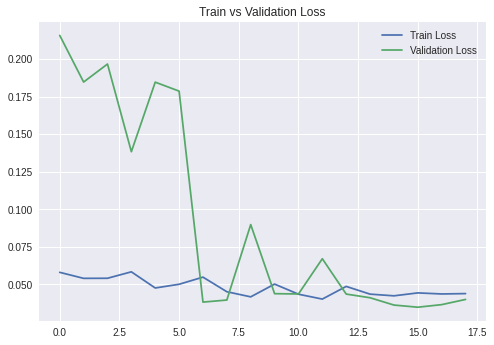

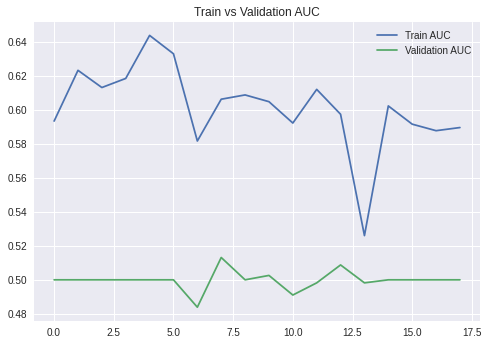


-------------------------------
Best metrics for validation set on Epoch 8:
Loss::      0.0396
AUC::       0.5131
Accuracy::  0.7750
F1::        0.0690
Precision:: 0.5000
Recall::    0.0370
Confusion Matrix:
 [[276   3]
 [ 78   3]]
-------------------------------


--------------------------------------------------------------------
--------------------------------------------------------------------
Running coronal - slice:49 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating final reference file for prepared images...
Loading untrained model...
VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1,

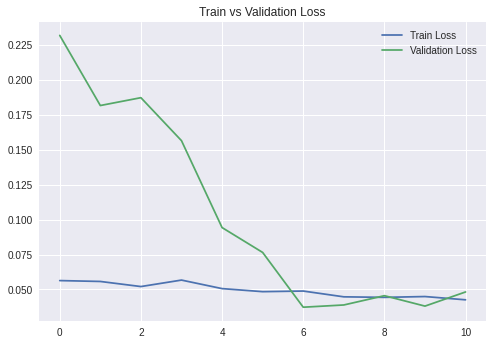

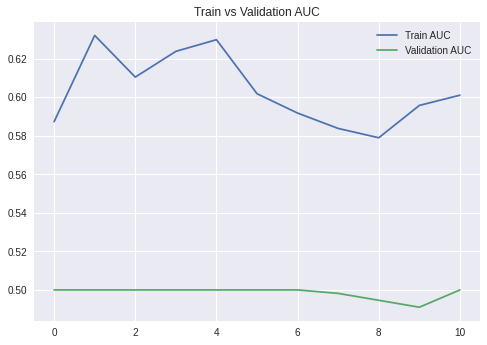


-------------------------------
Best metrics for validation set on Epoch 1:
Loss::      0.2318
AUC::       0.5000
Accuracy::  0.7750
F1::        0.0000
Precision:: 0.0000
Recall::    0.0000
Confusion Matrix:
 [[279   0]
 [ 81   0]]
-------------------------------



In [ ]:
df_results_vgg13_bn_c1 = run_mris_experiments(
                          orientation_and_slices = [
                                         ('coronal',list(range(48,50)))
                                         ],
                          num_repeats = 1,
                          model='vgg13_bn',
                          classes=['MCI','CN'],
                          mri_config = {
                            'num_samples':0,
                            'num_rotations':0,
                            'sampling_range':1,
                            'mri_reference':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/reference/PROCESSED_MRI_REFERENCE_ALL_ORIENTATIONS_20211030_2026.csv',
                            'output_path':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/mri/experiments/',
                          },
                          additional_experiment_params = {'lr':0.0001,
                            'batch_size':16,
                            'optimizer':'adam',
                            'max_epochs':100,
                            'early_stop':10,
                            'prediction_threshold':0.5},
                          save_path = '/content/gdrive/MyDrive/Lucas_Thimoteo/data/RESULTS_MCI_VGG13_CORONAL12.csv')

In [ ]:
df_results_vgg13_bn_c1.sort_values("validation_auc",ascending=False)

train_auc  train_accuracy  train_f1score  train_precision  train_recall  \
0   0.606353        0.602278       0.641581         0.569117      0.735192   
0   0.587247        0.586672       0.586498         0.568740      0.605401   

             train_conf_mat  validation_auc  validation_accuracy  \
0  [[584, 639], [304, 844]]        0.513142                0.775   
0  [[696, 527], [453, 695]]        0.500000                0.775   

   validation_f1score  validation_precision  validation_recall  \
0            0.068966                   0.5           0.037037   
0            0.000000                   0.0           0.000000   

   validation_conf_mat orientation  slice  run      RUN_ID  
0  [[276, 3], [78, 3]]     coronal     48    1  coronal481  
0  [[279, 0], [81, 0]]     coronal     49    1  coronal491


--------------------------------------------------------------------
--------------------------------------------------------------------
Running coronal - slice:0 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating final reference file for prepared images...
Loading untrained model...
VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), p

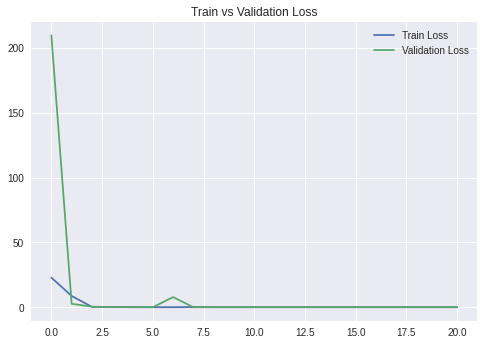

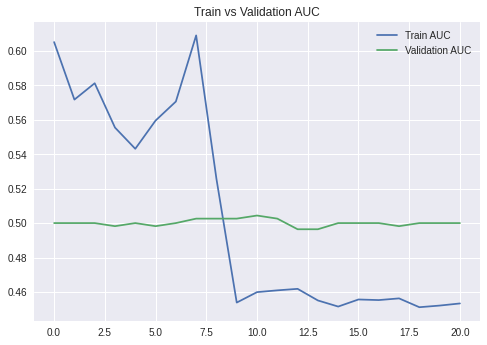


-------------------------------
Best metrics for validation set on Epoch 11:
Loss::      0.0390
AUC::       0.5044
Accuracy::  0.7750
F1::        0.0241
Precision:: 0.5000
Recall::    0.0123
Confusion Matrix:
 [[278   1]
 [ 80   1]]
-------------------------------


--------------------------------------------------------------------
--------------------------------------------------------------------
Running coronal - slice:1 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating final reference file for prepared images...
Loading untrained model...
VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1,

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d7820d4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d7820d4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d7820d4d0>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/d

Loss::      Train 40.0667      Validation 10.6145
AUC::       Train 0.5905      Validation 0.5000
Accuracy::  Train 0.5909      Validation 0.7750
F1::        Train 0.5775      Validation 0.0000
Precision:: Train 0.5775      Validation 0.0000
Recall::    Train 0.5775      Validation 0.0000
Validation Confusion Matrix:
 [[279   0]
 [ 81   0]]

Epoch 1 took 9.97 seconds
---------------------------------------------------------------------
Best validation AUC so far: 0.5000

---------------------------------------------------------------------
Running Epoch 2 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d7820d4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d7820d4d0>
    assert self._parent_pid == os.getpid(), 'can only test a child process'
Traceback (most recent call last):
AssertionError: can only test a child process
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 1.1088      Validation 45.6972
AUC::       Train 0.6066      Validation 0.5000
Accuracy::  Train 0.6027      Validation 0.7750
F1::        Train 0.6402      Validation 0.0000
Precision:: Train 0.5701      Validation 0.0000
Recall::    Train 0.7300      Validation 0.0000
Validation Confusion Matrix:
 [[279   0]
 [ 81   0]]

Epoch 2 took 9.90 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 3 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d7820d4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d7820d4d0>
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
Exception ignored in: <function _MultiProce

Loss::      Train 1.8718      Validation 9.2306
AUC::       Train 0.6292      Validation 0.5000
Accuracy::  Train 0.6255      Validation 0.7750
F1::        Train 0.6585      Validation 0.0000
Precision:: Train 0.5895      Validation 0.0000
Recall::    Train 0.7456      Validation 0.0000
Validation Confusion Matrix:
 [[279   0]
 [ 81   0]]

Epoch 3 took 9.95 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 4 of  100
Loss::      Train 0.3536      Validation 0.0377
AUC::       Train 0.6216      Validation 0.5000
Accuracy::  Train 0.6166      Validation 0.7750
F1::        Train 0.6627      Validation 0.0000
Precision:: Train 0.5772      Validation 0.0000
Recall::    Train 0.7779      Validation 0.0000
Validation Confusion Matrix:
 [[279   0]
 [ 81   0]]

Epoch 4 took 9.62 seconds
---------------------------------------------------------------------

----------------------------

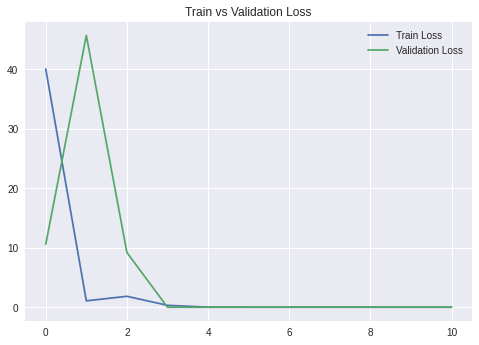

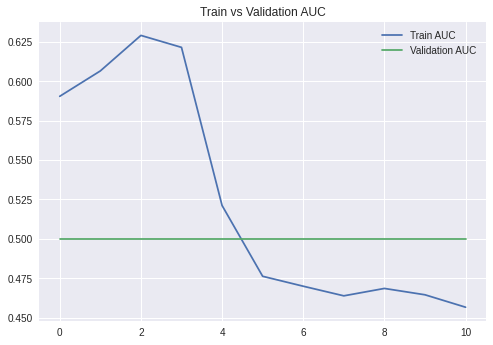


-------------------------------
Best metrics for validation set on Epoch 1:
Loss::      10.6145
AUC::       0.5000
Accuracy::  0.7750
F1::        0.0000
Precision:: 0.0000
Recall::    0.0000
Confusion Matrix:
 [[279   0]
 [ 81   0]]
-------------------------------


--------------------------------------------------------------------
--------------------------------------------------------------------
Running coronal - slice:2 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating final reference file for prepared images...
Loading untrained model...
VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1,

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d7820d4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d7820d4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 30.6645      Validation 74.0301
AUC::       Train 0.6156      Validation 0.5000
Accuracy::  Train 0.6120      Validation 0.7750
F1::        Train 0.6456      Validation 0.0000
Precision:: Train 0.5787      Validation 0.0000
Recall::    Train 0.7300      Validation 0.0000
Validation Confusion Matrix:
 [[279   0]
 [ 81   0]]

Epoch 1 took 9.86 seconds
---------------------------------------------------------------------
Best validation AUC so far: 0.5000

---------------------------------------------------------------------
Running Epoch 2 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d7820d4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d7820d4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d7820d4d0>
Traceback (most recent call last):
    self._shutdown_workers()
  File "/usr/local/lib/python3

Loss::      Train 4.0603      Validation 0.0478
AUC::       Train 0.6311      Validation 0.5000
Accuracy::  Train 0.6263      Validation 0.7750
F1::        Train 0.6699      Validation 0.0000
Precision:: Train 0.5853      Validation 0.0000
Recall::    Train 0.7831      Validation 0.0000
Validation Confusion Matrix:
 [[279   0]
 [ 81   0]]

Epoch 2 took 9.99 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 3 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d7820d4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d7820d4d0>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d7820d4d0>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3

Loss::      Train 0.1157      Validation 51.3171
AUC::       Train 0.5978      Validation 0.5000
Accuracy::  Train 0.5926      Validation 0.7750
F1::        Train 0.6441      Validation 0.0000
Precision:: Train 0.5581      Validation 0.0000
Recall::    Train 0.7613      Validation 0.0000
Validation Confusion Matrix:
 [[279   0]
 [ 81   0]]

Epoch 3 took 10.34 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 4 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d7820d4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d7820d4d0>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d7820d4d0>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d7820d4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
Trac

Loss::      Train 1.9621      Validation 93.1272
AUC::       Train 0.6268      Validation 0.5000
Accuracy::  Train 0.6234      Validation 0.7750
F1::        Train 0.6540      Validation 0.0000
Precision:: Train 0.5890      Validation 0.0000
Recall::    Train 0.7352      Validation 0.0000
Validation Confusion Matrix:
 [[279   0]
 [ 81   0]]

Epoch 4 took 9.96 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 5 of  100
Loss::      Train 4.1628      Validation 0.1995
AUC::       Train 0.6040      Validation 0.5000
Accuracy::  Train 0.6010      Validation 0.7750
F1::        Train 0.6287      Validation 0.0000
Precision:: Train 0.5721      Validation 0.0000
Recall::    Train 0.6977      Validation 0.0000
Validation Confusion Matrix:
 [[279   0]
 [ 81   0]]

Epoch 5 took 9.68 seconds
---------------------------------------------------------------------

---------------------------

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d7820d4d0>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d7820d4d0>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
Traceback (most recent call last):
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    assert self._parent_pid == os.getpid(), 'can only test a child process'
    self._shutdown_workers()
AssertionError: can only test a child process
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0488      Validation 0.0779
AUC::       Train 0.5852      Validation 0.5000
Accuracy::  Train 0.5812      Validation 0.7750
F1::        Train 0.6226      Validation 0.0000
Precision:: Train 0.5523      Validation 0.0000
Recall::    Train 0.7134      Validation 0.0000
Validation Confusion Matrix:
 [[279   0]
 [ 81   0]]

Epoch 19 took 10.00 seconds
---------------------------------------------------------------------

Exiting training... It hit early stopping criteria of: 10 epochs
Saving model at: 


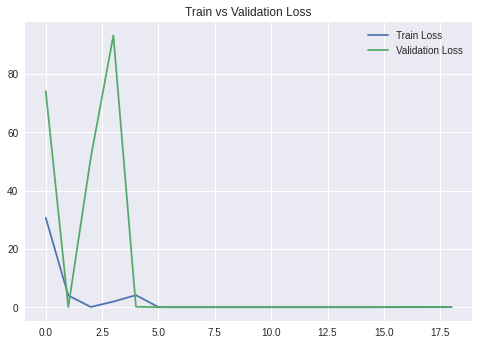

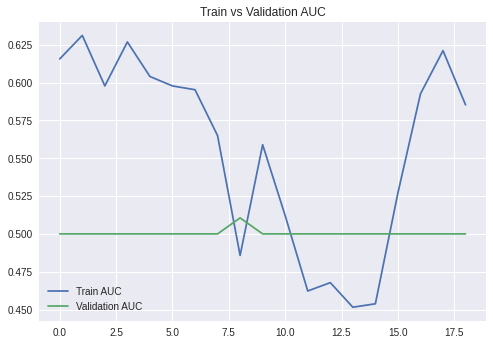


-------------------------------
Best metrics for validation set on Epoch 9:
Loss::      0.0453
AUC::       0.5106
Accuracy::  0.7778
F1::        0.0476
Precision:: 0.6667
Recall::    0.0247
Confusion Matrix:
 [[278   1]
 [ 79   2]]
-------------------------------


--------------------------------------------------------------------
--------------------------------------------------------------------
Running coronal - slice:3 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating final reference file for prepared images...
Loading untrained model...
VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d7820d4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d7820d4d0>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d7820d4d0>
Traceback (most recent call last):
Traceback (most recent call last):
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    self._shutdown_workers()
    if w

Loss::      Train 28.8293      Validation 39.4656
AUC::       Train 0.5875      Validation 0.5000
Accuracy::  Train 0.5871      Validation 0.7750
F1::        Train 0.5853      Validation 0.0000
Precision:: Train 0.5697      Validation 0.0000
Recall::    Train 0.6019      Validation 0.0000
Validation Confusion Matrix:
 [[279   0]
 [ 81   0]]

Epoch 1 took 10.02 seconds
---------------------------------------------------------------------
Best validation AUC so far: 0.5000

---------------------------------------------------------------------
Running Epoch 2 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d7820d4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d7820d4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
AssertionError: can only test a child process
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 2.1937      Validation 9.5647
AUC::       Train 0.5906      Validation 0.5000
Accuracy::  Train 0.5888      Validation 0.7750
F1::        Train 0.6045      Validation 0.0000
Precision:: Train 0.5657      Validation 0.0000
Recall::    Train 0.6490      Validation 0.0000
Validation Confusion Matrix:
 [[279   0]
 [ 81   0]]

Epoch 2 took 10.04 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 3 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d7820d4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d7820d4d0>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d7820d4d0>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/d

Loss::      Train 0.8103      Validation 10.6407
AUC::       Train 0.5818      Validation 0.5000
Accuracy::  Train 0.5803      Validation 0.7750
F1::        Train 0.5917      Validation 0.0000
Precision:: Train 0.5593      Validation 0.0000
Recall::    Train 0.6280      Validation 0.0000
Validation Confusion Matrix:
 [[279   0]
 [ 81   0]]

Epoch 3 took 10.23 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 4 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d7820d4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d7820d4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d7820d4d0>
    self._shutdown_workers()
Traceback (most recent call last):
  File "/usr/local/lib/python3

Loss::      Train 0.6677      Validation 1.7197
AUC::       Train 0.5718      Validation 0.5000
Accuracy::  Train 0.5732      Validation 0.7750
F1::        Train 0.5446      Validation 0.0000
Precision:: Train 0.5633      Validation 0.0000
Recall::    Train 0.5270      Validation 0.0000
Validation Confusion Matrix:
 [[279   0]
 [ 81   0]]

Epoch 4 took 9.97 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 5 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d7820d4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d7820d4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d7820d4d0>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/d

Loss::      Train 0.1190      Validation 0.9133
AUC::       Train 0.5877      Validation 0.5000
Accuracy::  Train 0.5900      Validation 0.7750
F1::        Train 0.5483      Validation 0.0000
Precision:: Train 0.5876      Validation 0.0000
Recall::    Train 0.5139      Validation 0.0000
Validation Confusion Matrix:
 [[279   0]
 [ 81   0]]

Epoch 5 took 10.04 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 6 of  100
Loss::      Train 0.1156      Validation 6.5193
AUC::       Train 0.5987      Validation 0.5000
Accuracy::  Train 0.5976      Validation 0.7750
F1::        Train 0.6035      Validation 0.0000
Precision:: Train 0.5771      Validation 0.0000
Recall::    Train 0.6324      Validation 0.0000
Validation Confusion Matrix:
 [[279   0]
 [ 81   0]]

Epoch 6 took 9.66 seconds
---------------------------------------------------------------------

---------------------------

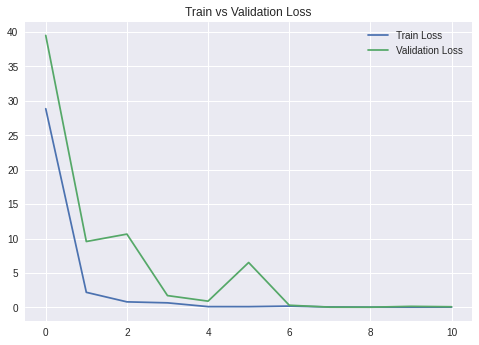

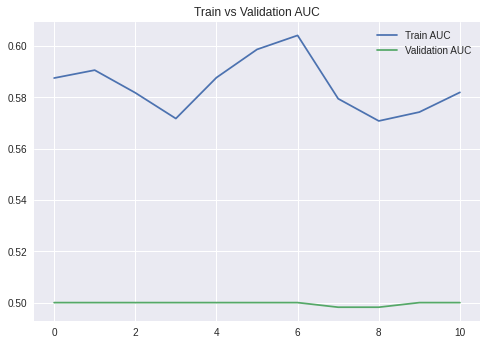


-------------------------------
Best metrics for validation set on Epoch 1:
Loss::      39.4656
AUC::       0.5000
Accuracy::  0.7750
F1::        0.0000
Precision:: 0.0000
Recall::    0.0000
Confusion Matrix:
 [[279   0]
 [ 81   0]]
-------------------------------


--------------------------------------------------------------------
--------------------------------------------------------------------
Running coronal - slice:4 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating final reference file for prepared images...
Loading untrained model...
VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1,

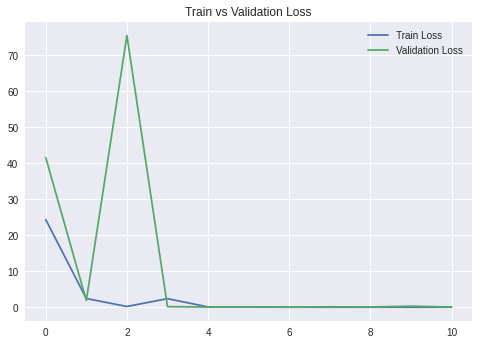

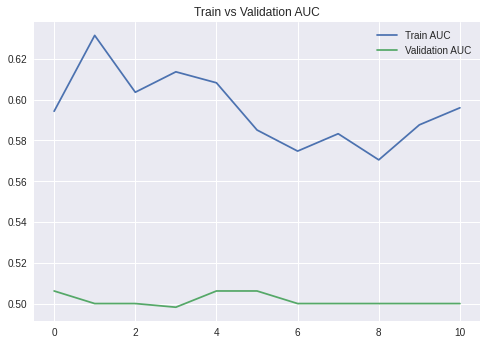


-------------------------------
Best metrics for validation set on Epoch 1:
Loss::      41.6210
AUC::       0.5062
Accuracy::  0.7778
F1::        0.0244
Precision:: 1.0000
Recall::    0.0123
Confusion Matrix:
 [[279   0]
 [ 80   1]]
-------------------------------


--------------------------------------------------------------------
--------------------------------------------------------------------
Running coronal - slice:5 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating final reference file for prepared images...
Loading untrained model...
VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1,

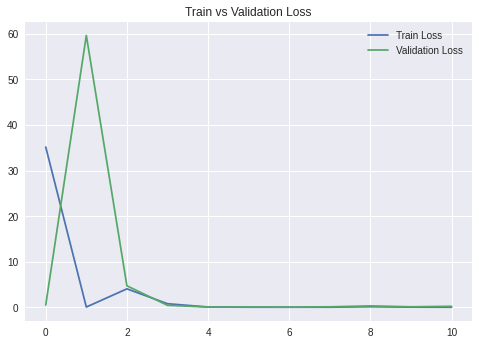

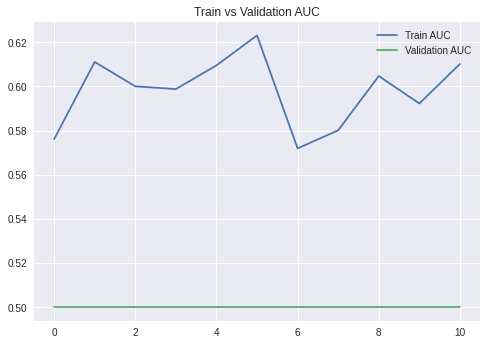


-------------------------------
Best metrics for validation set on Epoch 1:
Loss::      0.5260
AUC::       0.5000
Accuracy::  0.7750
F1::        0.0000
Precision:: 0.0000
Recall::    0.0000
Confusion Matrix:
 [[279   0]
 [ 81   0]]
-------------------------------


--------------------------------------------------------------------
--------------------------------------------------------------------
Running coronal - slice:6 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating final reference file for prepared images...
Loading untrained model...
VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 

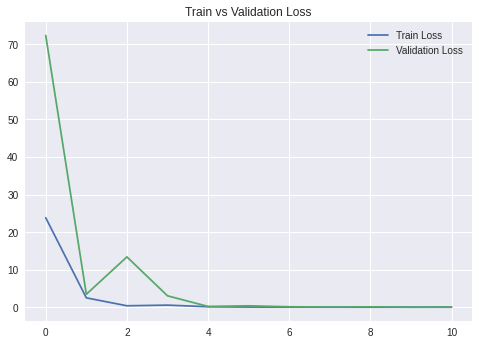

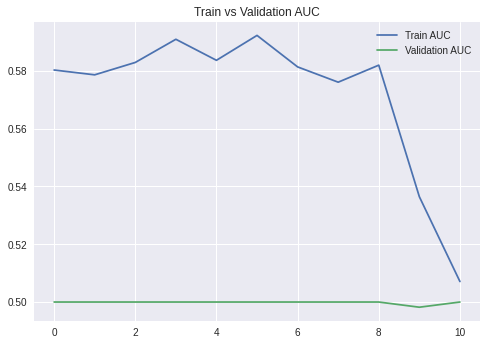


-------------------------------
Best metrics for validation set on Epoch 1:
Loss::      72.3525
AUC::       0.5000
Accuracy::  0.7750
F1::        0.0000
Precision:: 0.0000
Recall::    0.0000
Confusion Matrix:
 [[279   0]
 [ 81   0]]
-------------------------------


--------------------------------------------------------------------
--------------------------------------------------------------------
Running coronal - slice:7 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating final reference file for prepared images...
Loading untrained model...
VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1,

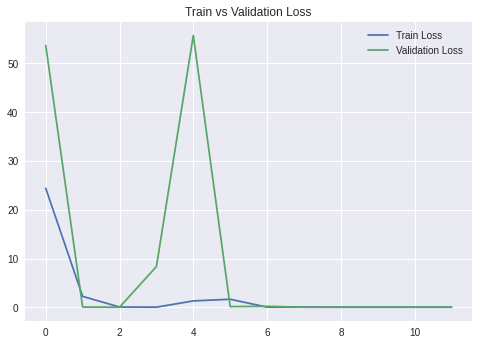

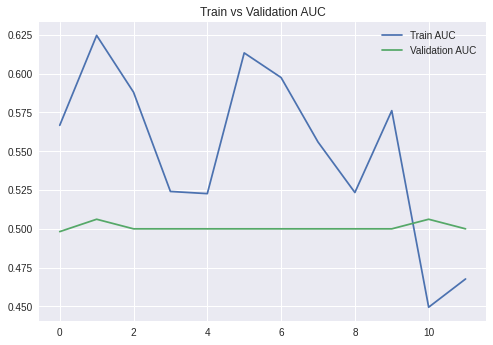


-------------------------------
Best metrics for validation set on Epoch 2:
Loss::      0.0725
AUC::       0.5062
Accuracy::  0.7778
F1::        0.0244
Precision:: 1.0000
Recall::    0.0123
Confusion Matrix:
 [[279   0]
 [ 80   1]]
-------------------------------


--------------------------------------------------------------------
--------------------------------------------------------------------
Running coronal - slice:8 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating final reference file for prepared images...
Loading untrained model...
VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 

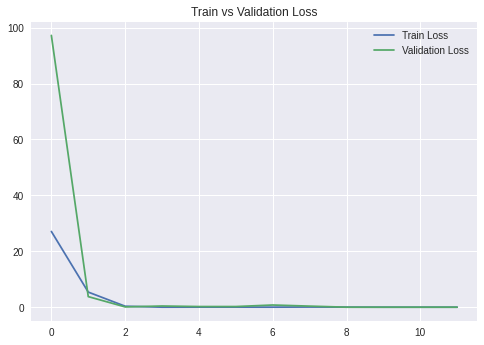

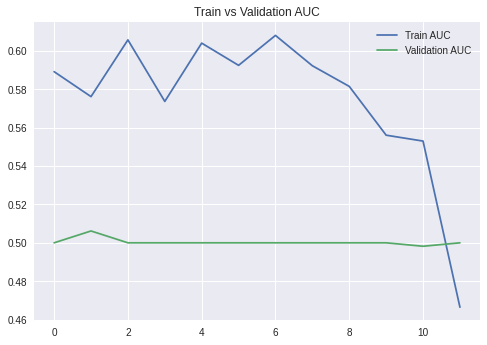


-------------------------------
Best metrics for validation set on Epoch 2:
Loss::      3.8221
AUC::       0.5062
Accuracy::  0.7778
F1::        0.0244
Precision:: 1.0000
Recall::    0.0123
Confusion Matrix:
 [[279   0]
 [ 80   1]]
-------------------------------


--------------------------------------------------------------------
--------------------------------------------------------------------
Running coronal - slice:9 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating final reference file for prepared images...
Loading untrained model...
VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 

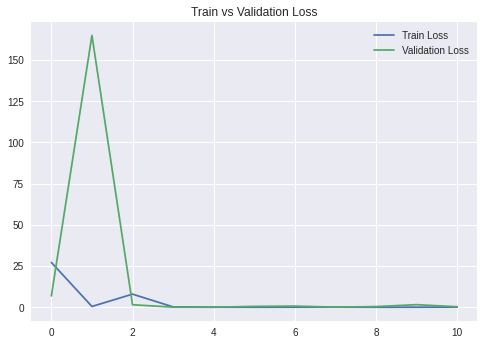

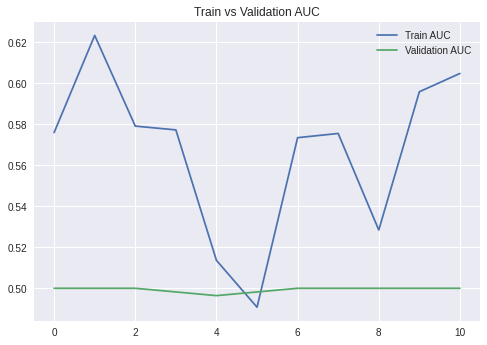


-------------------------------
Best metrics for validation set on Epoch 1:
Loss::      6.9042
AUC::       0.5000
Accuracy::  0.7750
F1::        0.0000
Precision:: 0.0000
Recall::    0.0000
Confusion Matrix:
 [[279   0]
 [ 81   0]]
-------------------------------


--------------------------------------------------------------------
--------------------------------------------------------------------
Running coronal - slice:10 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating final reference file for prepared images...
Loading untrained model...
VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1,

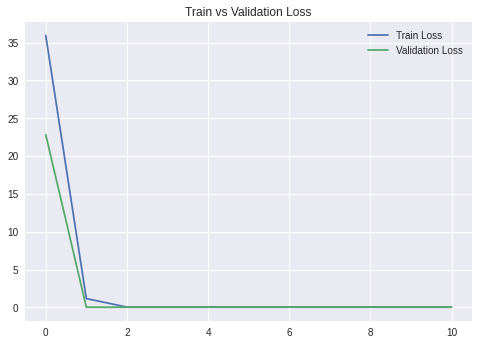

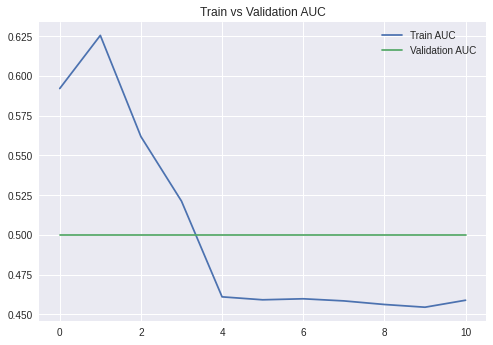


-------------------------------
Best metrics for validation set on Epoch 1:
Loss::      22.8257
AUC::       0.5000
Accuracy::  0.7750
F1::        0.0000
Precision:: 0.0000
Recall::    0.0000
Confusion Matrix:
 [[279   0]
 [ 81   0]]
-------------------------------


--------------------------------------------------------------------
--------------------------------------------------------------------
Running coronal - slice:11 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating final reference file for prepared images...
Loading untrained model...
VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1

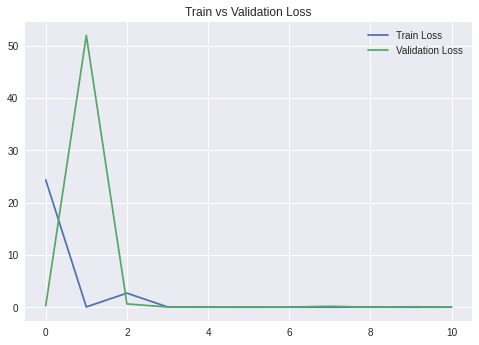

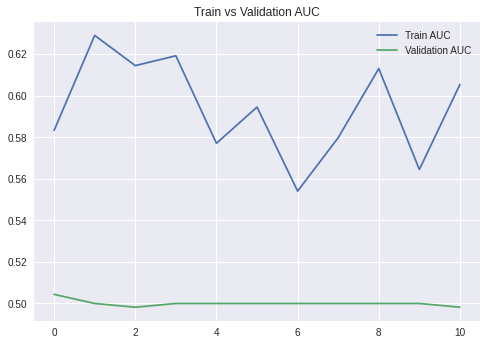


-------------------------------
Best metrics for validation set on Epoch 1:
Loss::      0.3255
AUC::       0.5044
Accuracy::  0.7750
F1::        0.0241
Precision:: 0.5000
Recall::    0.0123
Confusion Matrix:
 [[278   1]
 [ 80   1]]
-------------------------------


--------------------------------------------------------------------
--------------------------------------------------------------------
Running coronal - slice:12 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating final reference file for prepared images...
Loading untrained model...
VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1,

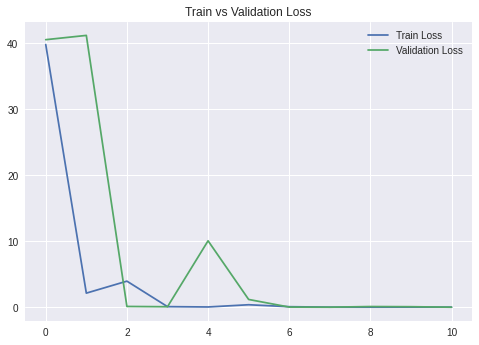

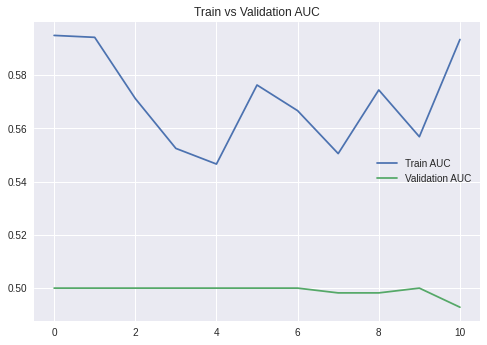


-------------------------------
Best metrics for validation set on Epoch 1:
Loss::      40.5263
AUC::       0.5000
Accuracy::  0.7750
F1::        0.0000
Precision:: 0.0000
Recall::    0.0000
Confusion Matrix:
 [[279   0]
 [ 81   0]]
-------------------------------


--------------------------------------------------------------------
--------------------------------------------------------------------
Running coronal - slice:13 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating final reference file for prepared images...
Loading untrained model...
VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1

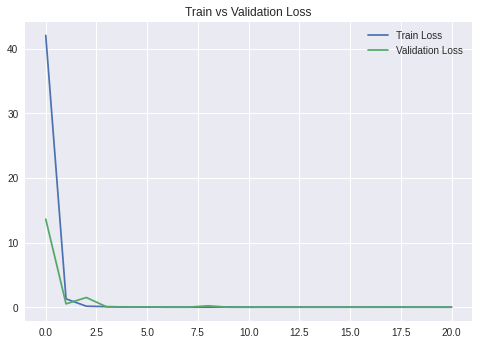

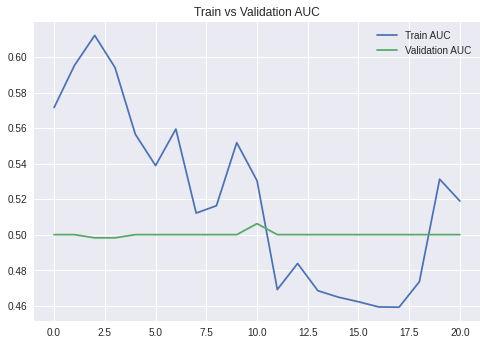


-------------------------------
Best metrics for validation set on Epoch 11:
Loss::      0.0346
AUC::       0.5062
Accuracy::  0.7778
F1::        0.0244
Precision:: 1.0000
Recall::    0.0123
Confusion Matrix:
 [[279   0]
 [ 80   1]]
-------------------------------


--------------------------------------------------------------------
--------------------------------------------------------------------
Running coronal - slice:14 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating final reference file for prepared images...
Loading untrained model...
VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1

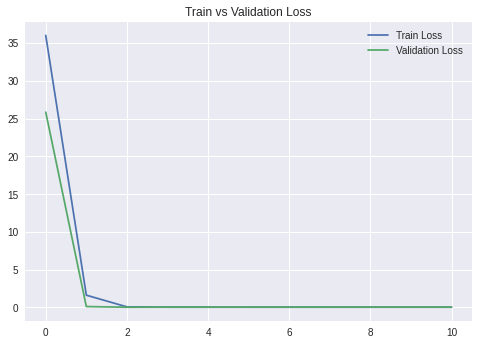

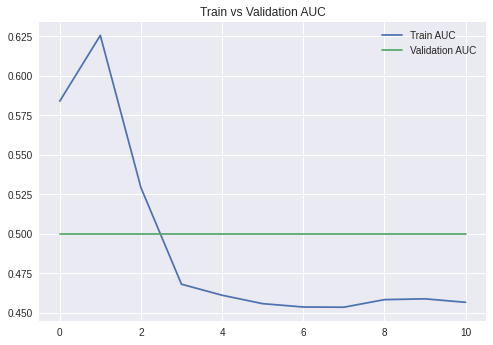


-------------------------------
Best metrics for validation set on Epoch 1:
Loss::      25.8411
AUC::       0.5000
Accuracy::  0.7750
F1::        0.0000
Precision:: 0.0000
Recall::    0.0000
Confusion Matrix:
 [[279   0]
 [ 81   0]]
-------------------------------


--------------------------------------------------------------------
--------------------------------------------------------------------
Running coronal - slice:15 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating final reference file for prepared images...
Loading untrained model...
VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1

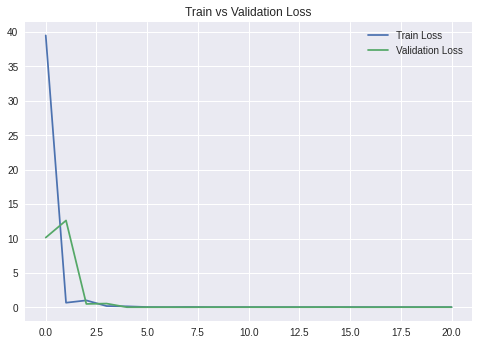

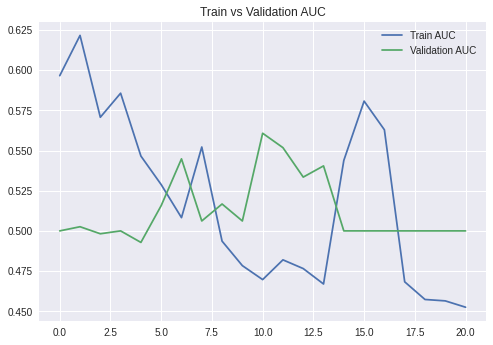


-------------------------------
Best metrics for validation set on Epoch 11:
Loss::      0.0400
AUC::       0.5607
Accuracy::  0.7944
F1::        0.2292
Precision:: 0.7333
Recall::    0.1358
Confusion Matrix:
 [[275   4]
 [ 70  11]]
-------------------------------


--------------------------------------------------------------------
--------------------------------------------------------------------
Running coronal - slice:16 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating final reference file for prepared images...
Loading untrained model...
VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1

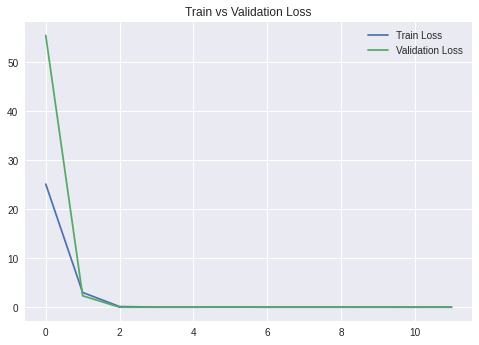

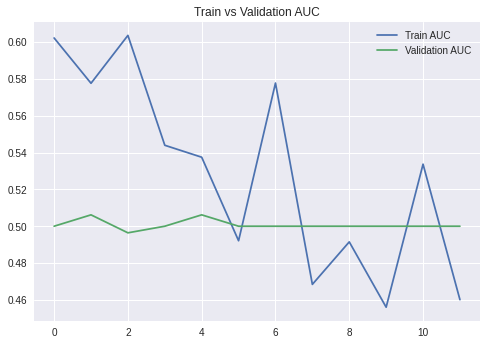


-------------------------------
Best metrics for validation set on Epoch 2:
Loss::      2.3645
AUC::       0.5062
Accuracy::  0.7778
F1::        0.0244
Precision:: 1.0000
Recall::    0.0123
Confusion Matrix:
 [[279   0]
 [ 80   1]]
-------------------------------


--------------------------------------------------------------------
--------------------------------------------------------------------
Running coronal - slice:17 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating final reference file for prepared images...
Loading untrained model...
VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1,

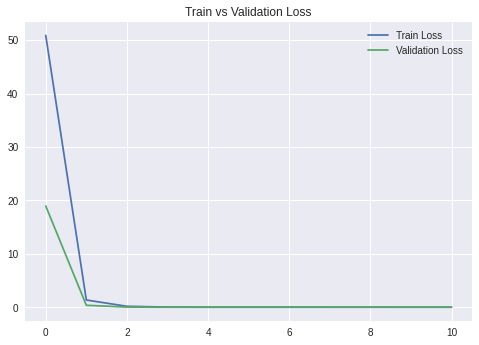

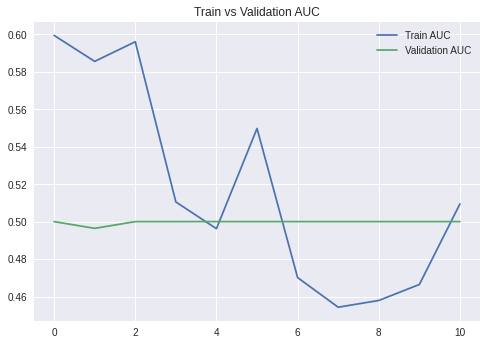


-------------------------------
Best metrics for validation set on Epoch 1:
Loss::      18.9765
AUC::       0.5000
Accuracy::  0.7750
F1::        0.0000
Precision:: 0.0000
Recall::    0.0000
Confusion Matrix:
 [[279   0]
 [ 81   0]]
-------------------------------


--------------------------------------------------------------------
--------------------------------------------------------------------
Running coronal - slice:18 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating final reference file for prepared images...
Loading untrained model...
VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1

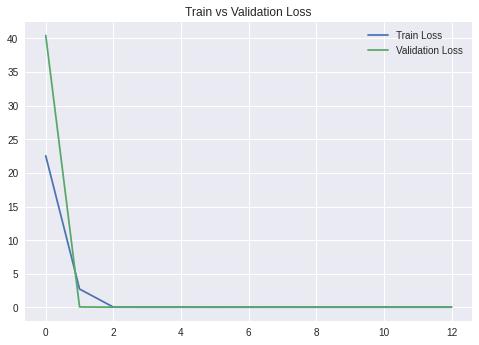

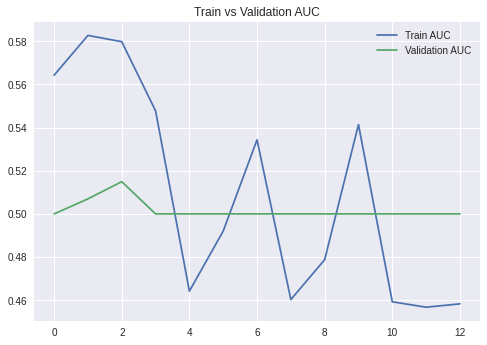


-------------------------------
Best metrics for validation set on Epoch 3:
Loss::      0.0444
AUC::       0.5149
Accuracy::  0.7778
F1::        0.0698
Precision:: 0.6000
Recall::    0.0370
Confusion Matrix:
 [[277   2]
 [ 78   3]]
-------------------------------


--------------------------------------------------------------------
--------------------------------------------------------------------
Running coronal - slice:19 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating final reference file for prepared images...
Loading untrained model...
VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1,

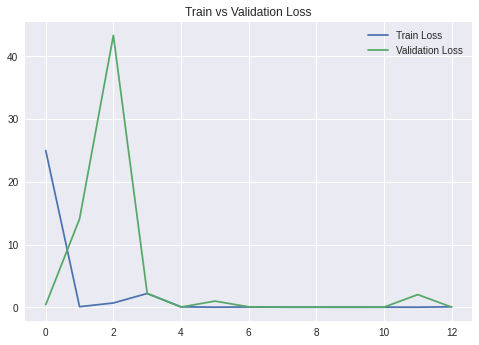

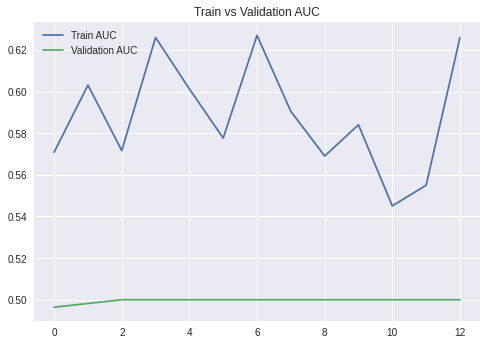


-------------------------------
Best metrics for validation set on Epoch 3:
Loss::      43.3090
AUC::       0.5000
Accuracy::  0.7750
F1::        0.0000
Precision:: 0.0000
Recall::    0.0000
Confusion Matrix:
 [[279   0]
 [ 81   0]]
-------------------------------


--------------------------------------------------------------------
--------------------------------------------------------------------
Running coronal - slice:20 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating final reference file for prepared images...
Loading untrained model...
VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1

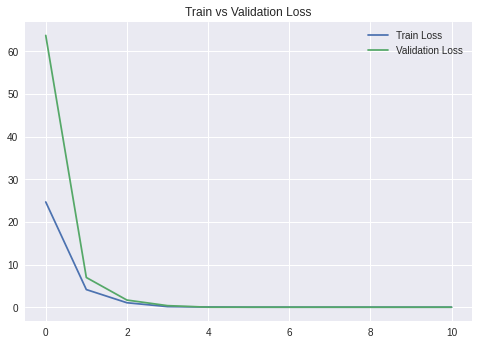

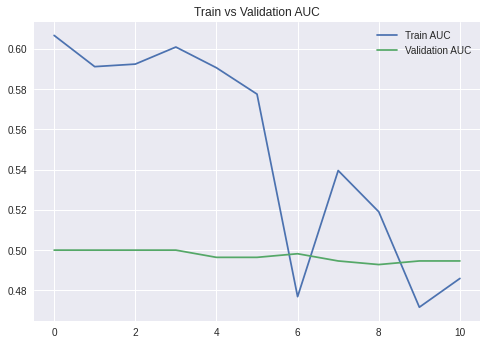


-------------------------------
Best metrics for validation set on Epoch 1:
Loss::      63.7082
AUC::       0.5000
Accuracy::  0.7750
F1::        0.0000
Precision:: 0.0000
Recall::    0.0000
Confusion Matrix:
 [[279   0]
 [ 81   0]]
-------------------------------


--------------------------------------------------------------------
--------------------------------------------------------------------
Running coronal - slice:21 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating final reference file for prepared images...
Loading untrained model...
VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1

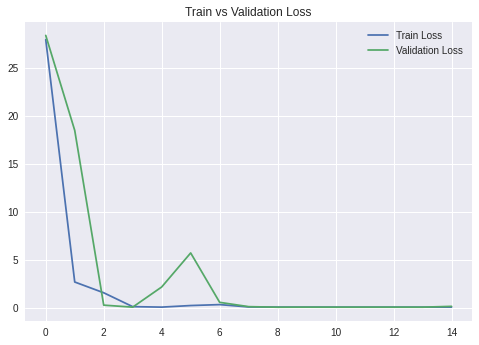

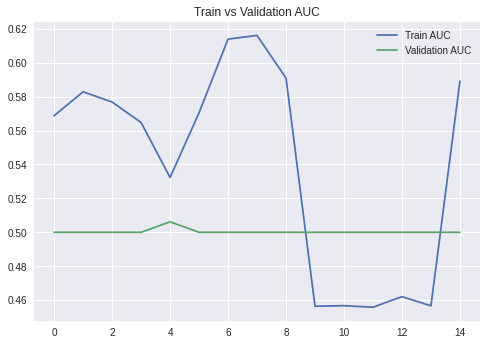


-------------------------------
Best metrics for validation set on Epoch 5:
Loss::      2.1458
AUC::       0.5062
Accuracy::  0.7778
F1::        0.0244
Precision:: 1.0000
Recall::    0.0123
Confusion Matrix:
 [[279   0]
 [ 80   1]]
-------------------------------


--------------------------------------------------------------------
--------------------------------------------------------------------
Running coronal - slice:22 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating final reference file for prepared images...
Loading untrained model...
VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1,

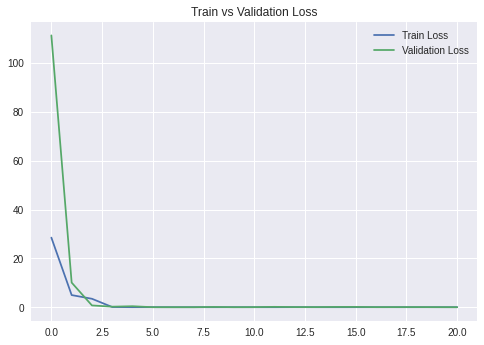

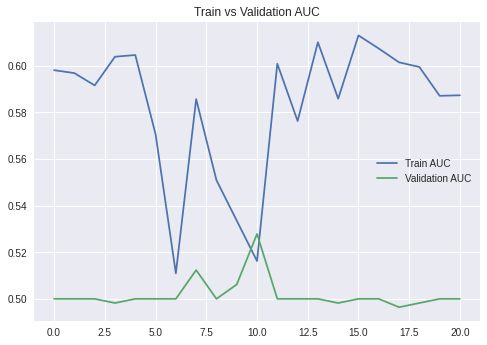


-------------------------------
Best metrics for validation set on Epoch 11:
Loss::      0.0610
AUC::       0.5279
Accuracy::  0.7639
F1::        0.1584
Precision:: 0.4000
Recall::    0.0988
Confusion Matrix:
 [[267  12]
 [ 73   8]]
-------------------------------


--------------------------------------------------------------------
--------------------------------------------------------------------
Running coronal - slice:23 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating final reference file for prepared images...
Loading untrained model...
VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1

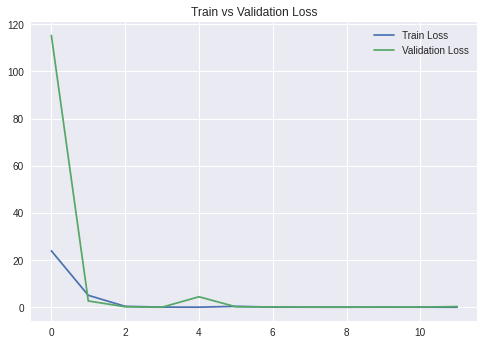

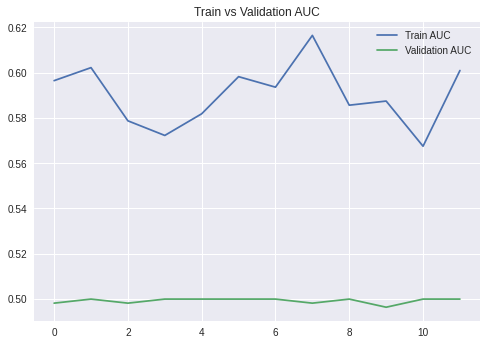


-------------------------------
Best metrics for validation set on Epoch 2:
Loss::      2.6991
AUC::       0.5000
Accuracy::  0.7750
F1::        0.0000
Precision:: 0.0000
Recall::    0.0000
Confusion Matrix:
 [[279   0]
 [ 81   0]]
-------------------------------


--------------------------------------------------------------------
--------------------------------------------------------------------
Running coronal - slice:24 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating final reference file for prepared images...
Loading untrained model...
VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1,

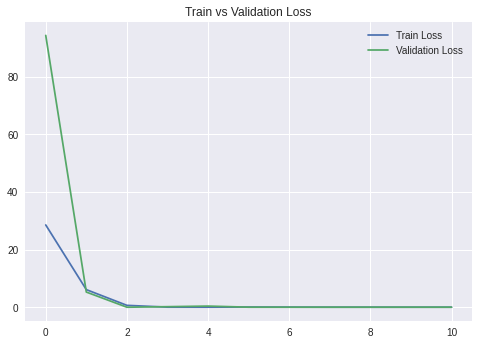

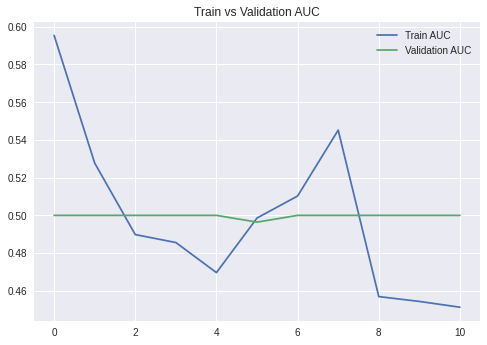


-------------------------------
Best metrics for validation set on Epoch 1:
Loss::      94.2804
AUC::       0.5000
Accuracy::  0.7750
F1::        0.0000
Precision:: 0.0000
Recall::    0.0000
Confusion Matrix:
 [[279   0]
 [ 81   0]]
-------------------------------


--------------------------------------------------------------------
--------------------------------------------------------------------
Running coronal - slice:25 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating final reference file for prepared images...
Loading untrained model...
VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1

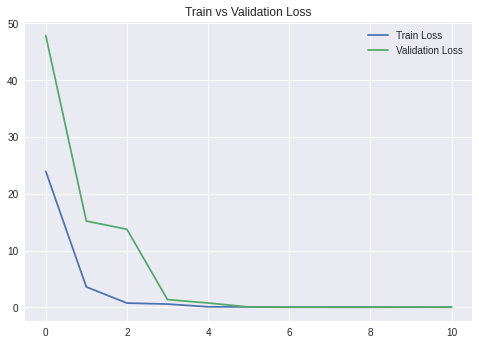

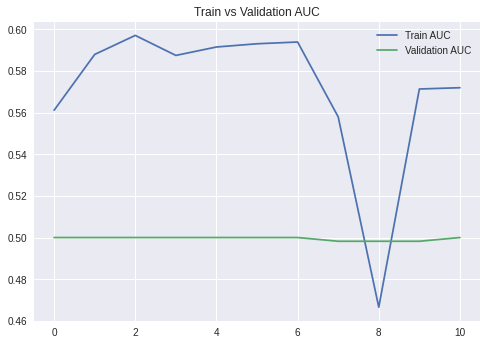


-------------------------------
Best metrics for validation set on Epoch 1:
Loss::      47.8853
AUC::       0.5000
Accuracy::  0.7750
F1::        0.0000
Precision:: 0.0000
Recall::    0.0000
Confusion Matrix:
 [[279   0]
 [ 81   0]]
-------------------------------


--------------------------------------------------------------------
--------------------------------------------------------------------
Running coronal - slice:26 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating final reference file for prepared images...
Loading untrained model...
VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1

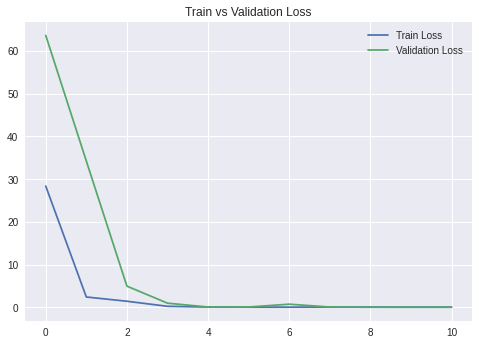

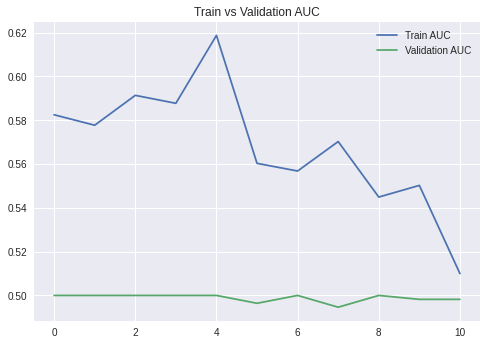


-------------------------------
Best metrics for validation set on Epoch 1:
Loss::      63.6271
AUC::       0.5000
Accuracy::  0.7750
F1::        0.0000
Precision:: 0.0000
Recall::    0.0000
Confusion Matrix:
 [[279   0]
 [ 81   0]]
-------------------------------


--------------------------------------------------------------------
--------------------------------------------------------------------
Running coronal - slice:27 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating final reference file for prepared images...
Loading untrained model...
VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1

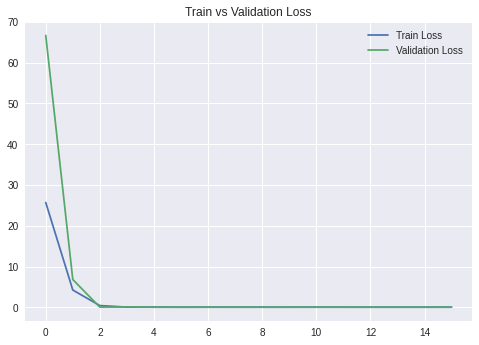

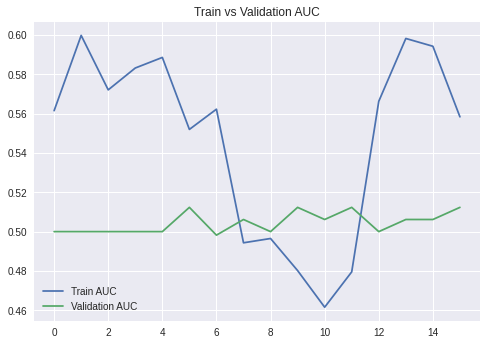


-------------------------------
Best metrics for validation set on Epoch 6:
Loss::      0.0335
AUC::       0.5123
Accuracy::  0.7806
F1::        0.0482
Precision:: 1.0000
Recall::    0.0247
Confusion Matrix:
 [[279   0]
 [ 79   2]]
-------------------------------


--------------------------------------------------------------------
--------------------------------------------------------------------
Running coronal - slice:28 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating final reference file for prepared images...
Loading untrained model...
VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1,

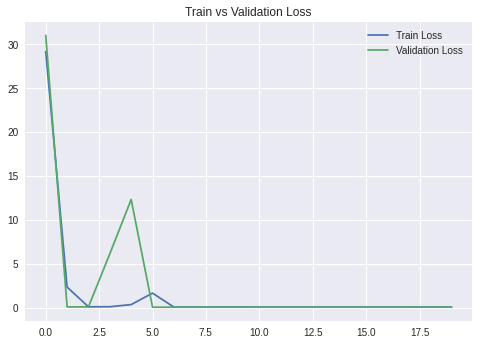

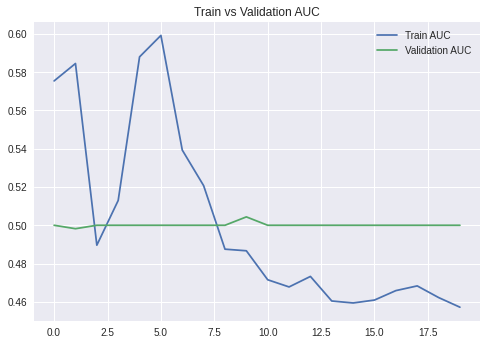


-------------------------------
Best metrics for validation set on Epoch 10:
Loss::      0.0389
AUC::       0.5044
Accuracy::  0.7750
F1::        0.0241
Precision:: 0.5000
Recall::    0.0123
Confusion Matrix:
 [[278   1]
 [ 80   1]]
-------------------------------


--------------------------------------------------------------------
--------------------------------------------------------------------
Running coronal - slice:29 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating final reference file for prepared images...
Loading untrained model...
VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1

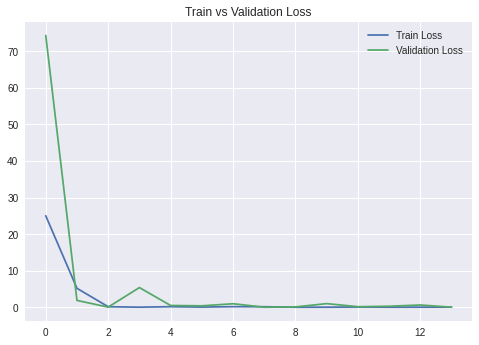

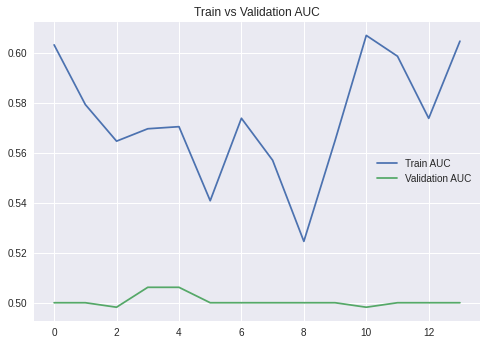


-------------------------------
Best metrics for validation set on Epoch 4:
Loss::      5.4110
AUC::       0.5062
Accuracy::  0.7778
F1::        0.0244
Precision:: 1.0000
Recall::    0.0123
Confusion Matrix:
 [[279   0]
 [ 80   1]]
-------------------------------



In [ ]:
df_results_vgg13_bn_c1 = run_mris_experiments(
                          orientation_and_slices = [
                                         ('coronal',list(range(0,30)))
                                         ],
                          num_repeats = 1,
                          model='vgg13_bn',
                          classes=['MCI','CN'],
                          mri_config = {
                            'num_samples':0,
                            'num_rotations':0,
                            'sampling_range':1,
                            'mri_reference':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/reference/PROCESSED_MRI_REFERENCE_ALL_ORIENTATIONS_20211030_2026.csv',
                            'output_path':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/mri/experiments/',
                          },
                          additional_experiment_params = {'lr':0.01,
                            'batch_size':16,
                            'optimizer':'adam',
                            'max_epochs':100,
                            'early_stop':10,
                            'prediction_threshold':0.5},
                          save_path = '/content/gdrive/MyDrive/Lucas_Thimoteo/data/RESULTS_MCI_VGG13_CORONAL1_LR01.csv')

In [ ]:
df_results_vgg13_bn_c1.sort_values("validation_auc",ascending=False)

train_auc  train_accuracy  train_f1score  train_precision  train_recall  \
0   0.469700        0.469844       0.459355         0.453696      0.465157   
0   0.516229        0.522143       0.400212         0.510121      0.329268   
0   0.579828        0.577394       0.600797         0.553598      0.656794   
0   0.552005        0.551666       0.548620         0.535211      0.562718   
0   0.485739        0.493884       0.303944         0.454861      0.228223   
0   0.530394        0.532265       0.493838         0.518696      0.471254   
0   0.532331        0.534374       0.493113         0.521359      0.467770   
0   0.577593        0.577815       0.566854         0.563199      0.570557   
0   0.569628        0.570645       0.547957         0.558877      0.537456   
0   0.576185        0.578237       0.540018         0.572125      0.511324   
0   0.624535        0.617039       0.685378         0.569045      0.861498   
0   0.594341        0.592999       0.602390         0.571540      0.636760   
0   0.459925        0.464361       0.366267         0.428738      0.319686   
0   0.583300        0.582876       0.580755         0.565648      0.596690   
0   0.486666        0.487980       0.457066         0.469669      0.445122   
0   0.576120        0.574863       0.583815         0.554945      0.615854   
0   0.587549        0.587094       0.585345         0.569662      0.601916   
0   0.582503        0.580346       0.600241         0.557047      0.650697   
0   0.561186        0.560945       0.556455         0.544621      0.568815   
0   0.595409        0.592999       0.615078         0.567329      0.671603   
0   0.602162        0.601012       0.607794         0.579905      0.638502   
0   0.576031        0.574441       0.587658         0.553503      0.626307   
0   0.606696        0.604808       0.620186         0.579985      0.666376   
0   0.592155        0.590468       0.604158         0.567816      0.645470   
0   0.580270        0.579502       0.581971         0.561035      0.604530   
0   0.599325        0.599325       0.591574         0.584041      0.599303   
0   0.590480        0.590890       0.577526         0.577526      0.577526   
0   0.584038        0.583720       0.580179         0.566916      0.594077   
0   0.594891        0.593842       0.599584         0.573588      0.628049   
0   0.571697        0.568536       0.601170         0.544107      0.671603   

             train_conf_mat  validation_auc  validation_accuracy  \
0  [[580, 643], [614, 534]]        0.560733             0.794444   
0  [[860, 363], [770, 378]]        0.527877             0.763889   
0  [[615, 608], [394, 754]]        0.514934             0.777778   
0  [[662, 561], [502, 646]]        0.512346             0.780556   
0  [[909, 314], [886, 262]]        0.510554             0.777778   
0  [[721, 502], [607, 541]]        0.506173             0.777778   
0  [[730, 493], [611, 537]]        0.506173             0.777778   
0  [[715, 508], [493, 655]]        0.506173             0.777778   
0  [[736, 487], [531, 617]]        0.506173             0.777778   
0  [[784, 439], [561, 587]]        0.506173             0.777778   
0  [[474, 749], [159, 989]]        0.506173             0.777778   
0  [[675, 548], [417, 731]]        0.506173             0.777778   
0  [[734, 489], [781, 367]]        0.504381             0.775000   
0  [[697, 526], [463, 685]]        0.504381             0.775000   
0  [[646, 577], [637, 511]]        0.504381             0.775000   
0  [[656, 567], [441, 707]]        0.500000             0.775000   
0  [[701, 522], [457, 691]]        0.500000             0.775000   
0  [[629, 594], [401, 747]]        0.500000             0.775000   
0  [[677, 546], [495, 653]]        0.500000             0.775000   
0  [[635, 588], [377, 771]]        0.500000             0.775000   
0  [[692, 531], [415, 733]]        0.500000             0.775000   
0  [[643, 580], [429, 719]]        0.500000             0.775000   
0  [[669, 554], [383

# Coronal Slices with Shallow CNN to go faster

In [ ]:
df_shallow_coronal = run_mris_experiments(
                          orientation_and_slices = [
                                         ('coronal',list(range(0,20)))
                                         ],
                          num_repeats = 1,
                          model='vgg13_bn',
                          classes=['MCI','CN'],
                          mri_config = {
                            'num_samples':0,
                            'num_rotations':0,
                            'sampling_range':1,
                            'mri_reference':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/reference/PROCESSED_MRI_REFERENCE_ALL_ORIENTATIONS_20211030_2026.csv',
                            'output_path':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/mri/experiments/',
                          },
                          additional_experiment_params = {'lr':0.0001,
                            'batch_size':16,
                            'optimizer':'sgd',
                            'max_epochs':100,
                            'early_stop':35,
                            'prediction_threshold':0.5,
                            'momentum':0.99},
                          save_path = '/content/gdrive/MyDrive/Lucas_Thimoteo/data/TEST_MCI_VGG13_CORONAL_MOMENTUM.csv')

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
df_vgg13_coronal = run_mris_experiments(
                          orientation_and_slices = [
                                         ('coronal',list(range(20,47)) + list(range(48,61)) + list(range(70,100)))
                                         ],
                          num_repeats = 1,
                          model='vgg13_bn',
                          classes=['MCI','CN'],
                          mri_config = {
                            'num_samples':0,
                            'num_rotations':0,
                            'sampling_range':1,
                            'mri_reference':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/reference/PROCESSED_MRI_REFERENCE_ALL_ORIENTATIONS_20211030_2026.csv',
                            'output_path':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/mri/experiments/',
                          },
                          additional_experiment_params = {'lr':0.0001,
                            'batch_size':16,
                            'optimizer':'sgd',
                            'max_epochs':100,
                            'early_stop':35,
                            'prediction_threshold':0.5,
                            'momentum':0.99},
                          save_path = '/content/gdrive/MyDrive/Lucas_Thimoteo/data/TEST_MCI_VGG13_CORONAL_MOMENTUM2.csv')

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
df_vgg13_coronal.sort_values('validation_auc',ascending=False)

In [ ]:
df_vgg13_axial = run_mris_experiments(
                          orientation_and_slices = [
                                         ('axial',list(range(0,100,2)))
                                         ],
                          num_repeats = 1,
                          model='vgg13_bn',
                          classes=['MCI','CN'], 
                          mri_config = {
                            'num_samples':0,
                            'num_rotations':0,
                            'sampling_range':1,
                            'mri_reference':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/reference/PROCESSED_MRI_REFERENCE_ALL_ORIENTATIONS_20211030_2026.csv',
                            'output_path':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/mri/experiments/',
                          },
                          additional_experiment_params = {'lr':0.0001,
                            'batch_size':16,
                            'optimizer':'sgd',
                            'max_epochs':100,
                            'early_stop':35,
                            'prediction_threshold':0.5,
                            'momentum':0.99},
                          save_path = '/content/gdrive/MyDrive/Lucas_Thimoteo/data/TEST_MCI_VGG13_AXIAL_MOMENTUM.csv')

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
df_vgg13_axial.sort_values('validation_auc',ascending=False)0

In [18]:
df_vgg13_sagittal = run_mris_experiments(
                          orientation_and_slices = [
                                         ('sagittal',list(range(0,100,2)))
                                         ],
                          num_repeats = 1,
                          model='vgg13_bn',
                          classes=['MCI','CN'],
                          mri_config = {
                            'num_samples':0,
                            'num_rotations':0,
                            'sampling_range':1,
                            'mri_reference':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/reference/PROCESSED_MRI_REFERENCE_ALL_ORIENTATIONS_20211030_2026.csv',
                            'output_path':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/mri/experiments/',
                          },
                          additional_experiment_params = {'lr':0.0001,
                            'batch_size':16,
                            'optimizer':'sgd',
                            'max_epochs':100,
                            'early_stop':35,
                            'prediction_threshold':0.5,
                            'momentum':0.99},
                          save_path = '/content/gdrive/MyDrive/Lucas_Thimoteo/data/TEST_MCI_VGG13_SAGITTAL_MOMENTUM.csv')

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
df_vgg13_sagittal.sort_values('validation_auc',ascending=False)

# Final VGG13 Runs for ensemble

In [20]:
def run_experiments_for_ensemble(orientation_and_slices = [('coronal',list(range(45,56)))],
                          model='shallow_cnn',
                          classes=['AD','CN'],
                          mri_config = {
                            'num_samples':0,
                            'num_rotations':0,
                            'sampling_range':3,
                            'mri_reference':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/reference/PROCESSED_MRI_REFERENCE_ALL_ORIENTATIONS_20211012_2041.csv',
                            'output_path':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/mri/experiments/',
                            },
                          additional_experiment_params = None,
                          save_path = ''):

    predictions = []
    for orientation,slices in orientation_and_slices:
        mri_config['orientation'] = orientation
        for slice in slices:
            print("\n--------------------------------------------------------------------")
            print("--------------------------------------------------------------------")
            print(f"Running {orientation} - slice:{slice} with no data augmentation.")
            print("--------------------------------------------------------------------")
            print("--------------------------------------------------------------------\n")
            mri_config['slice'] = slice
            df_ref = generate_mri_dataset_reference(mri_reference_path = mri_config['mri_reference'],
                                output_path = mri_config['output_path'],
                                orientation = mri_config['orientation'],
                                orientation_slice = mri_config['slice'],
                                num_sampled_images = mri_config['num_samples'],
                                sampling_range = mri_config['sampling_range'],
                                num_rotations = mri_config['num_rotations'],
                                save_reference_file = False)
            prediction,_ = run_cnn_experiment(model = model,
                        model_name = 'cnn_'+orientation+str(slice),
                        classes = classes,
                        mri_reference = df_ref,
                        run_test = False,
                        compute_predictions = True,
                        prediction_dataset_path = '',
                        model_path = '',
                        additional_experiment_params = additional_experiment_params)
            prediction['orientation'] = orientation
            prediction['slice'] = slice
            prediction['RUN_ID'] = orientation+str(slice)
            predictions.append(prediction)

    df_predictions = pd.concat(predictions)
    # TODO: pivot table to make RUN_ID turn into columns for the prediction scores
    if save_path != '' and save_path is not None:
        df_predictions.to_csv(save_path,index=False)
    return df_predictions


--------------------------------------------------------------------
--------------------------------------------------------------------
Running coronal - slice:95 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating final reference file for prepared images...
Loading untrained model...
VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), 

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0476      Validation 0.0365
AUC::       Train 0.6294      Validation 0.5000
Accuracy::  Train 0.6274      Validation 0.7750
F1::        Train 0.6427      Validation 0.0000
Precision:: Train 0.6002      Validation 0.0000
Recall::    Train 0.6916      Validation 0.0000
Validation Confusion Matrix:
 [[279   0]
 [ 81   0]]

Epoch 6 took 9.22 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 7 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0442      Validation 0.0356
AUC::       Train 0.5733      Validation 0.5000
Accuracy::  Train 0.5747      Validation 0.7750
F1::        Train 0.5459      Validation 0.0000
Precision:: Train 0.5653      Validation 0.0000
Recall::    Train 0.5279      Validation 0.0000
Validation Confusion Matrix:
 [[279   0]
 [ 81   0]]

Epoch 7 took 9.32 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 8 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0466      Validation 0.0390
AUC::       Train 0.4723      Validation 0.5000
Accuracy::  Train 0.4772      Validation 0.7750
F1::        Train 0.3688      Validation 0.0000
Precision:: Train 0.4442      Validation 0.0000
Recall::    Train 0.3153      Validation 0.0000
Validation Confusion Matrix:
 [[279   0]
 [ 81   0]]

Epoch 8 took 9.30 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 9 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/

Loss::      Train 0.0442      Validation 0.0381
AUC::       Train 0.5000      Validation 0.5000
Accuracy::  Train 0.5156      Validation 0.7750
F1::        Train 0.0000      Validation 0.0000
Precision:: Train 0.0000      Validation 0.0000
Recall::    Train 0.0000      Validation 0.0000
Validation Confusion Matrix:
 [[279   0]
 [ 81   0]]

Epoch 9 took 9.27 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 10 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/

Loss::      Train 0.0462      Validation 0.0390
AUC::       Train 0.4787      Validation 0.5000
Accuracy::  Train 0.4827      Validation 0.7750
F1::        Train 0.3955      Validation 0.0000
Precision:: Train 0.4557      Validation 0.0000
Recall::    Train 0.3493      Validation 0.0000
Validation Confusion Matrix:
 [[279   0]
 [ 81   0]]

Epoch 10 took 9.22 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 11 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
AssertionError: can only test a child process
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0439      Validation 0.0356
AUC::       Train 0.5000      Validation 0.5000
Accuracy::  Train 0.5156      Validation 0.7750
F1::        Train 0.0000      Validation 0.0000
Precision:: Train 0.0000      Validation 0.0000
Recall::    Train 0.0000      Validation 0.0000
Validation Confusion Matrix:
 [[279   0]
 [ 81   0]]

Epoch 11 took 9.32 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 12 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0454      Validation 0.0413
AUC::       Train 0.4747      Validation 0.5000
Accuracy::  Train 0.4895      Validation 0.7750
F1::        Train 0.0017      Validation 0.0000
Precision:: Train 0.0156      Validation 0.0000
Recall::    Train 0.0009      Validation 0.0000
Validation Confusion Matrix:
 [[279   0]
 [ 81   0]]

Epoch 12 took 9.25 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 13 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/

Loss::      Train 0.0449      Validation 0.0407
AUC::       Train 0.5036      Validation 0.5000
Accuracy::  Train 0.5046      Validation 0.7750
F1::        Train 0.4787      Validation 0.0000
Precision:: Train 0.4882      Validation 0.0000
Recall::    Train 0.4695      Validation 0.0000
Validation Confusion Matrix:
 [[279   0]
 [ 81   0]]

Epoch 13 took 9.23 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 14 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0444      Validation 0.0424
AUC::       Train 0.4456      Validation 0.5000
Accuracy::  Train 0.4591      Validation 0.7750
F1::        Train 0.0229      Validation 0.0000
Precision:: Train 0.0915      Validation 0.0000
Recall::    Train 0.0131      Validation 0.0000
Validation Confusion Matrix:
 [[279   0]
 [ 81   0]]

Epoch 14 took 9.33 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 15 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0441      Validation 0.0422
AUC::       Train 0.4317      Validation 0.5000
Accuracy::  Train 0.4426      Validation 0.7750
F1::        Train 0.1269      Validation 0.0000
Precision:: Train 0.2630      Validation 0.0000
Recall::    Train 0.0836      Validation 0.0000
Validation Confusion Matrix:
 [[279   0]
 [ 81   0]]

Epoch 15 took 9.25 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 16 of  100
Loss::      Train 0.0439      Validation 0.0426
AUC::       Train 0.5000      Validation 0.5000
Accuracy::  Train 0.5156      Validation 0.7750
F1::        Train 0.0000      Validation 0.0000
Precision:: Train 0.0000      Validation 0.0000
Recall::    Train 0.0000      Validation 0.0000
Validation Confusion Matrix:
 [[279   0]
 [ 81   0]]

Epoch 16 took 8.75 seconds
---------------------------------------------------------------------

-------------------------

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0348      Validation 0.0177
AUC::       Train 0.6735      Validation 0.8871
Accuracy::  Train 0.6633      Validation 0.8250
F1::        Train 0.7419      Validation 0.7200
Precision:: Train 0.5900      Validation 0.5625
Recall::    Train 0.9991      Validation 1.0000
Validation Confusion Matrix:
 [[216  63]
 [  0  81]]

Epoch 33 took 9.33 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 34 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
Exception ignored in: 

Loss::      Train 0.0345      Validation 0.0179
AUC::       Train 0.6772      Validation 0.5044
Accuracy::  Train 0.6671      Validation 0.7750
F1::        Train 0.7442      Validation 0.0241
Precision:: Train 0.5927      Validation 0.5000
Recall::    Train 1.0000      Validation 0.0123
Validation Confusion Matrix:
 [[278   1]
 [ 80   1]]

Epoch 34 took 9.30 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 35 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
  File "/usr/lib/pytho

Loss::      Train 0.0345      Validation 0.0184
AUC::       Train 0.6551      Validation 0.8546
Accuracy::  Train 0.6498      Validation 0.8222
F1::        Train 0.6957      Validation 0.6981
Precision:: Train 0.6006      Validation 0.5649
Recall::    Train 0.8267      Validation 0.9136
Validation Confusion Matrix:
 [[222  57]
 [  7  74]]

Epoch 35 took 9.25 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 36 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0312      Validation 0.0386
AUC::       Train 0.7365      Validation 0.5008
Accuracy::  Train 0.7333      Validation 0.7694
F1::        Train 0.7525      Validation 0.0235
Precision:: Train 0.6835      Validation 0.2500
Recall::    Train 0.8371      Validation 0.0123
Validation Confusion Matrix:
 [[276   3]
 [ 80   1]]

Epoch 36 took 9.28 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 37 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0446      Validation 0.0228
AUC::       Train 0.5528      Validation 0.8387
Accuracy::  Train 0.5485      Validation 0.7500
F1::        Train 0.5962      Validation 0.6429
Precision:: Train 0.5260      Validation 0.4737
Recall::    Train 0.6882      Validation 1.0000
Validation Confusion Matrix:
 [[189  90]
 [  0  81]]

Epoch 37 took 9.30 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 38 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0353      Validation 0.0191
AUC::       Train 0.6562      Validation 0.8606
Accuracy::  Train 0.6473      Validation 0.8111
F1::        Train 0.7213      Validation 0.6937
Precision:: Train 0.5842      Validation 0.5461
Recall::    Train 0.9425      Validation 0.9506
Validation Confusion Matrix:
 [[215  64]
 [  4  77]]

Epoch 38 took 9.28 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 39 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    self._shutdown_workers()
    assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
AssertionError: can only test a child process
  File "/usr/lib/pytho

Loss::      Train 0.0355      Validation 0.0187
AUC::       Train 0.6628      Validation 0.8710
Accuracy::  Train 0.6532      Validation 0.8000
F1::        Train 0.7305      Validation 0.6923
Precision:: Train 0.5857      Validation 0.5294
Recall::    Train 0.9704      Validation 1.0000
Validation Confusion Matrix:
 [[207  72]
 [  0  81]]

Epoch 39 took 9.23 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 40 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
Exception ignored in: 

Loss::      Train 0.0350      Validation 0.0186
AUC::       Train 0.6714      Validation 0.8746
Accuracy::  Train 0.6612      Validation 0.8056
F1::        Train 0.7405      Validation 0.6983
Precision:: Train 0.5886      Validation 0.5364
Recall::    Train 0.9983      Validation 1.0000
Validation Confusion Matrix:
 [[209  70]
 [  0  81]]

Epoch 40 took 9.26 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 41 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0348      Validation 0.0180
AUC::       Train 0.6731      Validation 0.8835
Accuracy::  Train 0.6629      Validation 0.8194
F1::        Train 0.7417      Validation 0.7137
Precision:: Train 0.5897      Validation 0.5548
Recall::    Train 0.9991      Validation 1.0000
Validation Confusion Matrix:
 [[214  65]
 [  0  81]]

Epoch 41 took 9.32 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 42 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
Traceback (most recent call last):
  File "/usr/local/lib/python3

Loss::      Train 0.0347      Validation 0.0176
AUC::       Train 0.6767      Validation 0.8809
Accuracy::  Train 0.6667      Validation 0.8222
F1::        Train 0.7438      Validation 0.7143
Precision:: Train 0.5925      Validation 0.5594
Recall::    Train 0.9991      Validation 0.9877
Validation Confusion Matrix:
 [[216  63]
 [  1  80]]

Epoch 42 took 9.22 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 43 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
Exception ignored in: <function _MultiProce

Loss::      Train 0.0345      Validation 0.0174
AUC::       Train 0.6771      Validation 0.8521
Accuracy::  Train 0.6671      Validation 0.8250
F1::        Train 0.7437      Validation 0.6986
Precision:: Train 0.5930      Validation 0.5703
Recall::    Train 0.9974      Validation 0.9012
Validation Confusion Matrix:
 [[224  55]
 [  8  73]]

Epoch 43 took 9.27 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 44 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3

Loss::      Train 0.0343      Validation 0.0175
AUC::       Train 0.6853      Validation 0.8686
Accuracy::  Train 0.6768      Validation 0.8167
F1::        Train 0.7417      Validation 0.7027
Precision:: Train 0.6051      Validation 0.5532
Recall::    Train 0.9582      Validation 0.9630
Validation Confusion Matrix:
 [[216  63]
 [  3  78]]

Epoch 44 took 9.26 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 45 of  100
Loss::      Train 0.0338      Validation 0.0196
AUC::       Train 0.6900      Validation 0.5044
Accuracy::  Train 0.6810      Validation 0.7750
F1::        Train 0.7483      Validation 0.0241
Precision:: Train 0.6056      Validation 0.5000
Recall::    Train 0.9791      Validation 0.0123
Validation Confusion Matrix:
 [[278   1]
 [ 80   1]]

Epoch 45 took 8.75 seconds
---------------------------------------------------------------------

-------------------------

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
Exception ignored in: 

Loss::      Train 0.0436      Validation 0.0567
AUC::       Train 0.6435      Validation 0.5000
Accuracy::  Train 0.6376      Validation 0.7750
F1::        Train 0.6905      Validation 0.0000
Precision:: Train 0.5888      Validation 0.0000
Recall::    Train 0.8345      Validation 0.0000
Validation Confusion Matrix:
 [[279   0]
 [ 81   0]]

Epoch 62 took 9.29 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 63 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
AssertionError: can only test a child process
    self._shutdown_workers()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3

Loss::      Train 0.0398      Validation 0.0183
AUC::       Train 0.6410      Validation 0.8853
Accuracy::  Train 0.6359      Validation 0.8222
F1::        Train 0.6821      Validation 0.7168
Precision:: Train 0.5909      Validation 0.5586
Recall::    Train 0.8066      Validation 1.0000
Validation Confusion Matrix:
 [[215  64]
 [  0  81]]

Epoch 63 took 9.23 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 64 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
Traceback (most recent call last):
    if w.is_alive():
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    assert self._parent_pid == os.getpid(), 'can only test a child process'
    if w.is_alive():
AssertionError: can only test a child process
  File "/usr/lib/pytho

Loss::      Train 0.0367      Validation 0.0400
AUC::       Train 0.6584      Validation 0.5000
Accuracy::  Train 0.6494      Validation 0.7750
F1::        Train 0.7235      Validation 0.0000
Precision:: Train 0.5854      Validation 0.0000
Recall::    Train 0.9469      Validation 0.0000
Validation Confusion Matrix:
 [[279   0]
 [ 81   0]]

Epoch 64 took 9.21 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 65 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0392      Validation 0.0200
AUC::       Train 0.6313      Validation 0.8072
Accuracy::  Train 0.6253      Validation 0.8167
F1::        Train 0.6799      Validation 0.6598
Precision:: Train 0.5800      Validation 0.5664
Recall::    Train 0.8214      Validation 0.7901
Validation Confusion Matrix:
 [[230  49]
 [ 17  64]]

Epoch 65 took 9.33 seconds
---------------------------------------------------------------------

Exiting training... It hit early stopping criteria of: 35 epochs
Saving model at: 


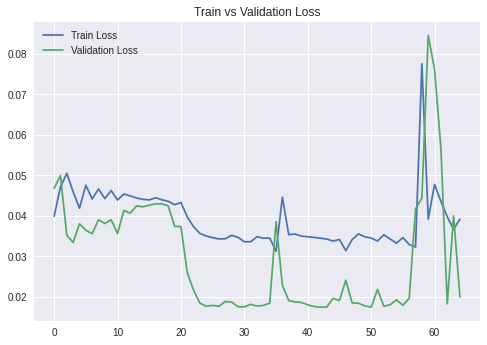

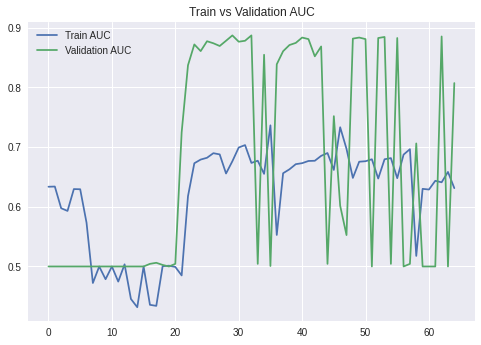


-------------------------------
Best metrics for validation set on Epoch 30:
Loss::      0.0175
AUC::       0.8871
Accuracy::  0.8250
F1::        0.7200
Precision:: 0.5625
Recall::    1.0000
Confusion Matrix:
 [[216  63]
 [  0  81]]
-------------------------------

Saving predictions from trained model...
Computing Predictions for train set.
dataset size: (2370, 14)
Computing Predictions for validation set.
dataset size: (360, 14)
Computing Predictions for test set.
dataset size: (372, 14)

--------------------------------------------------------------------
--------------------------------------------------------------------
Running sagittal - slice:22 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating final reference file for prepared images...
Loading untrained model...
VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/

Loss::      Train 0.0398      Validation 0.0464
AUC::       Train 0.6411      Validation 0.5000
Accuracy::  Train 0.6390      Validation 0.7750
F1::        Train 0.6554      Validation 0.0000
Precision:: Train 0.6093      Validation 0.0000
Recall::    Train 0.7091      Validation 0.0000
Validation Confusion Matrix:
 [[279   0]
 [ 81   0]]

Epoch 1 took 9.29 seconds
---------------------------------------------------------------------
Best validation AUC so far: 0.5000

---------------------------------------------------------------------
Running Epoch 2 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0466      Validation 0.0516
AUC::       Train 0.6334      Validation 0.5000
Accuracy::  Train 0.6301      Validation 0.7750
F1::        Train 0.6589      Validation 0.0000
Precision:: Train 0.5952      Validation 0.0000
Recall::    Train 0.7378      Validation 0.0000
Validation Confusion Matrix:
 [[279   0]
 [ 81   0]]

Epoch 2 took 9.26 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 3 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0520      Validation 0.0346
AUC::       Train 0.5798      Validation 0.5000
Accuracy::  Train 0.5728      Validation 0.7750
F1::        Train 0.6454      Validation 0.0000
Precision:: Train 0.5395      Validation 0.0000
Recall::    Train 0.8031      Validation 0.0000
Validation Confusion Matrix:
 [[279   0]
 [ 81   0]]

Epoch 3 took 9.43 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 4 of  100
Loss::      Train 0.0440      Validation 0.0349
AUC::       Train 0.5986      Validation 0.5000
Accuracy::  Train 0.5930      Validation 0.7750
F1::        Train 0.6482      Validation 0.0000
Precision:: Train 0.5574      Validation 0.0000
Recall::    Train 0.7744      Validation 0.0000
Validation Confusion Matrix:
 [[279   0]
 [ 81   0]]

Epoch 4 took 8.78 seconds
---------------------------------------------------------------------

----------------------------

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0454      Validation 0.0410
AUC::       Train 0.4202      Validation 0.5000
Accuracy::  Train 0.4294      Validation 0.7750
F1::        Train 0.1825      Validation 0.0000
Precision:: Train 0.2978      Validation 0.0000
Recall::    Train 0.1315      Validation 0.0000
Validation Confusion Matrix:
 [[279   0]
 [ 81   0]]

Epoch 19 took 9.31 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 20 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0439      Validation 0.0415
AUC::       Train 0.5000      Validation 0.5000
Accuracy::  Train 0.5158      Validation 0.7750
F1::        Train 0.0000      Validation 0.0000
Precision:: Train 0.0000      Validation 0.0000
Recall::    Train 0.0000      Validation 0.0000
Validation Confusion Matrix:
 [[279   0]
 [ 81   0]]

Epoch 20 took 9.28 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 21 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
AssertionError: can only test a child process
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0441      Validation 0.0418
AUC::       Train 0.4541      Validation 0.5000
Accuracy::  Train 0.4677      Validation 0.7750
F1::        Train 0.0381      Validation 0.0000
Precision:: Train 0.1524      Validation 0.0000
Recall::    Train 0.0218      Validation 0.0000
Validation Confusion Matrix:
 [[279   0]
 [ 81   0]]

Epoch 21 took 9.36 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 22 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0440      Validation 0.0423
AUC::       Train 0.4984      Validation 0.5000
Accuracy::  Train 0.5141      Validation 0.7750
F1::        Train 0.0000      Validation 0.0000
Precision:: Train 0.0000      Validation 0.0000
Recall::    Train 0.0000      Validation 0.0000
Validation Confusion Matrix:
 [[279   0]
 [ 81   0]]

Epoch 22 took 9.37 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 23 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0448      Validation 0.0426
AUC::       Train 0.4286      Validation 0.5000
Accuracy::  Train 0.4340      Validation 0.7750
F1::        Train 0.3061      Validation 0.0000
Precision:: Train 0.3766      Validation 0.0000
Recall::    Train 0.2578      Validation 0.0000
Validation Confusion Matrix:
 [[279   0]
 [ 81   0]]

Epoch 23 took 9.35 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 24 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0437      Validation 0.0424
AUC::       Train 0.5000      Validation 0.5000
Accuracy::  Train 0.5158      Validation 0.7750
F1::        Train 0.0000      Validation 0.0000
Precision:: Train 0.0000      Validation 0.0000
Recall::    Train 0.0000      Validation 0.0000
Validation Confusion Matrix:
 [[279   0]
 [ 81   0]]

Epoch 24 took 9.37 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 25 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0437      Validation 0.0425
AUC::       Train 0.5000      Validation 0.5000
Accuracy::  Train 0.5158      Validation 0.7750
F1::        Train 0.0000      Validation 0.0000
Precision:: Train 0.0000      Validation 0.0000
Recall::    Train 0.0000      Validation 0.0000
Validation Confusion Matrix:
 [[279   0]
 [ 81   0]]

Epoch 25 took 9.29 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 26 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
Traceback (most recent call last):
    if w.is_alive():
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0437      Validation 0.0429
AUC::       Train 0.5000      Validation 0.5000
Accuracy::  Train 0.5158      Validation 0.7750
F1::        Train 0.0000      Validation 0.0000
Precision:: Train 0.0000      Validation 0.0000
Recall::    Train 0.0000      Validation 0.0000
Validation Confusion Matrix:
 [[279   0]
 [ 81   0]]

Epoch 26 took 9.35 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 27 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
AssertionError: can only test a child process
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0436      Validation 0.0429
AUC::       Train 0.5004      Validation 0.5000
Accuracy::  Train 0.5162      Validation 0.7750
F1::        Train 0.0017      Validation 0.0000
Precision:: Train 1.0000      Validation 0.0000
Recall::    Train 0.0009      Validation 0.0000
Validation Confusion Matrix:
 [[279   0]
 [ 81   0]]

Epoch 27 took 9.33 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 28 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    assert self._parent_pid == os.getpid(), 'can only test a child process'
    self._shutdown_workers()
AssertionError: can only test a child process
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0436      Validation 0.0427
AUC::       Train 0.5004      Validation 0.5000
Accuracy::  Train 0.5162      Validation 0.7750
F1::        Train 0.0017      Validation 0.0000
Precision:: Train 1.0000      Validation 0.0000
Recall::    Train 0.0009      Validation 0.0000
Validation Confusion Matrix:
 [[279   0]
 [ 81   0]]

Epoch 28 took 9.32 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 29 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0438      Validation 0.0429
AUC::       Train 0.4469      Validation 0.5000
Accuracy::  Train 0.4601      Validation 0.7750
F1::        Train 0.0490      Validation 0.0000
Precision:: Train 0.1667      Validation 0.0000
Recall::    Train 0.0287      Validation 0.0000
Validation Confusion Matrix:
 [[279   0]
 [ 81   0]]

Epoch 29 took 9.40 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 30 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0435      Validation 0.0428
AUC::       Train 0.5004      Validation 0.5000
Accuracy::  Train 0.5162      Validation 0.7750
F1::        Train 0.0017      Validation 0.0000
Precision:: Train 1.0000      Validation 0.0000
Recall::    Train 0.0009      Validation 0.0000
Validation Confusion Matrix:
 [[279   0]
 [ 81   0]]

Epoch 30 took 10.10 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 31 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
    self._shutdown_workers()
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    if w.is_alive():
    self._shutdown_workers()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    assert self._parent_pid == os.getpid(), 'can only test a child process'

Loss::      Train 0.0434      Validation 0.0425
AUC::       Train 0.5004      Validation 0.5000
Accuracy::  Train 0.5162      Validation 0.7750
F1::        Train 0.0017      Validation 0.0000
Precision:: Train 1.0000      Validation 0.0000
Recall::    Train 0.0009      Validation 0.0000
Validation Confusion Matrix:
 [[279   0]
 [ 81   0]]

Epoch 31 took 10.00 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 32 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0436      Validation 0.0428
AUC::       Train 0.5004      Validation 0.5000
Accuracy::  Train 0.5162      Validation 0.7750
F1::        Train 0.0017      Validation 0.0000
Precision:: Train 1.0000      Validation 0.0000
Recall::    Train 0.0009      Validation 0.0000
Validation Confusion Matrix:
 [[279   0]
 [ 81   0]]

Epoch 32 took 9.98 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 33 of  100
Loss::      Train 0.0435      Validation 0.0429
AUC::       Train 0.5013      Validation 0.5000
Accuracy::  Train 0.5171      Validation 0.7750
F1::        Train 0.0052      Validation 0.0000
Precision:: Train 1.0000      Validation 0.0000
Recall::    Train 0.0026      Validation 0.0000
Validation Confusion Matrix:
 [[279   0]
 [ 81   0]]

Epoch 33 took 8.89 seconds
---------------------------------------------------------------------

-------------------------

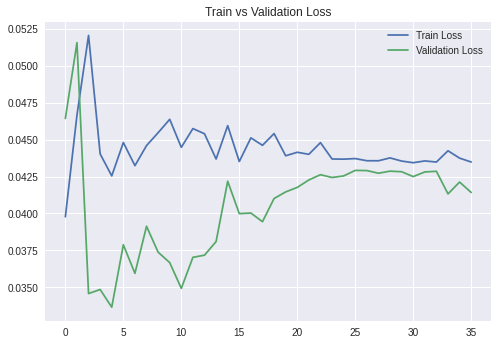

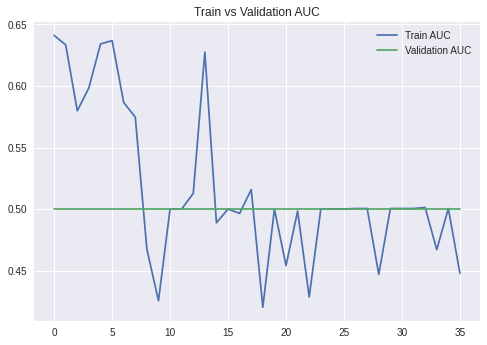


-------------------------------
Best metrics for validation set on Epoch 1:
Loss::      0.0464
AUC::       0.5000
Accuracy::  0.7750
F1::        0.0000
Precision:: 0.0000
Recall::    0.0000
Confusion Matrix:
 [[279   0]
 [ 81   0]]
-------------------------------

Saving predictions from trained model...
Computing Predictions for train set.
dataset size: (2371, 14)
Computing Predictions for validation set.
dataset size: (360, 14)
Computing Predictions for test set.
dataset size: (372, 14)

--------------------------------------------------------------------
--------------------------------------------------------------------
Running axial - slice:14 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating final reference file for prepared images...
Loading untrained model...
VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size

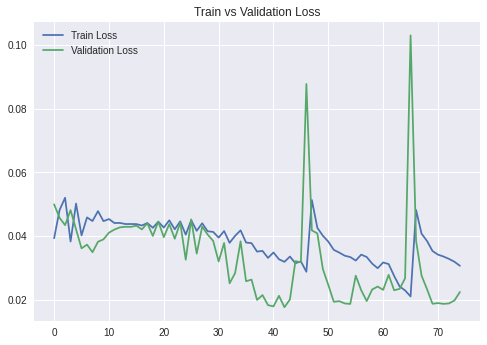

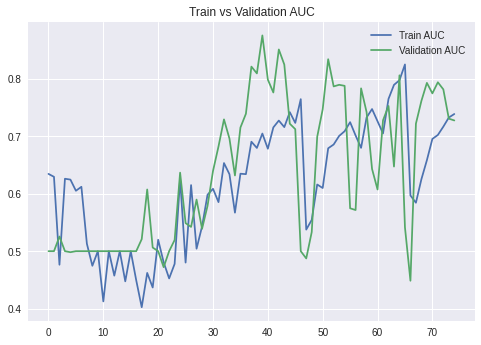


-------------------------------
Best metrics for validation set on Epoch 40:
Loss::      0.0183
AUC::       0.8754
Accuracy::  0.8273
F1::        0.7156
Precision:: 0.5693
Recall::    0.9630
Confusion Matrix:
 [[219  59]
 [  3  78]]
-------------------------------

Saving predictions from trained model...
Computing Predictions for train set.
dataset size: (2369, 14)
Computing Predictions for validation set.
dataset size: (359, 14)
Computing Predictions for test set.
dataset size: (372, 14)


SUBJECT IMAGE_DATA_ID ORIENTATION SLICE  VALID_IMAGE GROUP  \
3     941_S_4420       I294867     coronal    95         True  EMCI   
8     941_S_4255       I261061     coronal    95         True    CN   
9     941_S_4187       I258653     coronal    95         True  LMCI   
11    941_S_4066       I241396     coronal    95         True    CN   
12    941_S_4036       I236982     coronal    95         True  EMCI   
...          ...           ...         ...   ...          ...   ...   
3709  002_S_4213       I362924       axial    14         True    CN   
3721  002_S_0413       I649030       axial    14         True    CN   
3722  002_S_0413       I312701       axial    14         True    CN   
3723  002_S_0413       I424741       axial    14         True    CN   
3724  002_S_0413       I373133       axial    14         True    CN   

     MACRO_GROUP SEX  AGE                                         IMAGE_PATH  \
3              1   M   81  /content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...   
8              0   M   73  /content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...   
9              1   M   62  /content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...   
11             0   F   79  /content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...   
12             1   M   74  /content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...   
...          ...  ..  ...                                                ...   
3709           0   F   79  /content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...   
3721           0   F   85  /content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...   
3722           0   F   82  /content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...   
3723           0   F   84  /content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...   
3724           0   F   83  /content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...   

                                    ORIGINAL_IMAGE_PATH DATASET  MAIN_SLICE  \
3     /content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...   train          95   
8     /content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...   train          95   
9     /content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...   train          95   
11    /content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...   train          95   
12    /content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...   train          95   
...                                                 ...     ...         ...   
3709  /content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...    test          14   
3721  /content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...    test          14   
3722  /content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...    test          14   
3723  /content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...    test          14   
3724  /content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...    test          14   

        SLICE_ID  CNN_LABEL  CNN_SCORE orientation  slice     RUN_ID  
3     I294867_95      False   0.220086     coronal     95  coronal95  
8     I261061_95      False   0.351699     coronal     95  coronal95  
9     I258653_95      False   0.199946     coronal     95  coronal95  
11    I241396_95      False   0.281477     coronal     95  coronal95  
12    I236982_95      False   0.231006     coronal     95  coronal95  
...          ...        ...        ...         ...    ...        ...  
3709  I362924_14      False   0.010326       axial     14    axial14  
3721  I649030_14      False   0.016637       axial     14    axial14  
3722  I312701_14      False   0.004761       axial     14    axial14  
3723  I424741_14      False   0.011551       axial     14    axial14  
3724  I373133_14      False   0.011882       axial     14    axial14  

[9305 rows x 19 columns]

In [21]:
run_experiments_for_ensemble(orientation_and_slices = [('coronal',[95]),('sagittal',[22]),('axial',[14])],
                          model='vgg13_bn',
                          classes=['MCI','CN'],
                          mri_config = {
                            'num_samples':0,
                            'num_rotations':0,
                            'sampling_range':3,
                            'mri_reference':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/reference/PROCESSED_MRI_REFERENCE_ALL_ORIENTATIONS_20211030_2026.csv',
                            'output_path':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/mri/experiments/',
                            },
                          additional_experiment_params = {'lr':0.0001,
                            'batch_size':16,
                            'optimizer':'sgd',
                            'max_epochs':100,
                            'early_stop':35,
                            'prediction_threshold':0.5,
                            'momentum':0.99},
                          save_path = '/content/gdrive/MyDrive/Lucas_Thimoteo/data/PREDICTIONS_VGG13_BN_MCI.csv')


--------------------------------------------------------------------
--------------------------------------------------------------------
Running coronal - slice:95 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating final reference file for prepared images...
Loading untrained model...
VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_siz

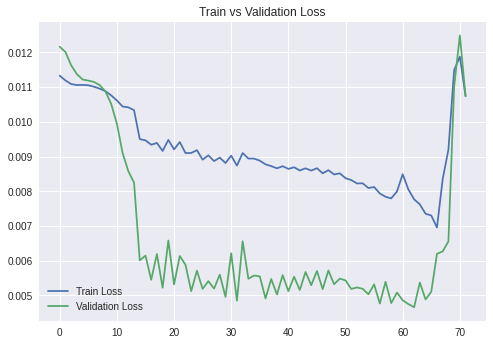

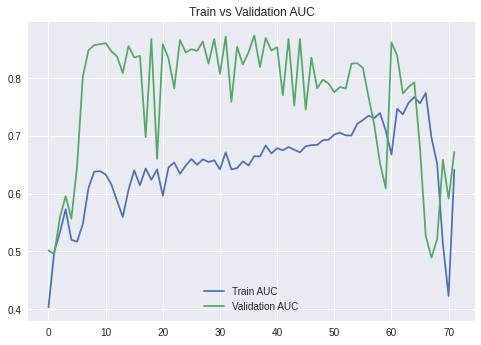


-------------------------------
Best metrics for validation set on Epoch 37:
Loss::      0.0049
AUC::       0.8746
Accuracy::  0.8056
F1::        0.6983
Precision:: 0.5364
Recall::    1.0000
Confusion Matrix:
 [[209  70]
 [  0  81]]
-------------------------------

Saving predictions from trained model...
Computing Predictions for train set.
dataset size: (2370, 14)
Computing Predictions for validation set.
dataset size: (360, 14)
Computing Predictions for test set.
dataset size: (372, 14)

--------------------------------------------------------------------
--------------------------------------------------------------------
Running sagittal - slice:22 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating final reference file for prepared images...
Loading untrained model...
VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Loss::      Train 0.0101      Validation 0.0095
AUC::       Train 0.5972      Validation 0.7151
Accuracy::  Train 0.5858      Validation 0.5583
F1::        Train 0.6910      Validation 0.5047
Precision:: Train 0.5409      Validation 0.3375
Recall::    Train 0.9564      Validation 1.0000
Validation Confusion Matrix:
 [[120 159]
 [  0  81]]

Epoch 28 took 6.12 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 29 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Loss::      Train 0.0098      Validation 0.0080
AUC::       Train 0.6144      Validation 0.7453
Accuracy::  Train 0.6048      Validation 0.6528
F1::        Train 0.6919      Validation 0.5421
Precision:: Train 0.5557      Validation 0.3854
Recall::    Train 0.9164      Validation 0.9136
Validation Confusion Matrix:
 [[161 118]
 [  7  74]]

Epoch 29 took 6.05 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 30 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Loss::      Train 0.0102      Validation 0.0089
AUC::       Train 0.6005      Validation 0.7228
Accuracy::  Train 0.5930      Validation 0.6111
F1::        Train 0.6662      Validation 0.5172
Precision:: Train 0.5525      Validation 0.3589
Recall::    Train 0.8389      Validation 0.9259
Validation Confusion Matrix:
 [[145 134]
 [  6  75]]

Epoch 30 took 6.06 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 31 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
Exception ignored in: <function _MultiProce

Loss::      Train 0.0099      Validation 0.0085
AUC::       Train 0.6112      Validation 0.7105
Accuracy::  Train 0.6031      Validation 0.6056
F1::        Train 0.6789      Validation 0.5069
Precision:: Train 0.5580      Validation 0.3527
Recall::    Train 0.8667      Validation 0.9012
Validation Confusion Matrix:
 [[145 134]
 [  8  73]]

Epoch 31 took 6.28 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 32 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0100      Validation 0.0085
AUC::       Train 0.6113      Validation 0.7565
Accuracy::  Train 0.6031      Validation 0.6361
F1::        Train 0.6798      Validation 0.5467
Precision:: Train 0.5578      Validation 0.3798
Recall::    Train 0.8702      Validation 0.9753
Validation Confusion Matrix:
 [[150 129]
 [  2  79]]

Epoch 32 took 6.23 seconds
---------------------------------------------------------------------
Best validation AUC so far: 0.7565

---------------------------------------------------------------------
Running Epoch 33 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0099      Validation 0.0086
AUC::       Train 0.6171      Validation 0.7344
Accuracy::  Train 0.6078      Validation 0.6222
F1::        Train 0.6925      Validation 0.5278
Precision:: Train 0.5581      Validation 0.3671
Recall::    Train 0.9120      Validation 0.9383
Validation Confusion Matrix:
 [[148 131]
 [  5  76]]

Epoch 33 took 6.29 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 34 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
Traceback (most recent call last):
    if w.is_alive():
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    self._shutdown_workers()
    assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
AssertionError: can only test a child process
  File "/usr/lib/pytho

Loss::      Train 0.0098      Validation 0.0083
AUC::       Train 0.6207      Validation 0.6908
Accuracy::  Train 0.6128      Validation 0.6361
F1::        Train 0.6848      Validation 0.4942
Precision:: Train 0.5652      Validation 0.3596
Recall::    Train 0.8685      Validation 0.7901
Validation Confusion Matrix:
 [[165 114]
 [ 17  64]]

Epoch 34 took 6.29 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 35 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0099      Validation 0.0085
AUC::       Train 0.6278      Validation 0.6826
Accuracy::  Train 0.6213      Validation 0.6167
F1::        Train 0.6811      Validation 0.4851
Precision:: Train 0.5749      Validation 0.3476
Recall::    Train 0.8354      Validation 0.8025
Validation Confusion Matrix:
 [[157 122]
 [ 16  65]]

Epoch 35 took 6.34 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 36 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0098      Validation 0.0084
AUC::       Train 0.6296      Validation 0.7013
Accuracy::  Train 0.6229      Validation 0.6389
F1::        Train 0.6834      Validation 0.5038
Precision:: Train 0.5758      Validation 0.3646
Recall::    Train 0.8406      Validation 0.8148
Validation Confusion Matrix:
 [[164 115]
 [ 15  66]]

Epoch 36 took 6.30 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 37 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    assert self._parent_pid == os.getpid(), 'can only test a child process'
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
AssertionError: can only test a child process
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0099      Validation 0.0085
AUC::       Train 0.6234      Validation 0.6681
Accuracy::  Train 0.6170      Validation 0.6417
F1::        Train 0.6755      Validation 0.4735
Precision:: Train 0.5727      Validation 0.3537
Recall::    Train 0.8232      Validation 0.7160
Validation Confusion Matrix:
 [[173 106]
 [ 23  58]]

Epoch 37 took 6.30 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 38 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
Exception ignored in: <function _MultiProce

Loss::      Train 0.0097      Validation 0.0083
AUC::       Train 0.6342      Validation 0.6645
Accuracy::  Train 0.6297      Validation 0.6361
F1::        Train 0.6699      Validation 0.4696
Precision:: Train 0.5893      Validation 0.3494
Recall::    Train 0.7761      Validation 0.7160
Validation Confusion Matrix:
 [[171 108]
 [ 23  58]]

Epoch 38 took 6.55 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 39 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0098      Validation 0.0085
AUC::       Train 0.6360      Validation 0.6434
Accuracy::  Train 0.6310      Validation 0.6306
F1::        Train 0.6765      Validation 0.4481
Precision:: Train 0.5877      Validation 0.3375
Recall::    Train 0.7970      Validation 0.6667
Validation Confusion Matrix:
 [[173 106]
 [ 27  54]]

Epoch 39 took 6.37 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 40 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/

Loss::      Train 0.0097      Validation 0.0083
AUC::       Train 0.6280      Validation 0.6754
Accuracy::  Train 0.6238      Validation 0.6667
F1::        Train 0.6616      Validation 0.4828
Precision:: Train 0.5860      Validation 0.3709
Recall::    Train 0.7596      Validation 0.6914
Validation Confusion Matrix:
 [[184  95]
 [ 25  56]]

Epoch 40 took 6.42 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 41 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0097      Validation 0.0084
AUC::       Train 0.6406      Validation 0.6378
Accuracy::  Train 0.6360      Validation 0.6694
F1::        Train 0.6767      Validation 0.4413
Precision:: Train 0.5937      Validation 0.3561
Recall::    Train 0.7866      Validation 0.5802
Validation Confusion Matrix:
 [[194  85]
 [ 34  47]]

Epoch 41 took 6.50 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 42 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
Exception ignored in: <function _MultiProce

Loss::      Train 0.0096      Validation 0.0082
AUC::       Train 0.6345      Validation 0.6808
Accuracy::  Train 0.6318      Validation 0.6750
F1::        Train 0.6540      Validation 0.4891
Precision:: Train 0.6000      Validation 0.3784
Recall::    Train 0.7186      Validation 0.6914
Validation Confusion Matrix:
 [[187  92]
 [ 25  56]]

Epoch 42 took 6.55 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 43 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0098      Validation 0.0086
AUC::       Train 0.6493      Validation 0.5996
Accuracy::  Train 0.6453      Validation 0.6306
F1::        Train 0.6791      Validation 0.3982
Precision:: Train 0.6042      Validation 0.3143
Recall::    Train 0.7753      Validation 0.5432
Validation Confusion Matrix:
 [[183  96]
 [ 37  44]]

Epoch 43 took 6.49 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 44 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0095      Validation 0.0080
AUC::       Train 0.6357      Validation 0.7021
Accuracy::  Train 0.6335      Validation 0.6944
F1::        Train 0.6506      Validation 0.5133
Precision:: Train 0.6042      Validation 0.4000
Recall::    Train 0.7047      Validation 0.7160
Validation Confusion Matrix:
 [[192  87]
 [ 23  58]]

Epoch 44 took 7.13 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 45 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/d

Loss::      Train 0.0097      Validation 0.0086
AUC::       Train 0.6481      Validation 0.6426
Accuracy::  Train 0.6440      Validation 0.6972
F1::        Train 0.6784      Validation 0.4467
Precision:: Train 0.6030      Validation 0.3793
Recall::    Train 0.7753      Validation 0.5432
Validation Confusion Matrix:
 [[207  72]
 [ 37  44]]

Epoch 45 took 6.68 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 46 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
Traceback (most recent call last):
    self._shutdown_workers()
  File "/usr/local/lib/python3

Loss::      Train 0.0094      Validation 0.0080
AUC::       Train 0.6416      Validation 0.6641
Accuracy::  Train 0.6402      Validation 0.6694
F1::        Train 0.6485      Validation 0.4711
Precision:: Train 0.6153      Validation 0.3681
Recall::    Train 0.6855      Validation 0.6543
Validation Confusion Matrix:
 [[188  91]
 [ 28  53]]

Epoch 46 took 7.14 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 47 of  100
Loss::      Train 0.0098      Validation 0.0087
AUC::       Train 0.6413      Validation 0.6197
Accuracy::  Train 0.6369      Validation 0.6889
F1::        Train 0.6760      Validation 0.4167
Precision:: Train 0.5951      Validation 0.3604
Recall::    Train 0.7822      Validation 0.4938
Validation Confusion Matrix:
 [[208  71]
 [ 41  40]]

Epoch 47 took 6.10 seconds
---------------------------------------------------------------------

-------------------------

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Loss::      Train 0.0086      Validation 0.0068
AUC::       Train 0.7084      Validation 0.6458
Accuracy::  Train 0.7077      Validation 0.7972
F1::        Train 0.7075      Validation 0.4511
Precision:: Train 0.6863      Validation 0.5769
Recall::    Train 0.7300      Validation 0.3704
Validation Confusion Matrix:
 [[257  22]
 [ 51  30]]

Epoch 67 took 6.13 seconds
---------------------------------------------------------------------

Exiting training... It hit early stopping criteria of: 35 epochs
Saving model at: 


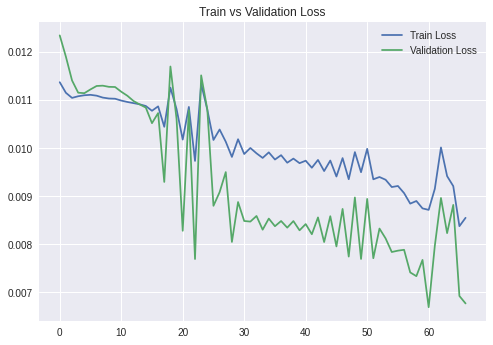

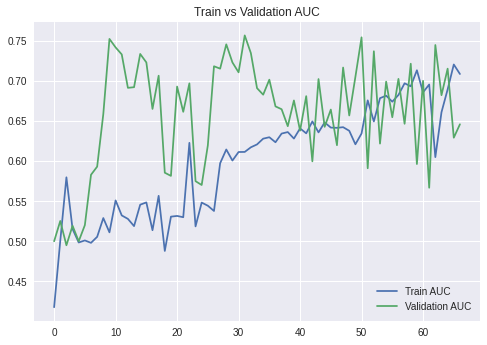


-------------------------------
Best metrics for validation set on Epoch 32:
Loss::      0.0085
AUC::       0.7565
Accuracy::  0.6361
F1::        0.5467
Precision:: 0.3798
Recall::    0.9753
Confusion Matrix:
 [[150 129]
 [  2  79]]
-------------------------------

Saving predictions from trained model...
Computing Predictions for train set.
dataset size: (2371, 14)
Computing Predictions for validation set.
dataset size: (360, 14)
Computing Predictions for test set.
dataset size: (372, 14)

--------------------------------------------------------------------
--------------------------------------------------------------------
Running axial - slice:14 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating final reference file for prepared images...
Loading untrained model...
VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_siz

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
AssertionError: can only test a child process
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0113      Validation 0.0122
AUC::       Train 0.4422      Validation 0.4956
Accuracy::  Train 0.4348      Validation 0.2256
F1::        Train 0.5339      Validation 0.3653
Precision:: Train 0.4441      Validation 0.2241
Recall::    Train 0.6693      Validation 0.9877
Validation Confusion Matrix:
 [[  1 277]
 [  1  80]]

Epoch 1 took 6.48 seconds
---------------------------------------------------------------------
Best validation AUC so far: 0.4956

---------------------------------------------------------------------
Running Epoch 2 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
    if w.is_alive():
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    assert self._parent_pid == os.getpid(), 'can only test a child process'
    if w.is_alive():
AssertionError: can only test a child process
  File "/usr/lib/pytho

Loss::      Train 0.0111      Validation 0.0116
AUC::       Train 0.5081      Validation 0.5168
Accuracy::  Train 0.4960      Validation 0.4345
F1::        Train 0.6287      Validation 0.3473
Precision:: Train 0.4884      Validation 0.2348
Recall::    Train 0.8822      Validation 0.6667
Validation Confusion Matrix:
 [[102 176]
 [ 27  54]]

Epoch 2 took 6.55 seconds
---------------------------------------------------------------------
Best validation AUC so far: 0.5168

---------------------------------------------------------------------
Running Epoch 3 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3

Loss::      Train 0.0111      Validation 0.0112
AUC::       Train 0.5276      Validation 0.4982
Accuracy::  Train 0.5390      Validation 0.7716
F1::        Train 0.2691      Validation 0.0000
Precision:: Train 0.5776      Validation 0.0000
Recall::    Train 0.1754      Validation 0.0000
Validation Confusion Matrix:
 [[277   1]
 [ 81   0]]

Epoch 3 took 6.60 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 4 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0111      Validation 0.0110
AUC::       Train 0.4996      Validation 0.5000
Accuracy::  Train 0.5158      Validation 0.7744
F1::        Train 0.0000      Validation 0.0000
Precision:: Train 0.0000      Validation 0.0000
Recall::    Train 0.0000      Validation 0.0000
Validation Confusion Matrix:
 [[278   0]
 [ 81   0]]

Epoch 4 took 6.63 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 5 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/

Loss::      Train 0.0111      Validation 0.0110
AUC::       Train 0.5000      Validation 0.5000
Accuracy::  Train 0.5163      Validation 0.7744
F1::        Train 0.0000      Validation 0.0000
Precision:: Train 0.0000      Validation 0.0000
Recall::    Train 0.0000      Validation 0.0000
Validation Confusion Matrix:
 [[278   0]
 [ 81   0]]

Epoch 5 took 7.24 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 6 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
    self._shutdown_workers()
Traceback (most recent call last):
  File "/usr/local/lib/python3

Loss::      Train 0.0111      Validation 0.0110
AUC::       Train 0.5000      Validation 0.5000
Accuracy::  Train 0.5163      Validation 0.7744
F1::        Train 0.0000      Validation 0.0000
Precision:: Train 0.0000      Validation 0.0000
Recall::    Train 0.0000      Validation 0.0000
Validation Confusion Matrix:
 [[278   0]
 [ 81   0]]

Epoch 6 took 7.19 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 7 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
Traceback (most recent call last):
    self._shutdown_workers()
  File "/usr/local/lib/python3

Loss::      Train 0.0111      Validation 0.0111
AUC::       Train 0.5000      Validation 0.5000
Accuracy::  Train 0.5163      Validation 0.7744
F1::        Train 0.0000      Validation 0.0000
Precision:: Train 0.0000      Validation 0.0000
Recall::    Train 0.0000      Validation 0.0000
Validation Confusion Matrix:
 [[278   0]
 [ 81   0]]

Epoch 7 took 7.16 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 8 of  100
Loss::      Train 0.0111      Validation 0.0112
AUC::       Train 0.5000      Validation 0.5000
Accuracy::  Train 0.5163      Validation 0.7744
F1::        Train 0.0000      Validation 0.0000
Precision:: Train 0.0000      Validation 0.0000
Recall::    Train 0.0000      Validation 0.0000
Validation Confusion Matrix:
 [[278   0]
 [ 81   0]]

Epoch 8 took 6.08 seconds
---------------------------------------------------------------------

----------------------------

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Loss::      Train 0.0110      Validation 0.0109
AUC::       Train 0.5464      Validation 0.5386
Accuracy::  Train 0.5572      Validation 0.7799
F1::        Train 0.3184      Validation 0.1684
Precision:: Train 0.6234      Validation 0.5714
Recall::    Train 0.2138      Validation 0.0988
Validation Confusion Matrix:
 [[272   6]
 [ 73   8]]

Epoch 28 took 6.10 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 29 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Loss::      Train 0.0109      Validation 0.0108
AUC::       Train 0.5404      Validation 0.5435
Accuracy::  Train 0.5513      Validation 0.7604
F1::        Train 0.3075      Validation 0.2182
Precision:: Train 0.6067      Validation 0.4138
Recall::    Train 0.2059      Validation 0.1481
Validation Confusion Matrix:
 [[261  17]
 [ 69  12]]

Epoch 29 took 6.04 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 30 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Loss::      Train 0.0110      Validation 0.0108
AUC::       Train 0.5546      Validation 0.5800
Accuracy::  Train 0.5623      Validation 0.7493
F1::        Train 0.4131      Validation 0.3284
Precision:: Train 0.5878      Validation 0.4151
Recall::    Train 0.3185      Validation 0.2716
Validation Confusion Matrix:
 [[247  31]
 [ 59  22]]

Epoch 30 took 6.06 seconds
---------------------------------------------------------------------
Best validation AUC so far: 0.5800

---------------------------------------------------------------------
Running Epoch 31 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0109      Validation 0.0107
AUC::       Train 0.5537      Validation 0.6155
Accuracy::  Train 0.5606      Validation 0.7772
F1::        Train 0.4302      Validation 0.3939
Precision:: Train 0.5771      Validation 0.5098
Recall::    Train 0.3429      Validation 0.3210
Validation Confusion Matrix:
 [[253  25]
 [ 55  26]]

Epoch 31 took 6.23 seconds
---------------------------------------------------------------------
Best validation AUC so far: 0.6155

---------------------------------------------------------------------
Running Epoch 32 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0109      Validation 0.0107
AUC::       Train 0.5526      Validation 0.5860
Accuracy::  Train 0.5564      Validation 0.7382
F1::        Train 0.4881      Validation 0.3472
Precision:: Train 0.5524      Validation 0.3968
Recall::    Train 0.4372      Validation 0.3086
Validation Confusion Matrix:
 [[240  38]
 [ 56  25]]

Epoch 32 took 6.29 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 33 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0108      Validation 0.0105
AUC::       Train 0.5720      Validation 0.6112
Accuracy::  Train 0.5766      Validation 0.7772
F1::        Train 0.4962      Validation 0.3846
Precision:: Train 0.5846      Validation 0.5102
Recall::    Train 0.4311      Validation 0.3086
Validation Confusion Matrix:
 [[254  24]
 [ 56  25]]

Epoch 33 took 6.29 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 34 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
Exception ignored in: <function _MultiProce

Loss::      Train 0.0109      Validation 0.0105
AUC::       Train 0.5657      Validation 0.6493
Accuracy::  Train 0.5669      Validation 0.7549
F1::        Train 0.5420      Validation 0.4568
Precision:: Train 0.5548      Validation 0.4568
Recall::    Train 0.5297      Validation 0.4568
Validation Confusion Matrix:
 [[234  44]
 [ 44  37]]

Epoch 34 took 6.33 seconds
---------------------------------------------------------------------
Best validation AUC so far: 0.6493

---------------------------------------------------------------------
Running Epoch 35 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
    if w.is_alive():
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    self._shutdown_workers()
    assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
AssertionError: can only test a child process
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0107      Validation 0.0101
AUC::       Train 0.5821      Validation 0.5908
Accuracy::  Train 0.5859      Validation 0.7660
F1::        Train 0.5203      Validation 0.3438
Precision:: Train 0.5918      Validation 0.4681
Recall::    Train 0.4642      Validation 0.2716
Validation Confusion Matrix:
 [[253  25]
 [ 59  22]]

Epoch 35 took 6.33 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 36 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0108      Validation 0.0103
AUC::       Train 0.5714      Validation 0.6403
Accuracy::  Train 0.5711      Validation 0.7409
F1::        Train 0.5669      Validation 0.4431
Precision:: Train 0.5542      Validation 0.4302
Recall::    Train 0.5803      Validation 0.4568
Validation Confusion Matrix:
 [[229  49]
 [ 44  37]]

Epoch 36 took 6.35 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 37 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0106      Validation 0.0096
AUC::       Train 0.5860      Validation 0.6191
Accuracy::  Train 0.5880      Validation 0.7827
F1::        Train 0.5519      Validation 0.4000
Precision:: Train 0.5824      Validation 0.5306
Recall::    Train 0.5244      Validation 0.3210
Validation Confusion Matrix:
 [[255  23]
 [ 55  26]]

Epoch 37 took 6.40 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 38 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0108      Validation 0.0099
AUC::       Train 0.5802      Validation 0.6598
Accuracy::  Train 0.5804      Validation 0.7577
F1::        Train 0.5693      Validation 0.4727
Precision:: Train 0.5654      Validation 0.4643
Recall::    Train 0.5733      Validation 0.4815
Validation Confusion Matrix:
 [[233  45]
 [ 42  39]]

Epoch 38 took 6.45 seconds
---------------------------------------------------------------------
Best validation AUC so far: 0.6598

---------------------------------------------------------------------
Running Epoch 39 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0105      Validation 0.0093
AUC::       Train 0.6063      Validation 0.6508
Accuracy::  Train 0.6066      Validation 0.7911
F1::        Train 0.5955      Validation 0.4604
Precision:: Train 0.5924      Validation 0.5517
Recall::    Train 0.5986      Validation 0.3951
Validation Confusion Matrix:
 [[252  26]
 [ 49  32]]

Epoch 39 took 6.38 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 40 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloa

Loss::      Train 0.0106      Validation 0.0095
AUC::       Train 0.5982      Validation 0.6724
Accuracy::  Train 0.5981      Validation 0.7772
F1::        Train 0.5911      Validation 0.4937
Precision:: Train 0.5821      Validation 0.5065
Recall::    Train 0.6003      Validation 0.4815
Validation Confusion Matrix:
 [[240  38]
 [ 42  39]]

Epoch 40 took 6.57 seconds
---------------------------------------------------------------------
Best validation AUC so far: 0.6724

---------------------------------------------------------------------
Running Epoch 41 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0104      Validation 0.0090
AUC::       Train 0.6147      Validation 0.6711
Accuracy::  Train 0.6146      Validation 0.8022
F1::        Train 0.6076      Validation 0.4965
Precision:: Train 0.5986      Validation 0.5833
Recall::    Train 0.6169      Validation 0.4321
Validation Confusion Matrix:
 [[253  25]
 [ 46  35]]

Epoch 41 took 6.68 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 42 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0105      Validation 0.0091
AUC::       Train 0.6066      Validation 0.6832
Accuracy::  Train 0.6062      Validation 0.7939
F1::        Train 0.6038      Validation 0.5132
Precision:: Train 0.5881      Validation 0.5493
Recall::    Train 0.6204      Validation 0.4815
Validation Confusion Matrix:
 [[246  32]
 [ 42  39]]

Epoch 42 took 6.57 seconds
---------------------------------------------------------------------
Best validation AUC so far: 0.6832

---------------------------------------------------------------------
Running Epoch 43 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/

Loss::      Train 0.0103      Validation 0.0088
AUC::       Train 0.6238      Validation 0.6639
Accuracy::  Train 0.6230      Validation 0.7911
F1::        Train 0.6237      Validation 0.4828
Precision:: Train 0.6031      Validation 0.5469
Recall::    Train 0.6457      Validation 0.4321
Validation Confusion Matrix:
 [[249  29]
 [ 46  35]]

Epoch 43 took 7.20 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 44 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
AssertionError: can only test a child process
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/d

Loss::      Train 0.0103      Validation 0.0089
AUC::       Train 0.6243      Validation 0.6973
Accuracy::  Train 0.6235      Validation 0.8022
F1::        Train 0.6255      Validation 0.5359
Precision:: Train 0.6028      Validation 0.5694
Recall::    Train 0.6501      Validation 0.5062
Validation Confusion Matrix:
 [[247  31]
 [ 40  41]]

Epoch 44 took 6.75 seconds
---------------------------------------------------------------------
Best validation AUC so far: 0.6973

---------------------------------------------------------------------
Running Epoch 45 of  100
Loss::      Train 0.0103      Validation 0.0088
AUC::       Train 0.6297      Validation 0.6842
Accuracy::  Train 0.6290      Validation 0.8022
F1::        Train 0.6293      Validation 0.5170
Precision:: Train 0.6090      Validation 0.5758
Recall::    Train 0.6510      Validation 0.4691
Validation Confusion Matrix:
 [[250  28]
 [ 43  38]]

Epoch 45 took 6.09 seconds
-------------------------------------------------------------

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Loss::      Train 0.0097      Validation 0.0083
AUC::       Train 0.6646      Validation 0.7102
Accuracy::  Train 0.6674      Validation 0.7883
F1::        Train 0.6280      Validation 0.5476
Precision:: Train 0.6842      Validation 0.5287
Recall::    Train 0.5803      Validation 0.5679
Validation Confusion Matrix:
 [[237  41]
 [ 35  46]]

Epoch 63 took 6.07 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 64 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Loss::      Train 0.0092      Validation 0.0075
AUC::       Train 0.7008      Validation 0.6868
Accuracy::  Train 0.7020      Validation 0.7994
F1::        Train 0.6834      Validation 0.5200
Precision:: Train 0.7030      Validation 0.5652
Recall::    Train 0.6649      Validation 0.4815
Validation Confusion Matrix:
 [[248  30]
 [ 42  39]]

Epoch 64 took 6.11 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 65 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Loss::      Train 0.0089      Validation 0.0076
AUC::       Train 0.7064      Validation 0.6474
Accuracy::  Train 0.7062      Validation 0.7994
F1::        Train 0.7008      Validation 0.4545
Precision:: Train 0.6907      Validation 0.5882
Recall::    Train 0.7112      Validation 0.3704
Validation Confusion Matrix:
 [[257  21]
 [ 51  30]]

Epoch 65 took 6.09 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 66 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
    if w.is_alive():
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child

Loss::      Train 0.0092      Validation 0.0078
AUC::       Train 0.6999      Validation 0.6822
Accuracy::  Train 0.7011      Validation 0.7855
F1::        Train 0.6817      Validation 0.5096
Precision:: Train 0.7032      Validation 0.5263
Recall::    Train 0.6614      Validation 0.4938
Validation Confusion Matrix:
 [[242  36]
 [ 41  40]]

Epoch 66 took 6.34 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 67 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0089      Validation 0.0074
AUC::       Train 0.7144      Validation 0.7210
Accuracy::  Train 0.7168      Validation 0.8050
F1::        Train 0.6866      Validation 0.5679
Precision:: Train 0.7387      Validation 0.5679
Recall::    Train 0.6414      Validation 0.5679
Validation Confusion Matrix:
 [[243  35]
 [ 35  46]]

Epoch 67 took 6.35 seconds
---------------------------------------------------------------------
Best validation AUC so far: 0.7210

---------------------------------------------------------------------
Running Epoch 68 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0084      Validation 0.0073
AUC::       Train 0.7305      Validation 0.6351
Accuracy::  Train 0.7311      Validation 0.7939
F1::        Train 0.7188      Validation 0.4308
Precision:: Train 0.7274      Validation 0.5714
Recall::    Train 0.7103      Validation 0.3457
Validation Confusion Matrix:
 [[257  21]
 [ 53  28]]

Epoch 68 took 6.32 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 69 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
Traceback (most recent call last):
    if w.is_alive():
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0084      Validation 0.0072
AUC::       Train 0.7373      Validation 0.6379
Accuracy::  Train 0.7379      Validation 0.8050
F1::        Train 0.7263      Validation 0.4355
Precision:: Train 0.7337      Validation 0.6279
Recall::    Train 0.7190      Validation 0.3333
Validation Confusion Matrix:
 [[262  16]
 [ 54  27]]

Epoch 69 took 6.33 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 70 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
Exception ignored in: <function _MultiProce

Loss::      Train 0.0088      Validation 0.0073
AUC::       Train 0.7069      Validation 0.6984
Accuracy::  Train 0.7083      Validation 0.8106
F1::        Train 0.6872      Validation 0.5405
Precision:: Train 0.7140      Validation 0.5970
Recall::    Train 0.6623      Validation 0.4938
Validation Confusion Matrix:
 [[251  27]
 [ 41  40]]

Epoch 70 took 6.41 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 71 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/d

Loss::      Train 0.0083      Validation 0.0075
AUC::       Train 0.7331      Validation 0.7058
Accuracy::  Train 0.7353      Validation 0.7883
F1::        Train 0.7088      Validation 0.5422
Precision:: Train 0.7577      Validation 0.5294
Recall::    Train 0.6658      Validation 0.5556
Validation Confusion Matrix:
 [[238  40]
 [ 36  45]]

Epoch 71 took 6.34 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 72 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0078      Validation 0.0071
AUC::       Train 0.7611      Validation 0.6667
Accuracy::  Train 0.7619      Validation 0.8022
F1::        Train 0.7493      Validation 0.4892
Precision:: Train 0.7636      Validation 0.5862
Recall::    Train 0.7356      Validation 0.4198
Validation Confusion Matrix:
 [[254  24]
 [ 47  34]]

Epoch 72 took 6.31 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 73 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3

Loss::      Train 0.0075      Validation 0.0071
AUC::       Train 0.7739      Validation 0.6248
Accuracy::  Train 0.7746      Validation 0.8050
F1::        Train 0.7637      Validation 0.4068
Precision:: Train 0.7747      Validation 0.6486
Recall::    Train 0.7531      Validation 0.2963
Validation Confusion Matrix:
 [[265  13]
 [ 57  24]]

Epoch 73 took 6.37 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 74 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0079      Validation 0.0071
AUC::       Train 0.7534      Validation 0.5625
Accuracy::  Train 0.7539      Validation 0.7967
F1::        Train 0.7440      Validation 0.2316
Precision:: Train 0.7489      Validation 0.7857
Recall::    Train 0.7391      Validation 0.1358
Validation Confusion Matrix:
 [[275   3]
 [ 70  11]]

Epoch 74 took 6.51 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 75 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0095      Validation 0.0073
AUC::       Train 0.6867      Validation 0.6773
Accuracy::  Train 0.6881      Validation 0.8050
F1::        Train 0.6667      Validation 0.5070
Precision:: Train 0.6900      Validation 0.5902
Recall::    Train 0.6449      Validation 0.4444
Validation Confusion Matrix:
 [[253  25]
 [ 45  36]]

Epoch 75 took 6.52 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 76 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/

Loss::      Train 0.0090      Validation 0.0083
AUC::       Train 0.7146      Validation 0.7280
Accuracy::  Train 0.7180      Validation 0.8022
F1::        Train 0.6764      Validation 0.5749
Precision:: Train 0.7603      Validation 0.5581
Recall::    Train 0.6091      Validation 0.5926
Validation Confusion Matrix:
 [[240  38]
 [ 33  48]]

Epoch 76 took 6.51 seconds
---------------------------------------------------------------------
Best validation AUC so far: 0.7280

---------------------------------------------------------------------
Running Epoch 77 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0081      Validation 0.0071
AUC::       Train 0.7542      Validation 0.6299
Accuracy::  Train 0.7543      Validation 0.7994
F1::        Train 0.7474      Validation 0.4194
Precision:: Train 0.7435      Validation 0.6047
Recall::    Train 0.7513      Validation 0.3210
Validation Confusion Matrix:
 [[261  17]
 [ 55  26]]

Epoch 77 took 6.58 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 78 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
Traceback (most recent call last):
  File "/usr/local/lib/python3

Loss::      Train 0.0079      Validation 0.0072
AUC::       Train 0.7558      Validation 0.6178
Accuracy::  Train 0.7564      Validation 0.8078
F1::        Train 0.7450      Validation 0.3894
Precision:: Train 0.7547      Validation 0.6875
Recall::    Train 0.7356      Validation 0.2716
Validation Confusion Matrix:
 [[268  10]
 [ 59  22]]

Epoch 78 took 6.58 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 79 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/d

Loss::      Train 0.0087      Validation 0.0070
AUC::       Train 0.7177      Validation 0.6381
Accuracy::  Train 0.7184      Validation 0.8189
F1::        Train 0.7045      Validation 0.4348
Precision:: Train 0.7156      Validation 0.7353
Recall::    Train 0.6937      Validation 0.3086
Validation Confusion Matrix:
 [[269   9]
 [ 56  25]]

Epoch 79 took 7.13 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 80 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/

Loss::      Train 0.0088      Validation 0.0078
AUC::       Train 0.7069      Validation 0.7190
Accuracy::  Train 0.7096      Validation 0.7883
F1::        Train 0.6749      Validation 0.5581
Precision:: Train 0.7361      Validation 0.5275
Recall::    Train 0.6230      Validation 0.5926
Validation Confusion Matrix:
 [[235  43]
 [ 33  48]]

Epoch 80 took 7.22 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 81 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/

Loss::      Train 0.0078      Validation 0.0073
AUC::       Train 0.7698      Validation 0.7094
Accuracy::  Train 0.7721      Validation 0.7939
F1::        Train 0.7479      Validation 0.5488
Precision:: Train 0.8042      Validation 0.5422
Recall::    Train 0.6990      Validation 0.5556
Validation Confusion Matrix:
 [[240  38]
 [ 36  45]]

Epoch 81 took 7.26 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 82 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
Exception ignored in: 

Loss::      Train 0.0071      Validation 0.0070
AUC::       Train 0.7938      Validation 0.6842
Accuracy::  Train 0.7949      Validation 0.8022
F1::        Train 0.7823      Validation 0.5170
Precision:: Train 0.8039      Validation 0.5758
Recall::    Train 0.7618      Validation 0.4691
Validation Confusion Matrix:
 [[250  28]
 [ 43  38]]

Epoch 82 took 6.78 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 83 of  100
Loss::      Train 0.0066      Validation 0.0071
AUC::       Train 0.8084      Validation 0.6279
Accuracy::  Train 0.8092      Validation 0.7827
F1::        Train 0.7991      Validation 0.4179
Precision:: Train 0.8143      Validation 0.5283
Recall::    Train 0.7845      Validation 0.3457
Validation Confusion Matrix:
 [[253  25]
 [ 53  28]]

Epoch 83 took 6.09 seconds
---------------------------------------------------------------------

-------------------------

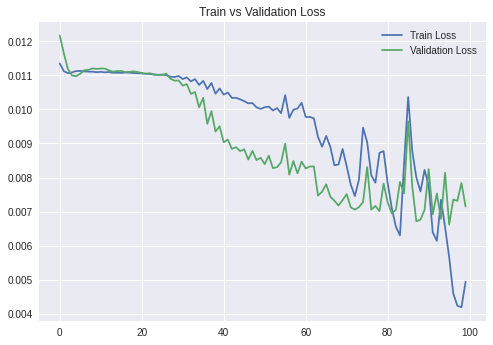

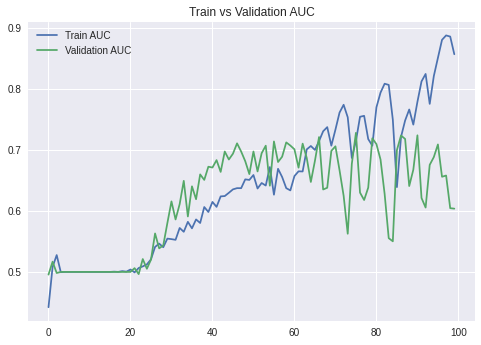


-------------------------------
Best metrics for validation set on Epoch 76:
Loss::      0.0083
AUC::       0.7280
Accuracy::  0.8022
F1::        0.5749
Precision:: 0.5581
Recall::    0.5926
Confusion Matrix:
 [[240  38]
 [ 33  48]]
-------------------------------

Saving predictions from trained model...
Computing Predictions for train set.
dataset size: (2369, 14)
Computing Predictions for validation set.
dataset size: (359, 14)
Computing Predictions for test set.
dataset size: (372, 14)


SUBJECT IMAGE_DATA_ID ORIENTATION SLICE  VALID_IMAGE GROUP  \
3     941_S_4420       I294867     coronal    95         True  EMCI   
8     941_S_4255       I261061     coronal    95         True    CN   
9     941_S_4187       I258653     coronal    95         True  LMCI   
11    941_S_4066       I241396     coronal    95         True    CN   
12    941_S_4036       I236982     coronal    95         True  EMCI   
...          ...           ...         ...   ...          ...   ...   
3709  002_S_4213       I362924       axial    14         True    CN   
3721  002_S_0413       I649030       axial    14         True    CN   
3722  002_S_0413       I312701       axial    14         True    CN   
3723  002_S_0413       I424741       axial    14         True    CN   
3724  002_S_0413       I373133       axial    14         True    CN   

     MACRO_GROUP SEX  AGE                                         IMAGE_PATH  \
3              1   M   81  /content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...   
8              0   M   73  /content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...   
9              1   M   62  /content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...   
11             0   F   79  /content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...   
12             1   M   74  /content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...   
...          ...  ..  ...                                                ...   
3709           0   F   79  /content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...   
3721           0   F   85  /content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...   
3722           0   F   82  /content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...   
3723           0   F   84  /content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...   
3724           0   F   83  /content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...   

                                    ORIGINAL_IMAGE_PATH DATASET  MAIN_SLICE  \
3     /content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...   train          95   
8     /content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...   train          95   
9     /content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...   train          95   
11    /content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...   train          95   
12    /content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...   train          95   
...                                                 ...     ...         ...   
3709  /content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...    test          14   
3721  /content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...    test          14   
3722  /content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...    test          14   
3723  /content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...    test          14   
3724  /content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...    test          14   

        SLICE_ID  CNN_LABEL  CNN_SCORE orientation  slice     RUN_ID  
3     I294867_95      False   0.494311     coronal     95  coronal95  
8     I261061_95      False   0.494326     coronal     95  coronal95  
9     I258653_95      False   0.497874     coronal     95  coronal95  
11    I241396_95      False   0.499507     coronal     95  coronal95  
12    I236982_95      False   0.488465     coronal     95  coronal95  
...          ...        ...        ...         ...    ...        ...  
3709  I362924_14      False   0.021402       axial     14    axial14  
3721  I649030_14      False   0.007382       axial     14    axial14  
3722  I312701_14      False   0.007841       axial     14    axial14  
3723  I424741_14      False   0.007568       axial     14    axial14  
3724  I373133_14      False   0.007074       axial     14    axial14  

[9305 rows x 19 columns]

In [25]:
run_experiments_for_ensemble(orientation_and_slices = [('coronal',[95]),('sagittal',[22]),('axial',[14])],
                          model='vgg13',
                          classes=['MCI','CN'],
                          mri_config = {
                            'num_samples':0,
                            'num_rotations':0,
                            'sampling_range':3,
                            'mri_reference':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/reference/PROCESSED_MRI_REFERENCE_ALL_ORIENTATIONS_20211030_2026.csv',
                            'output_path':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/mri/experiments/',
                            },
                          additional_experiment_params = {'lr':0.0001,
                            'batch_size':64,
                            'optimizer':'sgd',
                            'max_epochs':100,
                            'early_stop':35,
                            'prediction_threshold':0.5,
                            'momentum':0.99},
                          save_path = '/content/gdrive/MyDrive/Lucas_Thimoteo/data/PREDICTIONS_VGG13_BN_MCI2.csv')


--------------------------------------------------------------------
--------------------------------------------------------------------
Running coronal - slice:95 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating final reference file for prepared images...
Loading untrained model...
VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_siz

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/

Loss::      Train 0.0112      Validation 0.0120
AUC::       Train 0.4457      Validation 0.5143
Accuracy::  Train 0.4380      Validation 0.2472
F1::        Train 0.5448      Validation 0.3741
Precision:: Train 0.4483      Validation 0.2301
Recall::    Train 0.6943      Validation 1.0000
Validation Confusion Matrix:
 [[  8 271]
 [  0  81]]

Epoch 1 took 6.62 seconds
---------------------------------------------------------------------
Best validation AUC so far: 0.5143

---------------------------------------------------------------------
Running Epoch 2 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
Exception ignored in: <function _MultiProce

Loss::      Train 0.0111      Validation 0.0120
AUC::       Train 0.4990      Validation 0.5179
Accuracy::  Train 0.4835      Validation 0.2528
F1::        Train 0.6507      Validation 0.3759
Precision:: Train 0.4839      Validation 0.2314
Recall::    Train 0.9930      Validation 1.0000
Validation Confusion Matrix:
 [[ 10 269]
 [  0  81]]

Epoch 2 took 7.24 seconds
---------------------------------------------------------------------
Best validation AUC so far: 0.5179

---------------------------------------------------------------------
Running Epoch 3 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0111      Validation 0.0116
AUC::       Train 0.5420      Validation 0.6394
Accuracy::  Train 0.5287      Validation 0.4750
F1::        Train 0.6659      Validation 0.4457
Precision:: Train 0.5071      Validation 0.2923
Recall::    Train 0.9695      Validation 0.9383
Validation Confusion Matrix:
 [[ 95 184]
 [  5  76]]

Epoch 3 took 7.18 seconds
---------------------------------------------------------------------
Best validation AUC so far: 0.6394

---------------------------------------------------------------------
Running Epoch 4 of  100
Loss::      Train 0.0110      Validation 0.0113
AUC::       Train 0.6134      Validation 0.7260
Accuracy::  Train 0.6097      Validation 0.7722
F1::        Train 0.6446      Validation 0.5591
Precision:: Train 0.5766      Validation 0.4952
Recall::    Train 0.7308      Validation 0.6420
Validation Confusion Matrix:
 [[226  53]
 [ 29  52]]

Epoch 4 took 6.12 seconds
----------------------------------------------------------------

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Loss::      Train 0.0090      Validation 0.0049
AUC::       Train 0.6443      Validation 0.8702
Accuracy::  Train 0.6376      Validation 0.8056
F1::        Train 0.6972      Validation 0.6957
Precision:: Train 0.5856      Validation 0.5369
Recall::    Train 0.8615      Validation 0.9877
Validation Confusion Matrix:
 [[210  69]
 [  1  80]]

Epoch 24 took 6.08 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 25 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Loss::      Train 0.0093      Validation 0.0064
AUC::       Train 0.6421      Validation 0.8272
Accuracy::  Train 0.6321      Validation 0.7389
F1::        Train 0.7171      Validation 0.6299
Precision:: Train 0.5714      Validation 0.4624
Recall::    Train 0.9625      Validation 0.9877
Validation Confusion Matrix:
 [[186  93]
 [  1  80]]

Epoch 25 took 6.08 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 26 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
Traceback (most recent call last):
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in

Loss::      Train 0.0091      Validation 0.0057
AUC::       Train 0.6502      Validation 0.8415
Accuracy::  Train 0.6422      Validation 0.7611
F1::        Train 0.7104      Validation 0.6504
Precision:: Train 0.5843      Validation 0.4848
Recall::    Train 0.9059      Validation 0.9877
Validation Confusion Matrix:
 [[194  85]
 [  1  80]]

Epoch 26 took 6.32 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 27 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0089      Validation 0.0046
AUC::       Train 0.6606      Validation 0.8853
Accuracy::  Train 0.6511      Validation 0.8222
F1::        Train 0.7288      Validation 0.7168
Precision:: Train 0.5844      Validation 0.5586
Recall::    Train 0.9678      Validation 1.0000
Validation Confusion Matrix:
 [[215  64]
 [  0  81]]

Epoch 27 took 6.38 seconds
---------------------------------------------------------------------
Best validation AUC so far: 0.8853

---------------------------------------------------------------------
Running Epoch 28 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0090      Validation 0.0058
AUC::       Train 0.6505      Validation 0.8353
Accuracy::  Train 0.6405      Validation 0.7583
F1::        Train 0.7236      Validation 0.6449
Precision:: Train 0.5765      Validation 0.4817
Recall::    Train 0.9713      Validation 0.9753
Validation Confusion Matrix:
 [[194  85]
 [  2  79]]

Epoch 28 took 6.30 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 29 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0089      Validation 0.0055
AUC::       Train 0.6585      Validation 0.8345
Accuracy::  Train 0.6485      Validation 0.7639
F1::        Train 0.7291      Validation 0.6473
Precision:: Train 0.5817      Validation 0.4875
Recall::    Train 0.9765      Validation 0.9630
Validation Confusion Matrix:
 [[197  82]
 [  3  78]]

Epoch 29 took 6.33 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 30 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    if w.is_alive():
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in

Loss::      Train 0.0089      Validation 0.0047
AUC::       Train 0.6632      Validation 0.8817
Accuracy::  Train 0.6536      Validation 0.8167
F1::        Train 0.7306      Validation 0.7105
Precision:: Train 0.5861      Validation 0.5510
Recall::    Train 0.9695      Validation 1.0000
Validation Confusion Matrix:
 [[213  66]
 [  0  81]]

Epoch 30 took 6.42 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 31 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0090      Validation 0.0055
AUC::       Train 0.6542      Validation 0.8469
Accuracy::  Train 0.6443      Validation 0.7694
F1::        Train 0.7259      Validation 0.6584
Precision:: Train 0.5791      Validation 0.4938
Recall::    Train 0.9721      Validation 0.9877
Validation Confusion Matrix:
 [[197  82]
 [  1  80]]

Epoch 31 took 6.35 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 32 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0088      Validation 0.0052
AUC::       Train 0.6639      Validation 0.8558
Accuracy::  Train 0.6544      Validation 0.7833
F1::        Train 0.7303      Validation 0.6723
Precision:: Train 0.5871      Validation 0.5096
Recall::    Train 0.9660      Validation 0.9877
Validation Confusion Matrix:
 [[202  77]
 [  1  80]]

Epoch 32 took 6.39 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 33 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
AssertionError: can only test a child process
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0088      Validation 0.0049
AUC::       Train 0.6641      Validation 0.8640
Accuracy::  Train 0.6544      Validation 0.8028
F1::        Train 0.7317      Validation 0.6900
Precision:: Train 0.5864      Validation 0.5338
Recall::    Train 0.9730      Validation 0.9753
Validation Confusion Matrix:
 [[210  69]
 [  2  79]]

Epoch 33 took 6.40 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 34 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
Exception ignored in: <function _MultiProce

Loss::      Train 0.0088      Validation 0.0053
AUC::       Train 0.6591      Validation 0.8391
Accuracy::  Train 0.6498      Validation 0.7778
F1::        Train 0.7259      Validation 0.6581
Precision:: Train 0.5846      Validation 0.5033
Recall::    Train 0.9573      Validation 0.9506
Validation Confusion Matrix:
 [[203  76]
 [  4  77]]

Epoch 34 took 6.42 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 35 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3

Loss::      Train 0.0088      Validation 0.0050
AUC::       Train 0.6642      Validation 0.8763
Accuracy::  Train 0.6549      Validation 0.8083
F1::        Train 0.7304      Validation 0.7013
Precision:: Train 0.5875      Validation 0.5400
Recall::    Train 0.9652      Validation 1.0000
Validation Confusion Matrix:
 [[210  69]
 [  0  81]]

Epoch 35 took 6.33 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 36 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0088      Validation 0.0051
AUC::       Train 0.6666      Validation 0.8323
Accuracy::  Train 0.6578      Validation 0.7944
F1::        Train 0.7287      Validation 0.6636
Precision:: Train 0.5915      Validation 0.5252
Recall::    Train 0.9486      Validation 0.9012
Validation Confusion Matrix:
 [[213  66]
 [  8  73]]

Epoch 36 took 6.42 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 37 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
Exception ignored in: 

Loss::      Train 0.0088      Validation 0.0051
AUC::       Train 0.6682      Validation 0.8640
Accuracy::  Train 0.6603      Validation 0.8028
F1::        Train 0.7244      Validation 0.6900
Precision:: Train 0.5967      Validation 0.5338
Recall::    Train 0.9216      Validation 0.9753
Validation Confusion Matrix:
 [[210  69]
 [  2  79]]

Epoch 37 took 6.55 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 38 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
Exception ignored in: 

Loss::      Train 0.0087      Validation 0.0052
AUC::       Train 0.6606      Validation 0.7873
Accuracy::  Train 0.6523      Validation 0.7722
F1::        Train 0.7209      Validation 0.6168
Precision:: Train 0.5898      Validation 0.4962
Recall::    Train 0.9268      Validation 0.8148
Validation Confusion Matrix:
 [[212  67]
 [ 15  66]]

Epoch 38 took 6.60 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 39 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0087      Validation 0.0051
AUC::       Train 0.6607      Validation 0.8499
Accuracy::  Train 0.6536      Validation 0.7944
F1::        Train 0.7132      Validation 0.6754
Precision:: Train 0.5953      Validation 0.5238
Recall::    Train 0.8894      Validation 0.9506
Validation Confusion Matrix:
 [[209  70]
 [  4  77]]

Epoch 39 took 6.67 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 40 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0088      Validation 0.0052
AUC::       Train 0.6619      Validation 0.8325
Accuracy::  Train 0.6536      Validation 0.8083
F1::        Train 0.7216      Validation 0.6730
Precision:: Train 0.5908      Validation 0.5462
Recall::    Train 0.9268      Validation 0.8765
Validation Confusion Matrix:
 [[220  59]
 [ 10  71]]

Epoch 40 took 6.76 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 41 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0087      Validation 0.0050
AUC::       Train 0.6550      Validation 0.8375
Accuracy::  Train 0.6481      Validation 0.7889
F1::        Train 0.7065      Validation 0.6637
Precision:: Train 0.5927      Validation 0.5172
Recall::    Train 0.8746      Validation 0.9259
Validation Confusion Matrix:
 [[209  70]
 [  6  75]]

Epoch 41 took 7.23 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 42 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0087      Validation 0.0054
AUC::       Train 0.6624      Validation 0.7873
Accuracy::  Train 0.6544      Validation 0.7722
F1::        Train 0.7198      Validation 0.6168
Precision:: Train 0.5927      Validation 0.4962
Recall::    Train 0.9164      Validation 0.8148
Validation Confusion Matrix:
 [[212  67]
 [ 15  66]]

Epoch 42 took 6.74 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 43 of  100
Loss::      Train 0.0087      Validation 0.0050
AUC::       Train 0.6623      Validation 0.8465
Accuracy::  Train 0.6549      Validation 0.8028
F1::        Train 0.7166      Validation 0.6787
Precision:: Train 0.5949      Validation 0.5357
Recall::    Train 0.9007      Validation 0.9259
Validation Confusion Matrix:
 [[214  65]
 [  6  75]]

Epoch 43 took 6.20 seconds
---------------------------------------------------------------------

-------------------------

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Loss::      Train 0.0085      Validation 0.0064
AUC::       Train 0.6881      Validation 0.7519
Accuracy::  Train 0.6852      Validation 0.7444
F1::        Train 0.7058      Validation 0.5741
Precision:: Train 0.6448      Validation 0.4593
Recall::    Train 0.7796      Validation 0.7654
Validation Confusion Matrix:
 [[206  73]
 [ 19  62]]

Epoch 62 took 6.13 seconds
---------------------------------------------------------------------

Exiting training... It hit early stopping criteria of: 35 epochs
Saving model at: 


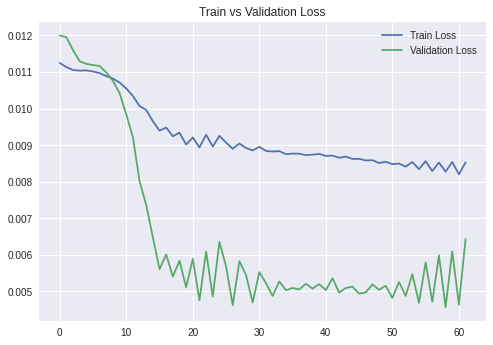

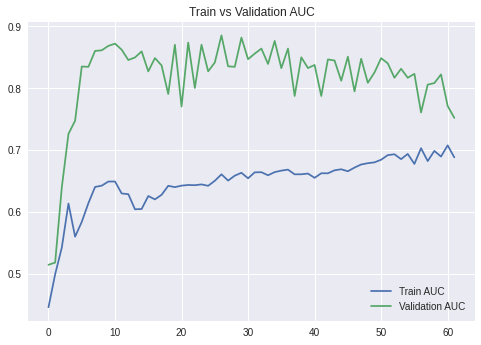


-------------------------------
Best metrics for validation set on Epoch 27:
Loss::      0.0046
AUC::       0.8853
Accuracy::  0.8222
F1::        0.7168
Precision:: 0.5586
Recall::    1.0000
Confusion Matrix:
 [[215  64]
 [  0  81]]
-------------------------------

Saving predictions from trained model...
Computing Predictions for train set.
dataset size: (2370, 14)
Computing Predictions for validation set.
dataset size: (360, 14)
Computing Predictions for test set.
dataset size: (372, 14)

--------------------------------------------------------------------
--------------------------------------------------------------------
Running sagittal - slice:22 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating final reference file for prepared images...
Loading untrained model...
VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0114      Validation 0.0127
AUC::       Train 0.4733      Validation 0.5000
Accuracy::  Train 0.4623      Validation 0.2250
F1::        Train 0.5969      Validation 0.3673
Precision:: Train 0.4685      Validation 0.2250
Recall::    Train 0.8223      Validation 1.0000
Validation Confusion Matrix:
 [[  0 279]
 [  0  81]]

Epoch 1 took 6.40 seconds
---------------------------------------------------------------------
Best validation AUC so far: 0.5000

---------------------------------------------------------------------
Running Epoch 2 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0111      Validation 0.0117
AUC::       Train 0.5143      Validation 0.5121
Accuracy::  Train 0.5011      Validation 0.4000
F1::        Train 0.6442      Validation 0.3494
Precision:: Train 0.4920      Validation 0.2311
Recall::    Train 0.9329      Validation 0.7160
Validation Confusion Matrix:
 [[ 86 193]
 [ 23  58]]

Epoch 2 took 6.58 seconds
---------------------------------------------------------------------
Best validation AUC so far: 0.5121

---------------------------------------------------------------------
Running Epoch 3 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0111      Validation 0.0112
AUC::       Train 0.5295      Validation 0.4960
Accuracy::  Train 0.5390      Validation 0.7417
F1::        Train 0.3257      Validation 0.0792
Precision:: Train 0.5581      Validation 0.2000
Recall::    Train 0.2300      Validation 0.0494
Validation Confusion Matrix:
 [[263  16]
 [ 77   4]]

Epoch 3 took 6.55 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 4 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0112      Validation 0.0113
AUC::       Train 0.4934      Validation 0.4847
Accuracy::  Train 0.5082      Validation 0.7444
F1::        Train 0.0489      Validation 0.0213
Precision:: Train 0.3846      Validation 0.0769
Recall::    Train 0.0261      Validation 0.0123
Validation Confusion Matrix:
 [[267  12]
 [ 80   1]]

Epoch 4 took 6.75 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 5 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
    self._shutdown_workers()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0112      Validation 0.0115
AUC::       Train 0.4728      Validation 0.4570
Accuracy::  Train 0.4846      Validation 0.5861
F1::        Train 0.1561      Validation 0.1946
Precision:: Train 0.3767      Validation 0.1731
Recall::    Train 0.0984      Validation 0.2222
Validation Confusion Matrix:
 [[193  86]
 [ 63  18]]

Epoch 5 took 6.70 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 6 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0111      Validation 0.0115
AUC::       Train 0.4815      Validation 0.6233
Accuracy::  Train 0.4854      Validation 0.5722
F1::        Train 0.4025      Validation 0.4296
Precision:: Train 0.4597      Validation 0.3069
Recall::    Train 0.3580      Validation 0.7160
Validation Confusion Matrix:
 [[148 131]
 [ 23  58]]

Epoch 6 took 6.80 seconds
---------------------------------------------------------------------
Best validation AUC so far: 0.6233

---------------------------------------------------------------------
Running Epoch 7 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0111      Validation 0.0116
AUC::       Train 0.5216      Validation 0.5808
Accuracy::  Train 0.5183      Validation 0.4861
F1::        Train 0.5567      Validation 0.3974
Precision:: Train 0.5021      Validation 0.2699
Recall::    Train 0.6246      Validation 0.7531
Validation Confusion Matrix:
 [[114 165]
 [ 20  61]]

Epoch 7 took 7.33 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 8 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0111      Validation 0.0115
AUC::       Train 0.5378      Validation 0.6258
Accuracy::  Train 0.5335      Validation 0.5694
F1::        Train 0.5826      Validation 0.4322
Precision:: Train 0.5140      Validation 0.3073
Recall::    Train 0.6725      Validation 0.7284
Validation Confusion Matrix:
 [[146 133]
 [ 22  59]]

Epoch 8 took 6.80 seconds
---------------------------------------------------------------------
Best validation AUC so far: 0.6258

---------------------------------------------------------------------
Running Epoch 9 of  100
Loss::      Train 0.0111      Validation 0.0114
AUC::       Train 0.5622      Validation 0.6790
Accuracy::  Train 0.5605      Validation 0.6722
F1::        Train 0.5750      Validation 0.4870
Precision:: Train 0.5406      Validation 0.3758
Recall::    Train 0.6141      Validation 0.6914
Validation Confusion Matrix:
 [[186  93]
 [ 25  56]]

Epoch 9 took 6.14 seconds
----------------------------------------------------------------

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Loss::      Train 0.0105      Validation 0.0093
AUC::       Train 0.5320      Validation 0.6205
Accuracy::  Train 0.5428      Validation 0.7444
F1::        Train 0.2878      Validation 0.4103
Precision:: Train 0.5856      Validation 0.4267
Recall::    Train 0.1908      Validation 0.3951
Validation Confusion Matrix:
 [[236  43]
 [ 49  32]]

Epoch 28 took 6.13 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 29 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Loss::      Train 0.0107      Validation 0.0106
AUC::       Train 0.5431      Validation 0.7061
Accuracy::  Train 0.5407      Validation 0.5444
F1::        Train 0.5667      Validation 0.4969
Precision:: Train 0.5216      Validation 0.3306
Recall::    Train 0.6202      Validation 1.0000
Validation Confusion Matrix:
 [[115 164]
 [  0  81]]

Epoch 29 took 6.14 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 30 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Loss::      Train 0.0101      Validation 0.0086
AUC::       Train 0.6117      Validation 0.7286
Accuracy::  Train 0.6027      Validation 0.7083
F1::        Train 0.6860      Validation 0.5415
Precision:: Train 0.5556      Validation 0.4189
Recall::    Train 0.8963      Validation 0.7654
Validation Confusion Matrix:
 [[193  86]
 [ 19  62]]

Epoch 30 took 6.18 seconds
---------------------------------------------------------------------
Best validation AUC so far: 0.7286

---------------------------------------------------------------------
Running Epoch 31 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0110      Validation 0.0111
AUC::       Train 0.5401      Validation 0.6183
Accuracy::  Train 0.5361      Validation 0.4694
F1::        Train 0.5827      Validation 0.4299
Precision:: Train 0.5161      Validation 0.2835
Recall::    Train 0.6690      Validation 0.8889
Validation Confusion Matrix:
 [[ 97 182]
 [  9  72]]

Epoch 31 took 6.39 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 32 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0101      Validation 0.0084
AUC::       Train 0.5649      Validation 0.6233
Accuracy::  Train 0.5656      Validation 0.6944
F1::        Train 0.5471      Validation 0.4211
Precision:: Train 0.5524      Validation 0.3670
Recall::    Train 0.5418      Validation 0.4938
Validation Confusion Matrix:
 [[210  69]
 [ 41  40]]

Epoch 32 took 6.43 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 33 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
Exception ignored in: <function _MultiProce

Loss::      Train 0.0112      Validation 0.0112
AUC::       Train 0.4991      Validation 0.6310
Accuracy::  Train 0.4981      Validation 0.4417
F1::        Train 0.5066      Validation 0.4401
Precision:: Train 0.4834      Validation 0.2842
Recall::    Train 0.5322      Validation 0.9753
Validation Confusion Matrix:
 [[ 80 199]
 [  2  79]]

Epoch 33 took 6.49 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 34 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0102      Validation 0.0093
AUC::       Train 0.5941      Validation 0.6657
Accuracy::  Train 0.5850      Validation 0.5972
F1::        Train 0.6729      Validation 0.4689
Precision:: Train 0.5441      Validation 0.3333
Recall::    Train 0.8815      Validation 0.7901
Validation Confusion Matrix:
 [[151 128]
 [ 17  64]]

Epoch 34 took 6.47 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 35 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0100      Validation 0.0084
AUC::       Train 0.5841      Validation 0.7254
Accuracy::  Train 0.5816      Validation 0.6694
F1::        Train 0.6054      Validation 0.5296
Precision:: Train 0.5571      Validation 0.3895
Recall::    Train 0.6629      Validation 0.8272
Validation Confusion Matrix:
 [[174 105]
 [ 14  67]]

Epoch 35 took 6.54 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 36 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0100      Validation 0.0088
AUC::       Train 0.5966      Validation 0.7095
Accuracy::  Train 0.5892      Validation 0.5972
F1::        Train 0.6623      Validation 0.5051
Precision:: Train 0.5501      Validation 0.3491
Recall::    Train 0.8319      Validation 0.9136
Validation Confusion Matrix:
 [[141 138]
 [  7  74]]

Epoch 36 took 6.52 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 37 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
Traceback (most recent call last):
    if w.is_alive():
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    assert self._parent_pid == os.getpid(), 'can only test a child process'
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in

Loss::      Train 0.0098      Validation 0.0084
AUC::       Train 0.6116      Validation 0.7407
Accuracy::  Train 0.6027      Validation 0.6389
F1::        Train 0.6852      Validation 0.5357
Precision:: Train 0.5559      Validation 0.3769
Recall::    Train 0.8929      Validation 0.9259
Validation Confusion Matrix:
 [[155 124]
 [  6  75]]

Epoch 37 took 6.49 seconds
---------------------------------------------------------------------
Best validation AUC so far: 0.7407

---------------------------------------------------------------------
Running Epoch 38 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
    assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
AssertionError: can only test a child process
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0100      Validation 0.0086
AUC::       Train 0.6115      Validation 0.6669
Accuracy::  Train 0.6040      Validation 0.6194
F1::        Train 0.6747      Validation 0.4710
Precision:: Train 0.5601      Validation 0.3427
Recall::    Train 0.8484      Validation 0.7531
Validation Confusion Matrix:
 [[162 117]
 [ 20  61]]

Epoch 38 took 6.54 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 39 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0099      Validation 0.0082
AUC::       Train 0.5938      Validation 0.6916
Accuracy::  Train 0.5896      Validation 0.6306
F1::        Train 0.6319      Validation 0.4943
Precision:: Train 0.5585      Validation 0.3571
Recall::    Train 0.7274      Validation 0.8025
Validation Confusion Matrix:
 [[162 117]
 [ 16  65]]

Epoch 39 took 6.50 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 40 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
    self._shutdown_workers()
Traceback (most recent call last):
  File "/usr/local/lib/python3

Loss::      Train 0.0100      Validation 0.0087
AUC::       Train 0.6075      Validation 0.6701
Accuracy::  Train 0.5997      Validation 0.5972
F1::        Train 0.6735      Validation 0.4727
Precision:: Train 0.5566      Validation 0.3351
Recall::    Train 0.8528      Validation 0.8025
Validation Confusion Matrix:
 [[150 129]
 [ 16  65]]

Epoch 40 took 6.51 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 41 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0098      Validation 0.0085
AUC::       Train 0.6195      Validation 0.6706
Accuracy::  Train 0.6141      Validation 0.6389
F1::        Train 0.6652      Validation 0.4758
Precision:: Train 0.5735      Validation 0.3533
Recall::    Train 0.7918      Validation 0.7284
Validation Confusion Matrix:
 [[171 108]
 [ 22  59]]

Epoch 41 took 6.61 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 42 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0099      Validation 0.0086
AUC::       Train 0.6247      Validation 0.6320
Accuracy::  Train 0.6187      Validation 0.6333
F1::        Train 0.6739      Validation 0.4359
Precision:: Train 0.5751      Validation 0.3333
Recall::    Train 0.8136      Validation 0.6296
Validation Confusion Matrix:
 [[177 102]
 [ 30  51]]

Epoch 42 took 6.68 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 43 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0097      Validation 0.0084
AUC::       Train 0.6343      Validation 0.6969
Accuracy::  Train 0.6305      Validation 0.6389
F1::        Train 0.6641      Validation 0.5000
Precision:: Train 0.5932      Validation 0.3631
Recall::    Train 0.7544      Validation 0.8025
Validation Confusion Matrix:
 [[165 114]
 [ 16  65]]

Epoch 43 took 6.82 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 44 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0098      Validation 0.0086
AUC::       Train 0.6293      Validation 0.6374
Accuracy::  Train 0.6229      Validation 0.6417
F1::        Train 0.6809      Validation 0.4416
Precision:: Train 0.5768      Validation 0.3400
Recall::    Train 0.8310      Validation 0.6296
Validation Confusion Matrix:
 [[180  99]
 [ 30  51]]

Epoch 44 took 6.80 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 45 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
Exception ignored in: 

Loss::      Train 0.0097      Validation 0.0084
AUC::       Train 0.6271      Validation 0.6762
Accuracy::  Train 0.6246      Validation 0.6611
F1::        Train 0.6454      Validation 0.4831
Precision:: Train 0.5947      Validation 0.3677
Recall::    Train 0.7056      Validation 0.7037
Validation Confusion Matrix:
 [[181  98]
 [ 24  57]]

Epoch 45 took 7.36 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 46 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
    assert self._parent_pid == os.getpid(), 'can only test a child process'
Traceback (most recent call last):
AssertionError: can only test a child process
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0098      Validation 0.0086
AUC::       Train 0.6197      Validation 0.6209
Accuracy::  Train 0.6145      Validation 0.6500
F1::        Train 0.6627      Validation 0.4220
Precision:: Train 0.5749      Validation 0.3358
Recall::    Train 0.7822      Validation 0.5679
Validation Confusion Matrix:
 [[188  91]
 [ 35  46]]

Epoch 46 took 7.32 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 47 of  100
Loss::      Train 0.0096      Validation 0.0085
AUC::       Train 0.6306      Validation 0.6794
Accuracy::  Train 0.6280      Validation 0.6389
F1::        Train 0.6497      Validation 0.4841
Precision:: Train 0.5971      Validation 0.3567
Recall::    Train 0.7125      Validation 0.7531
Validation Confusion Matrix:
 [[169 110]
 [ 20  61]]

Epoch 47 took 6.12 seconds
---------------------------------------------------------------------

-------------------------

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Loss::      Train 0.0097      Validation 0.0081
AUC::       Train 0.6464      Validation 0.7017
Accuracy::  Train 0.6411      Validation 0.7278
F1::        Train 0.6872      Validation 0.5196
Precision:: Train 0.5944      Validation 0.4309
Recall::    Train 0.8145      Validation 0.6543
Validation Confusion Matrix:
 [[209  70]
 [ 28  53]]

Epoch 67 took 6.11 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 68 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Loss::      Train 0.0099      Validation 0.0093
AUC::       Train 0.6297      Validation 0.7129
Accuracy::  Train 0.6326      Validation 0.6500
F1::        Train 0.5858      Validation 0.5154
Precision:: Train 0.6450      Validation 0.3743
Recall::    Train 0.5366      Validation 0.8272
Validation Confusion Matrix:
 [[167 112]
 [ 14  67]]

Epoch 68 took 6.11 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 69 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
    self._shutdown_workers()
Traceback (most recent call last):
  File "/usr/local/lib/python3

Loss::      Train 0.0093      Validation 0.0082
AUC::       Train 0.6607      Validation 0.6561
Accuracy::  Train 0.6529      Validation 0.7250
F1::        Train 0.7169      Validation 0.4649
Precision:: Train 0.5924      Validation 0.4135
Recall::    Train 0.9077      Validation 0.5309
Validation Confusion Matrix:
 [[218  61]
 [ 38  43]]

Epoch 69 took 6.37 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 70 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0092      Validation 0.0081
AUC::       Train 0.6632      Validation 0.6778
Accuracy::  Train 0.6639      Validation 0.7111
F1::        Train 0.6497      Validation 0.4902
Precision:: Train 0.6557      Validation 0.4065
Recall::    Train 0.6437      Validation 0.6173
Validation Confusion Matrix:
 [[206  73]
 [ 31  50]]

Epoch 70 took 6.40 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 71 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0088      Validation 0.0074
AUC::       Train 0.6950      Validation 0.6085
Accuracy::  Train 0.6921      Validation 0.7667
F1::        Train 0.7121      Validation 0.3824
Precision:: Train 0.6506      Validation 0.4727
Recall::    Train 0.7866      Validation 0.3210
Validation Confusion Matrix:
 [[250  29]
 [ 55  26]]

Epoch 71 took 6.44 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 72 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0091      Validation 0.0083
AUC::       Train 0.6711      Validation 0.6852
Accuracy::  Train 0.6723      Validation 0.6750
F1::        Train 0.6514      Validation 0.4935
Precision:: Train 0.6716      Validation 0.3800
Recall::    Train 0.6324      Validation 0.7037
Validation Confusion Matrix:
 [[186  93]
 [ 24  57]]

Epoch 72 took 6.43 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 73 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0085      Validation 0.0075
AUC::       Train 0.7184      Validation 0.6308
Accuracy::  Train 0.7178      Validation 0.7333
F1::        Train 0.7166      Validation 0.4286
Precision:: Train 0.6974      Validation 0.4138
Recall::    Train 0.7369      Validation 0.4444
Validation Confusion Matrix:
 [[228  51]
 [ 45  36]]

Epoch 73 took 6.36 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 74 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
AssertionError: can only test a child process
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0085      Validation 0.0073
AUC::       Train 0.7222      Validation 0.6077
Accuracy::  Train 0.7221      Validation 0.7722
F1::        Train 0.7173      Validation 0.3788
Precision:: Train 0.7067      Validation 0.4902
Recall::    Train 0.7282      Validation 0.3086
Validation Confusion Matrix:
 [[253  26]
 [ 56  25]]

Epoch 74 took 6.40 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 75 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
    if w.is_alive():
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
Traceback (most recent call last):
    assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
AssertionError: can only test a child process
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0088      Validation 0.0074
AUC::       Train 0.6900      Validation 0.6529
Accuracy::  Train 0.6908      Validation 0.7472
F1::        Train 0.6749      Validation 0.4615
Precision:: Train 0.6874      Validation 0.4432
Recall::    Train 0.6629      Validation 0.4815
Validation Confusion Matrix:
 [[230  49]
 [ 42  39]]

Epoch 75 took 6.48 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 76 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
Exception ignored in: <function _MultiProce

Loss::      Train 0.0087      Validation 0.0083
AUC::       Train 0.7102      Validation 0.6189
Accuracy::  Train 0.7115      Validation 0.6944
F1::        Train 0.6916      Validation 0.4149
Precision:: Train 0.7168      Validation 0.3645
Recall::    Train 0.6681      Validation 0.4815
Validation Confusion Matrix:
 [[211  68]
 [ 42  39]]

Epoch 76 took 6.55 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 77 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0080      Validation 0.0070
AUC::       Train 0.7460      Validation 0.6364
Accuracy::  Train 0.7474      Validation 0.7556
F1::        Train 0.7293      Validation 0.4359
Precision:: Train 0.7577      Validation 0.4533
Recall::    Train 0.7030      Validation 0.4198
Validation Confusion Matrix:
 [[238  41]
 [ 47  34]]

Epoch 77 took 6.49 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 78 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
Exception ignored in: <function _MultiProce

Loss::      Train 0.0081      Validation 0.0072
AUC::       Train 0.7390      Validation 0.5824
Accuracy::  Train 0.7381      Validation 0.7806
F1::        Train 0.7398      Validation 0.3130
Precision:: Train 0.7127      Validation 0.5294
Recall::    Train 0.7692      Validation 0.2222
Validation Confusion Matrix:
 [[263  16]
 [ 63  18]]

Epoch 78 took 6.57 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 79 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    assert self._parent_pid == os.getpid(), 'can only test a child process'
    self._shutdown_workers()
AssertionError: can only test a child process
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0082      Validation 0.0068
AUC::       Train 0.7238      Validation 0.6394
Accuracy::  Train 0.7254      Validation 0.7806
F1::        Train 0.7037      Validation 0.4397
Precision:: Train 0.7369      Validation 0.5167
Recall::    Train 0.6733      Validation 0.3827
Validation Confusion Matrix:
 [[250  29]
 [ 50  31]]

Epoch 79 took 6.60 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 80 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0084      Validation 0.0076
AUC::       Train 0.7377      Validation 0.5474
Accuracy::  Train 0.7368      Validation 0.7806
F1::        Train 0.7378      Validation 0.2020
Precision:: Train 0.7127      Validation 0.5556
Recall::    Train 0.7648      Validation 0.1235
Validation Confusion Matrix:
 [[271   8]
 [ 71  10]]

Epoch 80 took 6.63 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 81 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0103      Validation 0.0096
AUC::       Train 0.5957      Validation 0.7336
Accuracy::  Train 0.5985      Validation 0.6278
F1::        Train 0.5505      Validation 0.5282
Precision:: Train 0.6010      Validation 0.3695
Recall::    Train 0.5078      Validation 0.9259
Validation Confusion Matrix:
 [[151 128]
 [  6  75]]

Epoch 81 took 6.66 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 82 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
AssertionError: can only test a child process
Traceback (most recent call last):
    self._shutdown_workers()
  File "/usr/local/lib/python3

Loss::      Train 0.0092      Validation 0.0087
AUC::       Train 0.6582      Validation 0.7254
Accuracy::  Train 0.6588      Validation 0.6694
F1::        Train 0.6450      Validation 0.5296
Precision:: Train 0.6499      Validation 0.3895
Recall::    Train 0.6402      Validation 0.8272
Validation Confusion Matrix:
 [[174 105]
 [ 14  67]]

Epoch 82 took 6.81 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 83 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0085      Validation 0.0069
AUC::       Train 0.7057      Validation 0.5884
Accuracy::  Train 0.7022      Validation 0.7694
F1::        Train 0.7259      Validation 0.3360
Precision:: Train 0.6548      Validation 0.4773
Recall::    Train 0.8145      Validation 0.2593
Validation Confusion Matrix:
 [[256  23]
 [ 60  21]]

Epoch 83 took 6.79 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 84 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0090      Validation 0.0086
AUC::       Train 0.6870      Validation 0.6567
Accuracy::  Train 0.6879      Validation 0.7056
F1::        Train 0.6711      Validation 0.4646
Precision:: Train 0.6851      Validation 0.3932
Recall::    Train 0.6577      Validation 0.5679
Validation Confusion Matrix:
 [[208  71]
 [ 35  46]]

Epoch 84 took 7.33 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 85 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
    assert self._parent_pid == os.getpid(), 'can only test a child process'
Traceback (most recent call last):
AssertionError: can only test a child process
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0081      Validation 0.0071
AUC::       Train 0.7427      Validation 0.6416
Accuracy::  Train 0.7440      Validation 0.7500
F1::        Train 0.7265      Validation 0.4444
Precision:: Train 0.7526      Validation 0.4444
Recall::    Train 0.7021      Validation 0.4444
Validation Confusion Matrix:
 [[234  45]
 [ 45  36]]

Epoch 85 took 6.90 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 86 of  100
Loss::      Train 0.0079      Validation 0.0068
AUC::       Train 0.7496      Validation 0.6177
Accuracy::  Train 0.7482      Validation 0.7944
F1::        Train 0.7532      Validation 0.3934
Precision:: Train 0.7168      Validation 0.5854
Recall::    Train 0.7936      Validation 0.2963
Validation Confusion Matrix:
 [[262  17]
 [ 57  24]]

Epoch 86 took 6.12 seconds
---------------------------------------------------------------------

-------------------------

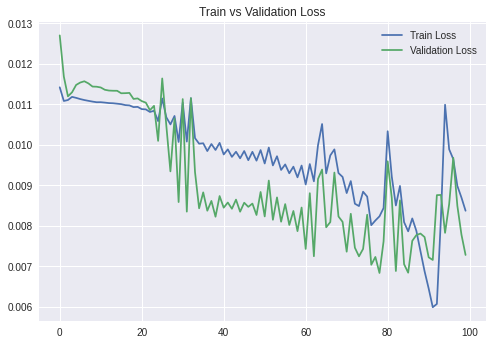

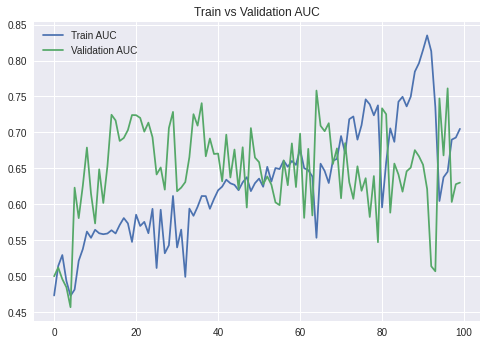


-------------------------------
Best metrics for validation set on Epoch 97:
Loss::      0.0097
AUC::       0.7613
Accuracy::  0.6639
F1::        0.5568
Precision:: 0.3958
Recall::    0.9383
Confusion Matrix:
 [[163 116]
 [  5  76]]
-------------------------------

Saving predictions from trained model...
Computing Predictions for train set.
dataset size: (2371, 14)
Computing Predictions for validation set.
dataset size: (360, 14)
Computing Predictions for test set.
dataset size: (372, 14)

--------------------------------------------------------------------
--------------------------------------------------------------------
Running axial - slice:14 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating final reference file for prepared images...
Loading untrained model...
VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_siz

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3

Loss::      Train 0.0113      Validation 0.0122
AUC::       Train 0.4481      Validation 0.5046
Accuracy::  Train 0.4377      Validation 0.2396
F1::        Train 0.5692      Validation 0.3695
Precision:: Train 0.4522      Validation 0.2273
Recall::    Train 0.7679      Validation 0.9877
Validation Confusion Matrix:
 [[  6 272]
 [  1  80]]

Epoch 1 took 6.62 seconds
---------------------------------------------------------------------
Best validation AUC so far: 0.5046

---------------------------------------------------------------------
Running Epoch 2 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
    self._shutdown_workers()
  File "/usr/local/lib/python3

Loss::      Train 0.0111      Validation 0.0117
AUC::       Train 0.5028      Validation 0.4697
Accuracy::  Train 0.4909      Validation 0.3955
F1::        Train 0.6227      Validation 0.3111
Precision:: Train 0.4854      Validation 0.2094
Recall::    Train 0.8682      Validation 0.6049
Validation Confusion Matrix:
 [[ 93 185]
 [ 32  49]]

Epoch 2 took 6.73 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 3 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
    assert self._parent_pid == os.getpid(), 'can only test a child process'
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
AssertionError: can only test a child process
    self._shutdown_workers()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/d

Loss::      Train 0.0110      Validation 0.0111
AUC::       Train 0.5291      Validation 0.4972
Accuracy::  Train 0.5399      Validation 0.7632
F1::        Train 0.2922      Validation 0.0230
Precision:: Train 0.5711      Validation 0.1667
Recall::    Train 0.1963      Validation 0.0123
Validation Confusion Matrix:
 [[273   5]
 [ 80   1]]

Epoch 3 took 6.71 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 4 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0111      Validation 0.0109
AUC::       Train 0.4993      Validation 0.5000
Accuracy::  Train 0.5154      Validation 0.7744
F1::        Train 0.0069      Validation 0.0000
Precision:: Train 0.4000      Validation 0.0000
Recall::    Train 0.0035      Validation 0.0000
Validation Confusion Matrix:
 [[278   0]
 [ 81   0]]

Epoch 4 took 6.83 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 5 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/d

Loss::      Train 0.0112      Validation 0.0109
AUC::       Train 0.5000      Validation 0.5000
Accuracy::  Train 0.5163      Validation 0.7744
F1::        Train 0.0000      Validation 0.0000
Precision:: Train 0.0000      Validation 0.0000
Recall::    Train 0.0000      Validation 0.0000
Validation Confusion Matrix:
 [[278   0]
 [ 81   0]]

Epoch 5 took 7.36 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 6 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/

Loss::      Train 0.0111      Validation 0.0111
AUC::       Train 0.5004      Validation 0.4982
Accuracy::  Train 0.5167      Validation 0.7716
F1::        Train 0.0017      Validation 0.0000
Precision:: Train 1.0000      Validation 0.0000
Recall::    Train 0.0009      Validation 0.0000
Validation Confusion Matrix:
 [[277   1]
 [ 81   0]]

Epoch 6 took 7.35 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 7 of  100
Loss::      Train 0.0111      Validation 0.0112
AUC::       Train 0.4996      Validation 0.5044
Accuracy::  Train 0.5158      Validation 0.7744
F1::        Train 0.0000      Validation 0.0241
Precision:: Train 0.0000      Validation 0.5000
Recall::    Train 0.0000      Validation 0.0123
Validation Confusion Matrix:
 [[277   1]
 [ 80   1]]

Epoch 7 took 6.15 seconds
---------------------------------------------------------------------

----------------------------

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Loss::      Train 0.0110      Validation 0.0111
AUC::       Train 0.5038      Validation 0.4982
Accuracy::  Train 0.5196      Validation 0.7716
F1::        Train 0.0323      Validation 0.0000
Precision:: Train 0.6333      Validation 0.0000
Recall::    Train 0.0166      Validation 0.0000
Validation Confusion Matrix:
 [[277   1]
 [ 81   0]]

Epoch 27 took 6.12 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 28 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Loss::      Train 0.0110      Validation 0.0111
AUC::       Train 0.5053      Validation 0.5044
Accuracy::  Train 0.5209      Validation 0.7744
F1::        Train 0.0470      Validation 0.0241
Precision:: Train 0.6222      Validation 0.5000
Recall::    Train 0.0244      Validation 0.0123
Validation Confusion Matrix:
 [[277   1]
 [ 80   1]]

Epoch 28 took 6.12 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 29 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3

Loss::      Train 0.0110      Validation 0.0111
AUC::       Train 0.5099      Validation 0.5149
Accuracy::  Train 0.5255      Validation 0.7772
F1::        Train 0.0570      Validation 0.0698
Precision:: Train 0.7391      Validation 0.6000
Recall::    Train 0.0297      Validation 0.0370
Validation Confusion Matrix:
 [[276   2]
 [ 78   3]]

Epoch 29 took 6.41 seconds
---------------------------------------------------------------------
Best validation AUC so far: 0.5149

---------------------------------------------------------------------
Running Epoch 30 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0110      Validation 0.0110
AUC::       Train 0.5117      Validation 0.5026
Accuracy::  Train 0.5272      Validation 0.7716
F1::        Train 0.0635      Validation 0.0238
Precision:: Train 0.7600      Validation 0.3333
Recall::    Train 0.0332      Validation 0.0123
Validation Confusion Matrix:
 [[276   2]
 [ 80   1]]

Epoch 30 took 6.48 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 31 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0110      Validation 0.0110
AUC::       Train 0.5095      Validation 0.5105
Accuracy::  Train 0.5251      Validation 0.7772
F1::        Train 0.0570      Validation 0.0476
Precision:: Train 0.7234      Validation 0.6667
Recall::    Train 0.0297      Validation 0.0247
Validation Confusion Matrix:
 [[277   1]
 [ 79   2]]

Epoch 31 took 6.42 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 32 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
Traceback (most recent call last):
AssertionError: can only test a child process
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0110      Validation 0.0111
AUC::       Train 0.5166      Validation 0.5149
Accuracy::  Train 0.5314      Validation 0.7772
F1::        Train 0.1120      Validation 0.0698
Precision:: Train 0.6731      Validation 0.6000
Recall::    Train 0.0611      Validation 0.0370
Validation Confusion Matrix:
 [[276   2]
 [ 78   3]]

Epoch 32 took 6.49 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 33 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0110      Validation 0.0110
AUC::       Train 0.5248      Validation 0.5105
Accuracy::  Train 0.5390      Validation 0.7772
F1::        Train 0.1522      Validation 0.0476
Precision:: Train 0.6901      Validation 0.6667
Recall::    Train 0.0855      Validation 0.0247
Validation Confusion Matrix:
 [[277   1]
 [ 79   2]]

Epoch 33 took 6.49 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 34 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0110      Validation 0.0111
AUC::       Train 0.5130      Validation 0.5059
Accuracy::  Train 0.5272      Validation 0.7632
F1::        Train 0.1331      Validation 0.0659
Precision:: Train 0.5890      Validation 0.3000
Recall::    Train 0.0750      Validation 0.0370
Validation Confusion Matrix:
 [[271   7]
 [ 78   3]]

Epoch 34 took 6.49 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 35 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0110      Validation 0.0111
AUC::       Train 0.5347      Validation 0.4941
Accuracy::  Train 0.5479      Validation 0.7382
F1::        Train 0.2154      Validation 0.0784
Precision:: Train 0.6712      Validation 0.1905
Recall::    Train 0.1283      Validation 0.0494
Validation Confusion Matrix:
 [[261  17]
 [ 77   4]]

Epoch 35 took 6.46 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 36 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0110      Validation 0.0110
AUC::       Train 0.5459      Validation 0.5103
Accuracy::  Train 0.5589      Validation 0.7632
F1::        Train 0.2422      Validation 0.0860
Precision:: Train 0.7167      Validation 0.3333
Recall::    Train 0.1457      Validation 0.0494
Validation Confusion Matrix:
 [[270   8]
 [ 77   4]]

Epoch 36 took 6.59 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 37 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
Exception ignored in: 

Loss::      Train 0.0110      Validation 0.0110
AUC::       Train 0.5327      Validation 0.5180
Accuracy::  Train 0.5450      Validation 0.7549
F1::        Train 0.2472      Validation 0.1373
Precision:: Train 0.6189      Validation 0.3333
Recall::    Train 0.1545      Validation 0.0864
Validation Confusion Matrix:
 [[264  14]
 [ 74   7]]

Epoch 37 took 6.52 seconds
---------------------------------------------------------------------
Best validation AUC so far: 0.5180

---------------------------------------------------------------------
Running Epoch 38 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/

Loss::      Train 0.0110      Validation 0.0109
AUC::       Train 0.5504      Validation 0.5250
Accuracy::  Train 0.5623      Validation 0.7521
F1::        Train 0.2922      Validation 0.1682
Precision:: Train 0.6708      Validation 0.3462
Recall::    Train 0.1867      Validation 0.1111
Validation Confusion Matrix:
 [[261  17]
 [ 72   9]]

Epoch 38 took 6.58 seconds
---------------------------------------------------------------------
Best validation AUC so far: 0.5250

---------------------------------------------------------------------
Running Epoch 39 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/d

Loss::      Train 0.0110      Validation 0.0110
AUC::       Train 0.5529      Validation 0.5512
Accuracy::  Train 0.5635      Validation 0.7521
F1::        Train 0.3346      Validation 0.2521
Precision:: Train 0.6373      Validation 0.3947
Recall::    Train 0.2269      Validation 0.1852
Validation Confusion Matrix:
 [[255  23]
 [ 66  15]]

Epoch 39 took 6.69 seconds
---------------------------------------------------------------------
Best validation AUC so far: 0.5512

---------------------------------------------------------------------
Running Epoch 40 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
Traceback (most recent call last):
    if w.is_alive():
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
  File "/usr/lib/pytho

Loss::      Train 0.0109      Validation 0.0109
AUC::       Train 0.5563      Validation 0.5229
Accuracy::  Train 0.5665      Validation 0.7354
F1::        Train 0.3504      Validation 0.1880
Precision:: Train 0.6368      Validation 0.3056
Recall::    Train 0.2417      Validation 0.1358
Validation Confusion Matrix:
 [[253  25]
 [ 70  11]]

Epoch 40 took 6.70 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 41 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0109      Validation 0.0109
AUC::       Train 0.5535      Validation 0.5484
Accuracy::  Train 0.5627      Validation 0.7409
F1::        Train 0.3744      Validation 0.2560
Precision:: Train 0.6078      Validation 0.3636
Recall::    Train 0.2705      Validation 0.1975
Validation Confusion Matrix:
 [[250  28]
 [ 65  16]]

Epoch 41 took 6.72 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 42 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    self._shutdown_workers()
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0109      Validation 0.0109
AUC::       Train 0.5611      Validation 0.5245
Accuracy::  Train 0.5690      Validation 0.7242
F1::        Train 0.4169      Validation 0.2080
Precision:: Train 0.6033      Validation 0.2955
Recall::    Train 0.3185      Validation 0.1605
Validation Confusion Matrix:
 [[247  31]
 [ 68  13]]

Epoch 42 took 6.79 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 43 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/

Loss::      Train 0.0109      Validation 0.0109
AUC::       Train 0.5637      Validation 0.5147
Accuracy::  Train 0.5715      Validation 0.7159
F1::        Train 0.4210      Validation 0.1905
Precision:: Train 0.6079      Validation 0.2667
Recall::    Train 0.3220      Validation 0.1481
Validation Confusion Matrix:
 [[245  33]
 [ 69  12]]

Epoch 43 took 6.86 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 44 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/d

Loss::      Train 0.0109      Validation 0.0110
AUC::       Train 0.5529      Validation 0.5636
Accuracy::  Train 0.5580      Validation 0.7103
F1::        Train 0.4634      Validation 0.3158
Precision:: Train 0.5615      Validation 0.3380
Recall::    Train 0.3944      Validation 0.2963
Validation Confusion Matrix:
 [[231  47]
 [ 57  24]]

Epoch 44 took 7.40 seconds
---------------------------------------------------------------------
Best validation AUC so far: 0.5636

---------------------------------------------------------------------
Running Epoch 45 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0108      Validation 0.0107
AUC::       Train 0.5824      Validation 0.5536
Accuracy::  Train 0.5889      Validation 0.7354
F1::        Train 0.4752      Validation 0.2748
Precision:: Train 0.6211      Validation 0.3600
Recall::    Train 0.3848      Validation 0.2222
Validation Confusion Matrix:
 [[246  32]
 [ 63  18]]

Epoch 45 took 6.88 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 46 of  100
Loss::      Train 0.0109      Validation 0.0109
AUC::       Train 0.5674      Validation 0.5677
Accuracy::  Train 0.5720      Validation 0.6964
F1::        Train 0.4905      Validation 0.3313
Precision:: Train 0.5782      Validation 0.3293
Recall::    Train 0.4258      Validation 0.3333
Validation Confusion Matrix:
 [[223  55]
 [ 54  27]]

Epoch 46 took 6.17 seconds
---------------------------------------------------------------------
Best validation AUC so far

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Loss::      Train 0.0099      Validation 0.0095
AUC::       Train 0.6528      Validation 0.6323
Accuracy::  Train 0.6539      Validation 0.7354
F1::        Train 0.6336      Validation 0.4311
Precision:: Train 0.6493      Validation 0.4186
Recall::    Train 0.6187      Validation 0.4444
Validation Confusion Matrix:
 [[228  50]
 [ 45  36]]

Epoch 65 took 6.16 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 66 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Loss::      Train 0.0099      Validation 0.0091
AUC::       Train 0.6512      Validation 0.6251
Accuracy::  Train 0.6534      Validation 0.7716
F1::        Train 0.6190      Validation 0.4143
Precision:: Train 0.6611      Validation 0.4915
Recall::    Train 0.5820      Validation 0.3580
Validation Confusion Matrix:
 [[248  30]
 [ 52  29]]

Epoch 66 took 6.17 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 67 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Loss::      Train 0.0106      Validation 0.0098
AUC::       Train 0.5842      Validation 0.6511
Accuracy::  Train 0.5846      Validation 0.7577
F1::        Train 0.5707      Validation 0.4596
Precision:: Train 0.5707      Validation 0.4625
Recall::    Train 0.5707      Validation 0.4568
Validation Confusion Matrix:
 [[235  43]
 [ 44  37]]

Epoch 67 took 6.16 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 68 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    if w.is_alive():
    self._shutdown_workers()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0106      Validation 0.0100
AUC::       Train 0.5841      Validation 0.5970
Accuracy::  Train 0.5851      Validation 0.7688
F1::        Train 0.5641      Validation 0.3566
Precision:: Train 0.5735      Validation 0.4792
Recall::    Train 0.5550      Validation 0.2840
Validation Confusion Matrix:
 [[253  25]
 [ 58  23]]

Epoch 68 took 6.45 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 69 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0114      Validation 0.0107
AUC::       Train 0.5064      Validation 0.6650
Accuracy::  Train 0.5116      Validation 0.7047
F1::        Train 0.4058      Validation 0.4752
Precision:: Train 0.4931      Validation 0.3967
Recall::    Train 0.3447      Validation 0.5926
Validation Confusion Matrix:
 [[205  73]
 [ 33  48]]

Epoch 69 took 6.42 seconds
---------------------------------------------------------------------
Best validation AUC so far: 0.6650

---------------------------------------------------------------------
Running Epoch 70 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0105      Validation 0.0097
AUC::       Train 0.6018      Validation 0.6086
Accuracy::  Train 0.6083      Validation 0.7799
F1::        Train 0.4984      Validation 0.3780
Precision:: Train 0.6548      Validation 0.5217
Recall::    Train 0.4023      Validation 0.2963
Validation Confusion Matrix:
 [[256  22]
 [ 57  24]]

Epoch 70 took 6.41 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 71 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
AssertionError: can only test a child process
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0105      Validation 0.0101
AUC::       Train 0.6132      Validation 0.6793
Accuracy::  Train 0.6133      Validation 0.7744
F1::        Train 0.6041      Validation 0.5031
Precision:: Train 0.5985      Validation 0.5000
Recall::    Train 0.6099      Validation 0.5062
Validation Confusion Matrix:
 [[237  41]
 [ 40  41]]

Epoch 71 took 6.47 seconds
---------------------------------------------------------------------
Best validation AUC so far: 0.6793

---------------------------------------------------------------------
Running Epoch 72 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
    assert self._parent_pid == os.getpid(), 'can only test a child process'
Traceback (most recent call last):
AssertionError: can only test a child process
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0101      Validation 0.0093
AUC::       Train 0.6298      Validation 0.6428
Accuracy::  Train 0.6323      Validation 0.7855
F1::        Train 0.5928      Validation 0.4460
Precision:: Train 0.6385      Validation 0.5345
Recall::    Train 0.5532      Validation 0.3827
Validation Confusion Matrix:
 [[251  27]
 [ 50  31]]

Epoch 72 took 6.57 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 73 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0100      Validation 0.0094
AUC::       Train 0.6301      Validation 0.6449
Accuracy::  Train 0.6302      Validation 0.7549
F1::        Train 0.6208      Validation 0.4500
Precision:: Train 0.6160      Validation 0.4557
Recall::    Train 0.6257      Validation 0.4444
Validation Confusion Matrix:
 [[235  43]
 [ 45  36]]

Epoch 73 took 6.51 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 74 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0099      Validation 0.0094
AUC::       Train 0.6409      Validation 0.6678
Accuracy::  Train 0.6442      Validation 0.7632
F1::        Train 0.5949      Validation 0.4848
Precision:: Train 0.6620      Validation 0.4762
Recall::    Train 0.5401      Validation 0.4938
Validation Confusion Matrix:
 [[234  44]
 [ 41  40]]

Epoch 74 took 6.47 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 75 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0094      Validation 0.0088
AUC::       Train 0.6773      Validation 0.6358
Accuracy::  Train 0.6779      Validation 0.7883
F1::        Train 0.6643      Validation 0.4328
Precision:: Train 0.6699      Validation 0.5472
Recall::    Train 0.6588      Validation 0.3580
Validation Confusion Matrix:
 [[254  24]
 [ 52  29]]

Epoch 75 took 6.53 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 76 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
Exception ignored in: 

Loss::      Train 0.0096      Validation 0.0094
AUC::       Train 0.6651      Validation 0.6323
Accuracy::  Train 0.6674      Validation 0.7354
F1::        Train 0.6338      Validation 0.4311
Precision:: Train 0.6779      Validation 0.4186
Recall::    Train 0.5951      Validation 0.4444
Validation Confusion Matrix:
 [[228  50]
 [ 45  36]]

Epoch 76 took 6.65 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 77 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
  File "/usr/lib/pytho

Loss::      Train 0.0091      Validation 0.0087
AUC::       Train 0.6950      Validation 0.6356
Accuracy::  Train 0.6973      Validation 0.7744
F1::        Train 0.6660      Validation 0.4336
Precision:: Train 0.7143      Validation 0.5000
Recall::    Train 0.6239      Validation 0.3827
Validation Confusion Matrix:
 [[247  31]
 [ 50  31]]

Epoch 77 took 6.68 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 78 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0089      Validation 0.0085
AUC::       Train 0.7089      Validation 0.6161
Accuracy::  Train 0.7104      Validation 0.7577
F1::        Train 0.6882      Validation 0.4000
Precision:: Train 0.7182      Validation 0.4531
Recall::    Train 0.6606      Validation 0.3580
Validation Confusion Matrix:
 [[243  35]
 [ 52  29]]

Epoch 78 took 6.70 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 79 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0089      Validation 0.0086
AUC::       Train 0.7130      Validation 0.6423
Accuracy::  Train 0.7151      Validation 0.7577
F1::        Train 0.6879      Validation 0.4459
Precision:: Train 0.7316      Validation 0.4605
Recall::    Train 0.6492      Validation 0.4321
Validation Confusion Matrix:
 [[237  41]
 [ 46  35]]

Epoch 79 took 6.75 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 80 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
Traceback (most recent call last):
    self._shutdown_workers()
  File "/usr/local/lib/python3

Loss::      Train 0.0086      Validation 0.0083
AUC::       Train 0.7312      Validation 0.6310
Accuracy::  Train 0.7332      Validation 0.7604
F1::        Train 0.7079      Validation 0.4267
Precision:: Train 0.7525      Validation 0.4638
Recall::    Train 0.6684      Validation 0.3951
Validation Confusion Matrix:
 [[241  37]
 [ 49  32]]

Epoch 80 took 6.82 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 81 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/

Loss::      Train 0.0083      Validation 0.0080
AUC::       Train 0.7351      Validation 0.6392
Accuracy::  Train 0.7366      Validation 0.7799
F1::        Train 0.7171      Validation 0.4397
Precision:: Train 0.7462      Validation 0.5167
Recall::    Train 0.6902      Validation 0.3827
Validation Confusion Matrix:
 [[249  29]
 [ 50  31]]

Epoch 81 took 6.86 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 82 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0083      Validation 0.0079
AUC::       Train 0.7501      Validation 0.6444
Accuracy::  Train 0.7518      Validation 0.7744
F1::        Train 0.7315      Validation 0.4490
Precision:: Train 0.7672      Validation 0.5000
Recall::    Train 0.6990      Validation 0.4074
Validation Confusion Matrix:
 [[245  33]
 [ 48  33]]

Epoch 82 took 7.49 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 83 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f155dfd90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
Exception ignored in: 

Loss::      Train 0.0080      Validation 0.0077
AUC::       Train 0.7590      Validation 0.6639
Accuracy::  Train 0.7607      Validation 0.7911
F1::        Train 0.7412      Validation 0.4828
Precision:: Train 0.7770      Validation 0.5469
Recall::    Train 0.7086      Validation 0.4321
Validation Confusion Matrix:
 [[249  29]
 [ 46  35]]

Epoch 83 took 6.92 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 84 of  100
Loss::      Train 0.0079      Validation 0.0077
AUC::       Train 0.7590      Validation 0.6315
Accuracy::  Train 0.7602      Validation 0.7883
F1::        Train 0.7441      Validation 0.4242
Precision:: Train 0.7691      Validation 0.5490
Recall::    Train 0.7208      Validation 0.3457
Validation Confusion Matrix:
 [[255  23]
 [ 53  28]]

Epoch 84 took 6.15 seconds
---------------------------------------------------------------------

-------------------------

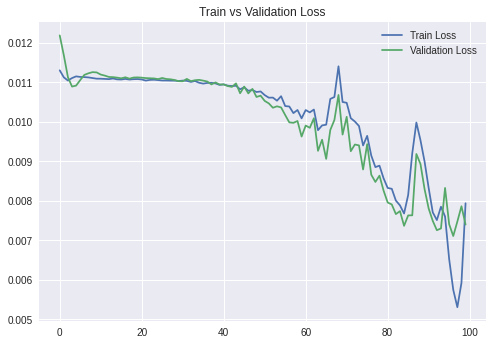

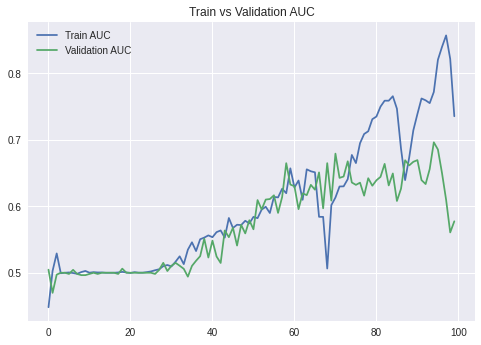


-------------------------------
Best metrics for validation set on Epoch 95:
Loss::      0.0083
AUC::       0.6964
Accuracy::  0.7465
F1::        0.5185
Precision:: 0.4537
Recall::    0.6049
Confusion Matrix:
 [[219  59]
 [ 32  49]]
-------------------------------

Saving predictions from trained model...
Computing Predictions for train set.
dataset size: (2369, 14)
Computing Predictions for validation set.
dataset size: (359, 14)
Computing Predictions for test set.
dataset size: (372, 14)


SUBJECT IMAGE_DATA_ID ORIENTATION SLICE  VALID_IMAGE GROUP  \
3     941_S_4420       I294867     coronal    95         True  EMCI   
8     941_S_4255       I261061     coronal    95         True    CN   
9     941_S_4187       I258653     coronal    95         True  LMCI   
11    941_S_4066       I241396     coronal    95         True    CN   
12    941_S_4036       I236982     coronal    95         True  EMCI   
...          ...           ...         ...   ...          ...   ...   
3709  002_S_4213       I362924       axial    14         True    CN   
3721  002_S_0413       I649030       axial    14         True    CN   
3722  002_S_0413       I312701       axial    14         True    CN   
3723  002_S_0413       I424741       axial    14         True    CN   
3724  002_S_0413       I373133       axial    14         True    CN   

     MACRO_GROUP SEX  AGE                                         IMAGE_PATH  \
3              1   M   81  /content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...   
8              0   M   73  /content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...   
9              1   M   62  /content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...   
11             0   F   79  /content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...   
12             1   M   74  /content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...   
...          ...  ..  ...                                                ...   
3709           0   F   79  /content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...   
3721           0   F   85  /content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...   
3722           0   F   82  /content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...   
3723           0   F   84  /content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...   
3724           0   F   83  /content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...   

                                    ORIGINAL_IMAGE_PATH DATASET  MAIN_SLICE  \
3     /content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...   train          95   
8     /content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...   train          95   
9     /content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...   train          95   
11    /content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...   train          95   
12    /content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...   train          95   
...                                                 ...     ...         ...   
3709  /content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...    test          14   
3721  /content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...    test          14   
3722  /content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...    test          14   
3723  /content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...    test          14   
3724  /content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...    test          14   

        SLICE_ID  CNN_LABEL  CNN_SCORE orientation  slice     RUN_ID  
3     I294867_95       True   0.731918     coronal     95  coronal95  
8     I261061_95       True   0.773476     coronal     95  coronal95  
9     I258653_95       True   0.608052     coronal     95  coronal95  
11    I241396_95       True   0.559357     coronal     95  coronal95  
12    I236982_95       True   0.565466     coronal     95  coronal95  
...          ...        ...        ...         ...    ...        ...  
3709  I362924_14      False   0.022686       axial     14    axial14  
3721  I649030_14      False   0.038548       axial     14    axial14  
3722  I312701_14      False   0.038212       axial     14    axial14  
3723  I424741_14      False   0.034558       axial     14    axial14  
3724  I373133_14      False   0.033354       axial     14    axial14  

[9305 rows x 19 columns]

In [26]:
run_experiments_for_ensemble(orientation_and_slices = [('coronal',[95]),('sagittal',[22]),('axial',[14])],
                          model='vgg13',
                          classes=['MCI','CN'],
                          mri_config = {
                            'num_samples':0,
                            'num_rotations':0,
                            'sampling_range':3,
                            'mri_reference':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/reference/PROCESSED_MRI_REFERENCE_ALL_ORIENTATIONS_20211030_2026.csv',
                            'output_path':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/mri/experiments/',
                            },
                          additional_experiment_params = {'lr':0.00007,
                            'batch_size':64,
                            'optimizer':'sgd',
                            'max_epochs':100,
                            'early_stop':35,
                            'prediction_threshold':0.5,
                            'momentum':0.99},
                          save_path = '/content/gdrive/MyDrive/Lucas_Thimoteo/data/PREDICTIONS_VGG13_BN_MCI3.csv')

# Trying Experiments with VGG13 

Training is too unstable.


--------------------------------------------------------------------
--------------------------------------------------------------------
Running coronal - slice:14 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating final reference file for prepared images...
Loading untrained model...
VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), 

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d7820d4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d7820d4d0>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d7820d4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
Traceback (most recent call last):
  File "/usr/local/lib/python3

Loss::      Train 0.0583      Validation 0.3353
AUC::       Train 0.5937      Validation 0.5000
Accuracy::  Train 0.5930      Validation 0.7750
F1::        Train 0.5947      Validation 0.0000
Precision:: Train 0.5742      Validation 0.0000
Recall::    Train 0.6167      Validation 0.0000
Validation Confusion Matrix:
 [[279   0]
 [ 81   0]]

Epoch 1 took 9.89 seconds
---------------------------------------------------------------------
Best validation AUC so far: 0.5000

---------------------------------------------------------------------
Running Epoch 2 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d7820d4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d7820d4d0>
Traceback (most recent call last):
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
Exception ignored in: <function _MultiProcessingDataLoaderIter.__d

Loss::      Train 0.0604      Validation 0.1635
AUC::       Train 0.6178      Validation 0.5000
Accuracy::  Train 0.6128      Validation 0.7750
F1::        Train 0.6597      Validation 0.0000
Precision:: Train 0.5742      Validation 0.0000
Recall::    Train 0.7753      Validation 0.0000
Validation Confusion Matrix:
 [[279   0]
 [ 81   0]]

Epoch 2 took 9.85 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 3 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d7820d4d0>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d7820d4d0>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
    self._shutdown_workers()
AssertionError: can only test a child process
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0500      Validation 0.2017
AUC::       Train 0.6238      Validation 0.5000
Accuracy::  Train 0.6170      Validation 0.7750
F1::        Train 0.6796      Validation 0.0000
Precision:: Train 0.5712      Validation 0.0000
Recall::    Train 0.8389      Validation 0.0000
Validation Confusion Matrix:
 [[279   0]
 [ 81   0]]

Epoch 3 took 9.91 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 4 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d7820d4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d7820d4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0533      Validation 0.1968
AUC::       Train 0.6252      Validation 0.5000
Accuracy::  Train 0.6179      Validation 0.7750
F1::        Train 0.6848      Validation 0.0000
Precision:: Train 0.5701      Validation 0.0000
Recall::    Train 0.8571      Validation 0.0000
Validation Confusion Matrix:
 [[279   0]
 [ 81   0]]

Epoch 4 took 9.86 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 5 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d7820d4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d7820d4d0>
    if w.is_alive():
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    assert self._parent_pid == os.getpid(), 'can only test a child process'
    if w.is_alive():
AssertionError: can only test a child process
  File "/usr/lib/pytho

Loss::      Train 0.0529      Validation 0.1714
AUC::       Train 0.6241      Validation 0.4982
Accuracy::  Train 0.6162      Validation 0.7722
F1::        Train 0.6881      Validation 0.0000
Precision:: Train 0.5672      Validation 0.0000
Recall::    Train 0.8746      Validation 0.0000
Validation Confusion Matrix:
 [[278   1]
 [ 81   0]]

Epoch 5 took 9.85 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 6 of  100
Loss::      Train 0.0553      Validation 0.0897
AUC::       Train 0.5810      Validation 0.4892
Accuracy::  Train 0.5719      Validation 0.7583
F1::        Train 0.6629      Validation 0.0000
Precision:: Train 0.5357      Validation 0.0000
Recall::    Train 0.8693      Validation 0.0000
Validation Confusion Matrix:
 [[273   6]
 [ 81   0]]

Epoch 6 took 9.77 seconds
---------------------------------------------------------------------

----------------------------

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d7820d4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d7820d4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0384      Validation 0.0442
AUC::       Train 0.6166      Validation 0.5000
Accuracy::  Train 0.6162      Validation 0.7750
F1::        Train 0.6134      Validation 0.0000
Precision:: Train 0.5987      Validation 0.0000
Recall::    Train 0.6289      Validation 0.0000
Validation Confusion Matrix:
 [[279   0]
 [ 81   0]]

Epoch 23 took 9.87 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 24 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d7820d4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d7820d4d0>
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0373      Validation 0.0292
AUC::       Train 0.6433      Validation 0.5000
Accuracy::  Train 0.6390      Validation 0.7750
F1::        Train 0.6762      Validation 0.0000
Precision:: Train 0.5976      Validation 0.0000
Recall::    Train 0.7787      Validation 0.0000
Validation Confusion Matrix:
 [[279   0]
 [ 81   0]]

Epoch 24 took 9.87 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 25 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d7820d4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d7820d4d0>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
AssertionError: can only test a child process
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0363      Validation 0.0239
AUC::       Train 0.6409      Validation 0.5147
Accuracy::  Train 0.6356      Validation 0.7639
F1::        Train 0.6828      Validation 0.1053
Precision:: Train 0.5901      Validation 0.3571
Recall::    Train 0.8101      Validation 0.0617
Validation Confusion Matrix:
 [[270   9]
 [ 76   5]]

Epoch 25 took 9.88 seconds
---------------------------------------------------------------------
Best validation AUC so far: 0.5147

---------------------------------------------------------------------
Running Epoch 26 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d7820d4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d7820d4d0>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d7820d4d0>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/

Loss::      Train 0.0347      Validation 0.0220
AUC::       Train 0.6551      Validation 0.5175
Accuracy::  Train 0.6495      Validation 0.7750
F1::        Train 0.6964      Validation 0.0899
Precision:: Train 0.5997      Validation 0.5000
Recall::    Train 0.8301      Validation 0.0494
Validation Confusion Matrix:
 [[275   4]
 [ 77   4]]

Epoch 26 took 9.79 seconds
---------------------------------------------------------------------
Best validation AUC so far: 0.5175

---------------------------------------------------------------------
Running Epoch 27 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d7820d4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d7820d4d0>
AssertionError: can only test a child process
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0347      Validation 0.0194
AUC::       Train 0.6657      Validation 0.5623
Accuracy::  Train 0.6584      Validation 0.7833
F1::        Train 0.7180      Validation 0.2500
Precision:: Train 0.5980      Validation 0.5652
Recall::    Train 0.8981      Validation 0.1605
Validation Confusion Matrix:
 [[269  10]
 [ 68  13]]

Epoch 27 took 9.87 seconds
---------------------------------------------------------------------
Best validation AUC so far: 0.5623

---------------------------------------------------------------------
Running Epoch 28 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d7820d4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d7820d4d0>
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
Traceback (most recent call last):
    assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
AssertionError: can only test a child process
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0340      Validation 0.0202
AUC::       Train 0.6754      Validation 0.7362
Accuracy::  Train 0.6685      Validation 0.8083
F1::        Train 0.7228      Validation 0.5868
Precision:: Train 0.6072      Validation 0.5698
Recall::    Train 0.8929      Validation 0.6049
Validation Confusion Matrix:
 [[242  37]
 [ 32  49]]

Epoch 28 took 9.90 seconds
---------------------------------------------------------------------
Best validation AUC so far: 0.7362

---------------------------------------------------------------------
Running Epoch 29 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d7820d4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d7820d4d0>
    if w.is_alive():
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    assert self._parent_pid == os.getpid(), 'can only test a child process'
    self._shutdown_workers()
AssertionError: can only test a child process
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0341      Validation 0.0223
AUC::       Train 0.6864      Validation 0.6221
Accuracy::  Train 0.6782      Validation 0.7944
F1::        Train 0.7397      Validation 0.4032
Precision:: Train 0.6080      Validation 0.5814
Recall::    Train 0.9443      Validation 0.3086
Validation Confusion Matrix:
 [[261  18]
 [ 56  25]]

Epoch 29 took 9.90 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 30 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d7820d4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d7820d4d0>
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
AssertionError: can only test a child process
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0337      Validation 0.0309
AUC::       Train 0.6861      Validation 0.5368
Accuracy::  Train 0.6811      Validation 0.7778
F1::        Train 0.7192      Validation 0.1667
Precision:: Train 0.6269      Validation 0.5333
Recall::    Train 0.8432      Validation 0.0988
Validation Confusion Matrix:
 [[272   7]
 [ 73   8]]

Epoch 30 took 9.86 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 31 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d7820d4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d7820d4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0337      Validation 0.0349
AUC::       Train 0.6724      Validation 0.5263
Accuracy::  Train 0.6668      Validation 0.7750
F1::        Train 0.7115      Validation 0.1290
Precision:: Train 0.6126      Validation 0.5000
Recall::    Train 0.8484      Validation 0.0741
Validation Confusion Matrix:
 [[273   6]
 [ 75   6]]

Epoch 31 took 9.83 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 32 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d7820d4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d7820d4d0>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
Traceback (most recent call last):
    if w.is_alive():
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    self._shutdown_workers()
    assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
AssertionError: can only test a child process
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0334      Validation 0.0267
AUC::       Train 0.6755      Validation 0.5167
Accuracy::  Train 0.6702      Validation 0.7806
F1::        Train 0.7123      Validation 0.0706
Precision:: Train 0.6166      Validation 0.7500
Recall::    Train 0.8432      Validation 0.0370
Validation Confusion Matrix:
 [[278   1]
 [ 78   3]]

Epoch 32 took 9.90 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 33 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d7820d4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d7820d4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0325      Validation 0.0278
AUC::       Train 0.6874      Validation 0.5430
Accuracy::  Train 0.6833      Validation 0.7806
F1::        Train 0.7146      Validation 0.1856
Precision:: Train 0.6339      Validation 0.5625
Recall::    Train 0.8188      Validation 0.1111
Validation Confusion Matrix:
 [[272   7]
 [ 72   9]]

Epoch 33 took 9.93 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 34 of  100
Loss::      Train 0.0298      Validation 0.0248
AUC::       Train 0.7360      Validation 0.5518
Accuracy::  Train 0.7339      Validation 0.7806
F1::        Train 0.7453      Validation 0.2178
Precision:: Train 0.6945      Validation 0.5500
Recall::    Train 0.8040      Validation 0.1358
Validation Confusion Matrix:
 [[270   9]
 [ 70  11]]

Epoch 34 took 9.77 seconds
---------------------------------------------------------------------

-------------------------

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d7820d4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d7820d4d0>
    if w.is_alive():
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d7820d4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
    assert self._parent_pid == os.getpid(), 'can o

Loss::      Train 0.0012      Validation 0.0861
AUC::       Train 0.9923      Validation 0.7013
Accuracy::  Train 0.9924      Validation 0.8222
F1::        Train 0.9921      Validation 0.5493
Precision:: Train 0.9939      Validation 0.6393
Recall::    Train 0.9904      Validation 0.4815
Validation Confusion Matrix:
 [[257  22]
 [ 42  39]]

Epoch 50 took 9.93 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 51 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d7820d4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d7820d4d0>
    assert self._parent_pid == os.getpid(), 'can only test a child process'
Traceback (most recent call last):
AssertionError: can only test a child process
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0015      Validation 0.0805
AUC::       Train 0.9916      Validation 0.8162
Accuracy::  Train 0.9916      Validation 0.8306
F1::        Train 0.9913      Validation 0.6772
Precision:: Train 0.9913      Validation 0.5926
Recall::    Train 0.9913      Validation 0.7901
Validation Confusion Matrix:
 [[235  44]
 [ 17  64]]

Epoch 51 took 9.91 seconds
---------------------------------------------------------------------
Best validation AUC so far: 0.8162

---------------------------------------------------------------------
Running Epoch 52 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d7820d4d0>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d7820d4d0>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    self._shutdown_workers()
    assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in

Loss::      Train 0.0011      Validation 0.1091
AUC::       Train 0.9936      Validation 0.7230
Accuracy::  Train 0.9937      Validation 0.8083
F1::        Train 0.9935      Validation 0.5714
Precision:: Train 0.9948      Validation 0.5750
Recall::    Train 0.9922      Validation 0.5679
Validation Confusion Matrix:
 [[245  34]
 [ 35  46]]

Epoch 52 took 9.88 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 53 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d7820d4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d7820d4d0>
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0028      Validation 0.0871
AUC::       Train 0.9853      Validation 0.6740
Accuracy::  Train 0.9852      Validation 0.8139
F1::        Train 0.9848      Validation 0.5037
Precision:: Train 0.9827      Validation 0.6296
Recall::    Train 0.9869      Validation 0.4198
Validation Confusion Matrix:
 [[259  20]
 [ 47  34]]

Epoch 53 took 9.92 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 54 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d7820d4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d7820d4d0>
    assert self._parent_pid == os.getpid(), 'can only test a child process'
Traceback (most recent call last):
AssertionError: can only test a child process
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
Exception ignored in: <function _MultiProce

Loss::      Train 0.0013      Validation 0.0921
AUC::       Train 0.9936      Validation 0.7838
Accuracy::  Train 0.9937      Validation 0.8278
F1::        Train 0.9935      Validation 0.6477
Precision:: Train 0.9956      Validation 0.6000
Recall::    Train 0.9913      Validation 0.7037
Validation Confusion Matrix:
 [[241  38]
 [ 24  57]]

Epoch 54 took 9.89 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 55 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d7820d4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d7820d4d0>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d7820d4d0>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/

Loss::      Train 0.0021      Validation 0.0976
AUC::       Train 0.9929      Validation 0.6836
Accuracy::  Train 0.9928      Validation 0.8083
F1::        Train 0.9926      Validation 0.5175
Precision:: Train 0.9905      Validation 0.5968
Recall::    Train 0.9948      Validation 0.4568
Validation Confusion Matrix:
 [[254  25]
 [ 44  37]]

Epoch 55 took 9.87 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 56 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d7820d4d0>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d7820d4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    self._shutdown_workers()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d7820d4d0>
    if w.is_alive():
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'

Loss::      Train 0.0025      Validation 0.0911
AUC::       Train 0.9866      Validation 0.6882
Accuracy::  Train 0.9865      Validation 0.8222
F1::        Train 0.9861      Validation 0.5294
Precision:: Train 0.9835      Validation 0.6545
Recall::    Train 0.9887      Validation 0.4444
Validation Confusion Matrix:
 [[260  19]
 [ 45  36]]

Epoch 56 took 9.90 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 57 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d7820d4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d7820d4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0011      Validation 0.0868
AUC::       Train 0.9945      Validation 0.7346
Accuracy::  Train 0.9945      Validation 0.8194
F1::        Train 0.9943      Validation 0.5912
Precision:: Train 0.9956      Validation 0.6026
Recall::    Train 0.9930      Validation 0.5802
Validation Confusion Matrix:
 [[248  31]
 [ 34  47]]

Epoch 57 took 9.83 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 58 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d7820d4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d7820d4d0>
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
Traceback (most recent call last):
AssertionError: can only test a child process
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0002      Validation 0.1558
AUC::       Train 0.9992      Validation 0.6398
Accuracy::  Train 0.9992      Validation 0.8083
F1::        Train 0.9991      Validation 0.4390
Precision:: Train 0.9991      Validation 0.6429
Recall::    Train 0.9991      Validation 0.3333
Validation Confusion Matrix:
 [[264  15]
 [ 54  27]]

Epoch 58 took 9.94 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 59 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d7820d4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d7820d4d0>
AssertionError: can only test a child process
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0003      Validation 0.1343
AUC::       Train 0.9992      Validation 0.7680
Accuracy::  Train 0.9992      Validation 0.8306
F1::        Train 0.9991      Validation 0.6347
Precision:: Train 0.9991      Validation 0.6163
Recall::    Train 0.9991      Validation 0.6543
Validation Confusion Matrix:
 [[246  33]
 [ 28  53]]

Epoch 59 took 9.88 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 60 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d7820d4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d7820d4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
    self._shutdown_workers()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in

Loss::      Train 0.0011      Validation 0.0972
AUC::       Train 0.9945      Validation 0.6352
Accuracy::  Train 0.9945      Validation 0.7944
F1::        Train 0.9943      Validation 0.4308
Precision:: Train 0.9939      Validation 0.5714
Recall::    Train 0.9948      Validation 0.3457
Validation Confusion Matrix:
 [[258  21]
 [ 53  28]]

Epoch 60 took 9.90 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 61 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d7820d4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d7820d4d0>
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d7820d4d0>
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3

Loss::      Train 0.0031      Validation 0.0590
AUC::       Train 0.9819      Validation 0.7855
Accuracy::  Train 0.9819      Validation 0.8306
F1::        Train 0.9813      Validation 0.6514
Precision:: Train 0.9800      Validation 0.6064
Recall::    Train 0.9826      Validation 0.7037
Validation Confusion Matrix:
 [[242  37]
 [ 24  57]]

Epoch 61 took 9.94 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 62 of  100
Loss::      Train 0.0004      Validation 0.0902
AUC::       Train 0.9983      Validation 0.7963
Accuracy::  Train 0.9983      Validation 0.8472
F1::        Train 0.9983      Validation 0.6746
Precision:: Train 0.9983      Validation 0.6477
Recall::    Train 0.9983      Validation 0.7037
Validation Confusion Matrix:
 [[248  31]
 [ 24  57]]

Epoch 62 took 9.79 seconds
---------------------------------------------------------------------

-------------------------

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d7820d4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d7820d4d0>
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
Traceback (most recent call last):
AssertionError: can only test a child process
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0000      Validation 0.1659
AUC::       Train 1.0000      Validation 0.7750
Accuracy::  Train 1.0000      Validation 0.8278
F1::        Train 1.0000      Validation 0.6395
Precision:: Train 1.0000      Validation 0.6044
Recall::    Train 1.0000      Validation 0.6790
Validation Confusion Matrix:
 [[243  36]
 [ 26  55]]

Epoch 76 took 9.89 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 77 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d7820d4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d7820d4d0>
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    assert self._parent_pid == os.getpid(), 'can only test a child process'
    self._shutdown_workers()
AssertionError: can only test a child process
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0000      Validation 0.1678
AUC::       Train 1.0000      Validation 0.7891
Accuracy::  Train 1.0000      Validation 0.8361
F1::        Train 1.0000      Validation 0.6590
Precision:: Train 1.0000      Validation 0.6196
Recall::    Train 1.0000      Validation 0.7037
Validation Confusion Matrix:
 [[244  35]
 [ 24  57]]

Epoch 77 took 9.89 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 78 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d7820d4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d7820d4d0>
    self._shutdown_workers()
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d7820d4d0>
    self._shutdown_workers()
Traceback (most recent call last):
    if w.is_alive():
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid

Loss::      Train 0.0000      Validation 0.1644
AUC::       Train 1.0000      Validation 0.7935
Accuracy::  Train 1.0000      Validation 0.8361
F1::        Train 1.0000      Validation 0.6629
Precision:: Train 1.0000      Validation 0.6170
Recall::    Train 1.0000      Validation 0.7160
Validation Confusion Matrix:
 [[243  36]
 [ 23  58]]

Epoch 78 took 9.93 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 79 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d7820d4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d7820d4d0>
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
Traceback (most recent call last):
    if w.is_alive():
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
AssertionError: can only test a child process
  File "/usr/lib/pytho

Loss::      Train 0.0000      Validation 0.1646
AUC::       Train 1.0000      Validation 0.7891
Accuracy::  Train 1.0000      Validation 0.8361
F1::        Train 1.0000      Validation 0.6590
Precision:: Train 1.0000      Validation 0.6196
Recall::    Train 1.0000      Validation 0.7037
Validation Confusion Matrix:
 [[244  35]
 [ 24  57]]

Epoch 79 took 9.89 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 80 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d7820d4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d7820d4d0>
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
Traceback (most recent call last):
AssertionError: can only test a child process
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0000      Validation 0.1881
AUC::       Train 1.0000      Validation 0.7830
Accuracy::  Train 1.0000      Validation 0.8333
F1::        Train 1.0000      Validation 0.6512
Precision:: Train 1.0000      Validation 0.6154
Recall::    Train 1.0000      Validation 0.6914
Validation Confusion Matrix:
 [[244  35]
 [ 25  56]]

Epoch 80 took 9.83 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 81 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d7820d4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d7820d4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0000      Validation 0.1884
AUC::       Train 1.0000      Validation 0.7873
Accuracy::  Train 1.0000      Validation 0.8333
F1::        Train 1.0000      Validation 0.6552
Precision:: Train 1.0000      Validation 0.6129
Recall::    Train 1.0000      Validation 0.7037
Validation Confusion Matrix:
 [[243  36]
 [ 24  57]]

Epoch 81 took 9.91 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 82 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d7820d4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d7820d4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0000      Validation 0.2277
AUC::       Train 1.0000      Validation 0.6846
Accuracy::  Train 1.0000      Validation 0.8167
F1::        Train 1.0000      Validation 0.5217
Precision:: Train 1.0000      Validation 0.6316
Recall::    Train 1.0000      Validation 0.4444
Validation Confusion Matrix:
 [[258  21]
 [ 45  36]]

Epoch 82 took 9.96 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 83 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d7820d4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d7820d4d0>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
Traceback (most recent call last):
    assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
AssertionError: can only test a child process
    self._shutdown_workers()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d7820d4d0>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/d

Loss::      Train 0.0154      Validation 0.0521
AUC::       Train 0.9156      Validation 0.6203
Accuracy::  Train 0.9156      Validation 0.7917
F1::        Train 0.9129      Validation 0.4000
Precision:: Train 0.9129      Validation 0.5682
Recall::    Train 0.9129      Validation 0.3086
Validation Confusion Matrix:
 [[260  19]
 [ 56  25]]

Epoch 83 took 9.92 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 84 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d7820d4d0>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d7820d4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d7820d4d0>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    if w.is_alive():
  File "/usr/local/

Loss::      Train 0.0047      Validation 0.0942
AUC::       Train 0.9707      Validation 0.6344
Accuracy::  Train 0.9709      Validation 0.8000
F1::        Train 0.9698      Validation 0.4286
Precision:: Train 0.9753      Validation 0.6000
Recall::    Train 0.9643      Validation 0.3333
Validation Confusion Matrix:
 [[261  18]
 [ 54  27]]

Epoch 84 took 9.89 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 85 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d7820d4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d7820d4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child

Loss::      Train 0.0013      Validation 0.1019
AUC::       Train 0.9916      Validation 0.7162
Accuracy::  Train 0.9916      Validation 0.8250
F1::        Train 0.9913      Validation 0.5714
Precision:: Train 0.9913      Validation 0.6364
Recall::    Train 0.9913      Validation 0.5185
Validation Confusion Matrix:
 [[255  24]
 [ 39  42]]

Epoch 85 took 9.90 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 86 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d7820d4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d7820d4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0013      Validation 0.0901
AUC::       Train 0.9941      Validation 0.7583
Accuracy::  Train 0.9941      Validation 0.8222
F1::        Train 0.9939      Validation 0.6190
Precision:: Train 0.9930      Validation 0.5977
Recall::    Train 0.9948      Validation 0.6420
Validation Confusion Matrix:
 [[244  35]
 [ 29  52]]

Epoch 86 took 9.95 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 87 of  100
Loss::      Train 0.0010      Validation 0.1174
AUC::       Train 0.9936      Validation 0.7618
Accuracy::  Train 0.9937      Validation 0.8278
F1::        Train 0.9935      Validation 0.6265
Precision:: Train 0.9956      Validation 0.6118
Recall::    Train 0.9913      Validation 0.6420
Validation Confusion Matrix:
 [[246  33]
 [ 29  52]]

Epoch 87 took 9.82 seconds
---------------------------------------------------------------------

-------------------------

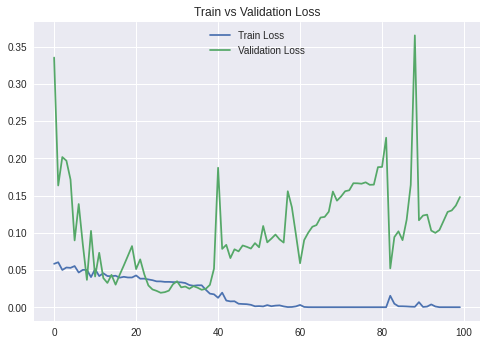

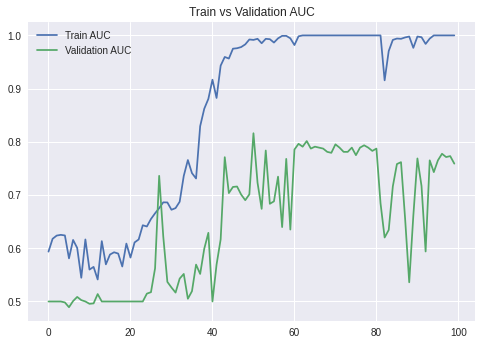


-------------------------------
Best metrics for validation set on Epoch 51:
Loss::      0.0805
AUC::       0.8162
Accuracy::  0.8306
F1::        0.6772
Precision:: 0.5926
Recall::    0.7901
Confusion Matrix:
 [[235  44]
 [ 17  64]]
-------------------------------


--------------------------------------------------------------------
--------------------------------------------------------------------
Running coronal - slice:15 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating final reference file for prepared images...
Loading untrained model...
VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d7820d4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d7820d4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
Exception ignored in: <function _MultiProce

Loss::      Train 0.0591      Validation 0.2485
AUC::       Train 0.5670      Validation 0.5000
Accuracy::  Train 0.5664      Validation 0.7750
F1::        Train 0.5670      Validation 0.0000
Precision:: Train 0.5489      Validation 0.0000
Recall::    Train 0.5862      Validation 0.0000
Validation Confusion Matrix:
 [[279   0]
 [ 81   0]]

Epoch 1 took 9.91 seconds
---------------------------------------------------------------------
Best validation AUC so far: 0.5000

---------------------------------------------------------------------
Running Epoch 2 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d7820d4d0>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d7820d4d0>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child

Loss::      Train 0.0581      Validation 0.1644
AUC::       Train 0.6292      Validation 0.5000
Accuracy::  Train 0.6246      Validation 0.7750
F1::        Train 0.6659      Validation 0.0000
Precision:: Train 0.5851      Validation 0.0000
Recall::    Train 0.7726      Validation 0.0000
Validation Confusion Matrix:
 [[279   0]
 [ 81   0]]

Epoch 2 took 9.90 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 3 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d7820d4d0>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d7820d4d0>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    if w.is_alive():
    assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in

Loss::      Train 0.0509      Validation 0.1374
AUC::       Train 0.6300      Validation 0.5000
Accuracy::  Train 0.6234      Validation 0.7750
F1::        Train 0.6832      Validation 0.0000
Precision:: Train 0.5763      Validation 0.0000
Recall::    Train 0.8389      Validation 0.0000
Validation Confusion Matrix:
 [[279   0]
 [ 81   0]]

Epoch 3 took 9.89 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 4 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d7820d4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d7820d4d0>
AssertionError: can only test a child process
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d7820d4d0>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
Traceback (most recent call last):
    self._shutdown_workers()
  File "/usr/local/lib/python3

Loss::      Train 0.0520      Validation 0.1287
AUC::       Train 0.6109      Validation 0.5000
Accuracy::  Train 0.6035      Validation 0.7750
F1::        Train 0.6734      Validation 0.0000
Precision:: Train 0.5601      Validation 0.0000
Recall::    Train 0.8441      Validation 0.0000
Validation Confusion Matrix:
 [[279   0]
 [ 81   0]]

Epoch 4 took 9.92 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 5 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d7820d4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d7820d4d0>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d7820d4d0>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
Traceback (most recent call last):
    self._shutdown_workers()
  File "/usr/local/lib/python3

Loss::      Train 0.0508      Validation 0.0881
AUC::       Train 0.5991      Validation 0.5000
Accuracy::  Train 0.5930      Validation 0.7750
F1::        Train 0.6535      Validation 0.0000
Precision:: Train 0.5559      Validation 0.0000
Recall::    Train 0.7927      Validation 0.0000
Validation Confusion Matrix:
 [[279   0]
 [ 81   0]]

Epoch 5 took 9.97 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 6 of  100
Loss::      Train 0.0485      Validation 0.0697
AUC::       Train 0.5958      Validation 0.5000
Accuracy::  Train 0.5892      Validation 0.7750
F1::        Train 0.6551      Validation 0.0000
Precision:: Train 0.5519      Validation 0.0000
Recall::    Train 0.8057      Validation 0.0000
Validation Confusion Matrix:
 [[279   0]
 [ 81   0]]

Epoch 6 took 9.79 seconds
---------------------------------------------------------------------

----------------------------

Exception ignored in: <function WeakSet.__init__.<locals>._remove at 0x7f3ee463ba70>
Traceback (most recent call last):
  File "/usr/lib/python3.7/_weakrefset.py", line 38, in _remove
    def _remove(item, selfref=ref(self)):
KeyboardInterrupt
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d7820d4d0>
Exception ignored in: <function WeakSet.__init__.<locals>._remove at 0x7f3ee463ba70>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.7/_weakrefset.py", line 38, in _remove
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    def _remove(item, selfref=ref(self)):
KeyboardInterrupt
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d7820d4d0>
    self._shutdown_workers()
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()


KeyboardInterrupt: ignored

In [ ]:
df_test_vgg13 = run_mris_experiments(
                          orientation_and_slices = [
                                         ('coronal',list(range(14,17)))
                                         ],
                          num_repeats = 1,
                          model='vgg13_bn',
                          classes=['MCI','CN'],
                          mri_config = {
                            'num_samples':0,
                            'num_rotations':0,
                            'sampling_range':1,
                            'mri_reference':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/reference/PROCESSED_MRI_REFERENCE_ALL_ORIENTATIONS_20211030_2026.csv',
                            'output_path':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/mri/experiments/',
                          },
                          additional_experiment_params = {'lr':0.0005,
                            'batch_size':16,
                            'optimizer':'adam',
                            'max_epochs':100,
                            'early_stop':30,
                            'prediction_threshold':0.5},
                          save_path = '/content/gdrive/MyDrive/Lucas_Thimoteo/data/TEST_MCI_VGG13_CORONAL1_LR01.csv')

Using SGD with Momentum seems to bring better results.


--------------------------------------------------------------------
--------------------------------------------------------------------
Running coronal - slice:14 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating final reference file for prepared images...
Loading untrained model...
VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), 

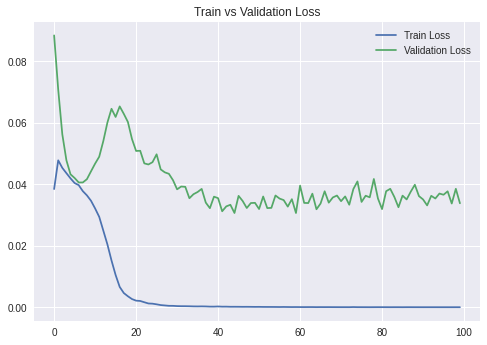

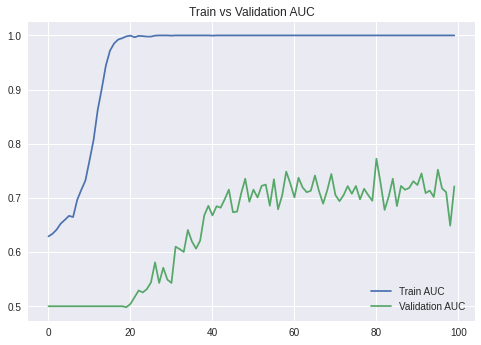


-------------------------------
Best metrics for validation set on Epoch 81:
Loss::      0.0319
AUC::       0.7724
Accuracy::  0.8306
F1::        0.6391
Precision:: 0.6136
Recall::    0.6667
Confusion Matrix:
 [[245  34]
 [ 27  54]]
-------------------------------


--------------------------------------------------------------------
--------------------------------------------------------------------
Running coronal - slice:15 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating final reference file for prepared images...
Loading untrained model...
VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1

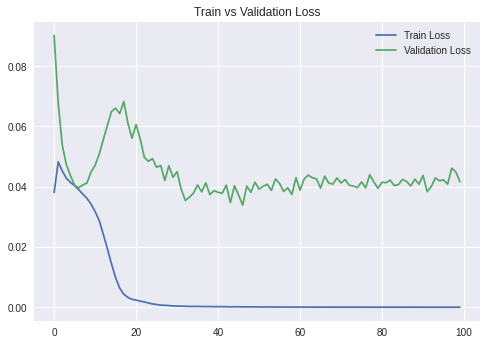

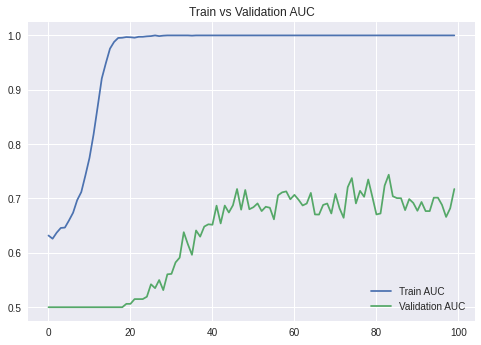


-------------------------------
Best metrics for validation set on Epoch 84:
Loss::      0.0404
AUC::       0.7437
Accuracy::  0.7861
F1::        0.5838
Precision:: 0.5192
Recall::    0.6667
Confusion Matrix:
 [[229  50]
 [ 27  54]]
-------------------------------


--------------------------------------------------------------------
--------------------------------------------------------------------
Running coronal - slice:16 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating final reference file for prepared images...
Loading untrained model...
VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1

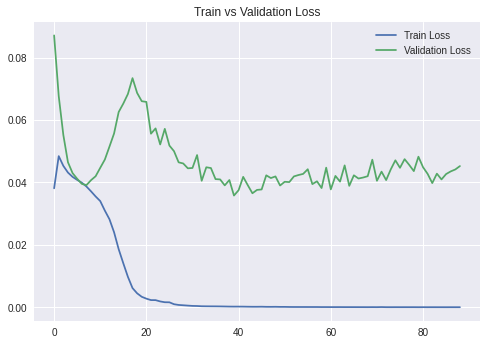

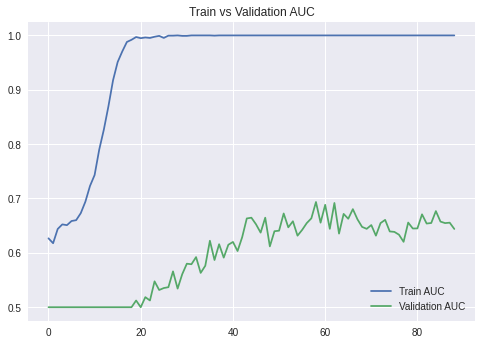


-------------------------------
Best metrics for validation set on Epoch 59:
Loss::      0.0382
AUC::       0.6935
Accuracy::  0.7694
F1::        0.5202
Precision:: 0.4891
Recall::    0.5556
Confusion Matrix:
 [[232  47]
 [ 36  45]]
-------------------------------



In [ ]:
df_test_vgg13 = run_mris_experiments(
                          orientation_and_slices = [
                                         ('coronal',list(range(14,17)))
                                         ],
                          num_repeats = 1,
                          model='vgg13_bn',
                          classes=['MCI','CN'],
                          mri_config = {
                            'num_samples':0,
                            'num_rotations':0,
                            'sampling_range':1,
                            'mri_reference':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/reference/PROCESSED_MRI_REFERENCE_ALL_ORIENTATIONS_20211030_2026.csv',
                            'output_path':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/mri/experiments/',
                          },
                          additional_experiment_params = {'lr':0.0001,
                            'batch_size':16,
                            'optimizer':'sgd',
                            'max_epochs':100,
                            'early_stop':30,
                            'prediction_threshold':0.5,
                            'momentum':0.99},
                          save_path = '/content/gdrive/MyDrive/Lucas_Thimoteo/data/TEST_MCI_VGG13_CORONAL1_LR01.csv')


--------------------------------------------------------------------
--------------------------------------------------------------------
Running coronal - slice:14 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating final reference file for prepared images...
Loading untrained model...
VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), 

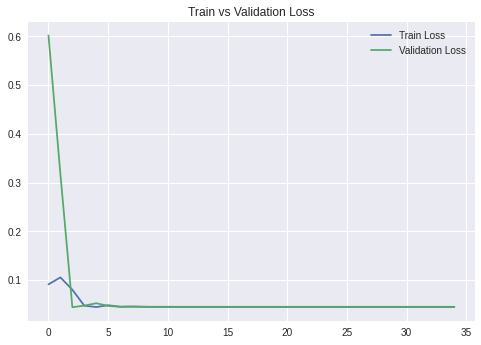

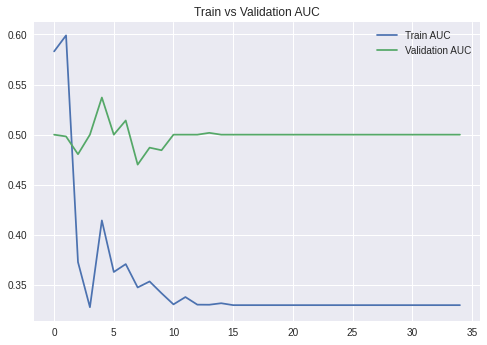


-------------------------------
Best metrics for validation set on Epoch 5:
Loss::      0.0522
AUC::       0.5370
Accuracy::  0.6694
F1::        0.2874
Precision:: 0.2791
Recall::    0.2963
Confusion Matrix:
 [[217  62]
 [ 57  24]]
-------------------------------


--------------------------------------------------------------------
--------------------------------------------------------------------
Running coronal - slice:15 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating final reference file for prepared images...
Loading untrained model...
VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1,

Exception ignored in: <function NpzFile.__del__ at 0x7f3ef8f8c680>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/numpy/lib/npyio.py", line 223, in __del__
    self.close()
  File "/usr/local/lib/python3.7/dist-packages/numpy/lib/npyio.py", line 214, in close
    if self.zip is not None:
AttributeError: 'NpzFile' object has no attribute 'zip'


KeyboardInterrupt: ignored

In [ ]:
df_test_vgg13 = run_mris_experiments(
                          orientation_and_slices = [
                                         ('coronal',list(range(14,17)))
                                         ],
                          num_repeats = 1,
                          model='vgg13_bn',
                          classes=['MCI','CN'],
                          mri_config = {
                            'num_samples':0,
                            'num_rotations':0,
                            'sampling_range':1,
                            'mri_reference':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/reference/PROCESSED_MRI_REFERENCE_ALL_ORIENTATIONS_20211030_2026.csv',
                            'output_path':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/mri/experiments/',
                          },
                          additional_experiment_params = {'lr':0.001,
                            'batch_size':16,
                            'optimizer':'sgd',
                            'max_epochs':100,
                            'early_stop':30,
                            'prediction_threshold':0.5,
                            'momentum':0.99},
                          save_path = '/content/gdrive/MyDrive/Lucas_Thimoteo/data/TEST_MCI_VGG13_CORONAL1_LR01.csv')

In [ ]:
df_test_vgg13 = run_mris_experiments(
                          orientation_and_slices = [
                                         ('coronal',list(range(14,17)))
                                         ],
                          num_repeats = 1,
                          model='vgg13_bn',
                          classes=['MCI','CN'],
                          mri_config = {
                            'num_samples':0,
                            'num_rotations':3,
                            'sampling_range':1,
                            'mri_reference':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/reference/PROCESSED_MRI_REFERENCE_ALL_ORIENTATIONS_20211030_2026.csv',
                            'output_path':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/mri/experiments/',
                          },
                          additional_experiment_params = {'lr':0.0001,
                            'batch_size':16,
                            'optimizer':'sgd',
                            'max_epochs':100,
                            'early_stop':30,
                            'prediction_threshold':0.5,
                            'momentum':0.99},
                          save_path = '/content/gdrive/MyDrive/Lucas_Thimoteo/data/TEST_MCI_VGG13_CORONAL1_LR01.csv')


--------------------------------------------------------------------
--------------------------------------------------------------------
Running coronal - slice:14 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating 2d image rotations...
Creating final reference file for prepared images...
Loading untrained model...
VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kern

Exception ignored in: <function NpzFile.__del__ at 0x7f3ef8f8c680>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/numpy/lib/npyio.py", line 223, in __del__
    self.close()
  File "/usr/local/lib/python3.7/dist-packages/numpy/lib/npyio.py", line 218, in close
    self.fid.close()
KeyboardInterrupt


KeyboardInterrupt: ignored


--------------------------------------------------------------------
--------------------------------------------------------------------
Running coronal - slice:14 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating final reference file for prepared images...
Loading untrained model...
VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), 

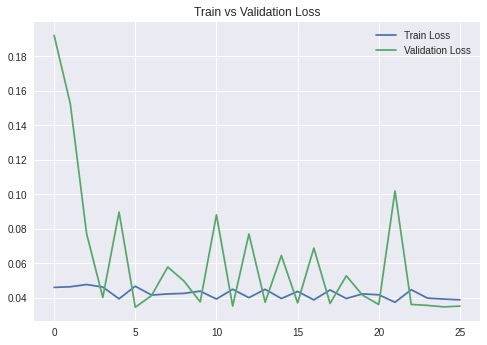

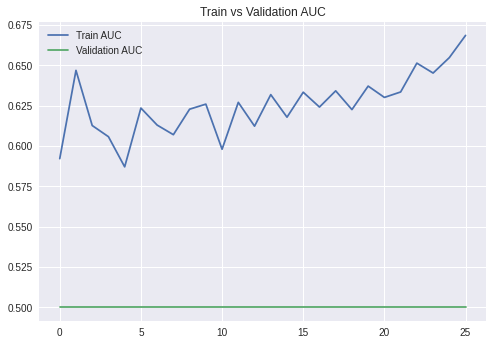


-------------------------------
Best metrics for validation set on Epoch 1:
Loss::      0.1921
AUC::       0.5000
Accuracy::  0.7750
F1::        0.0000
Precision:: 0.0000
Recall::    0.0000
Confusion Matrix:
 [[279   0]
 [ 81   0]]
-------------------------------



In [ ]:
df_test_vgg13 = run_mris_experiments(
                          orientation_and_slices = [
                                         ('coronal', [14])#list(range(14,15)))
                                         ],
                          num_repeats = 1,
                          model='vgg13_bn',
                          classes=['MCI','CN'],
                          mri_config = {
                            'num_samples':0,
                            'num_rotations':0,
                            'sampling_range':1,
                            'mri_reference':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/reference/PROCESSED_MRI_REFERENCE_ALL_ORIENTATIONS_20211030_2026.csv',
                            'output_path':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/mri/experiments/',
                          },
                          additional_experiment_params = {'lr':0.001,
                            'batch_size':16,
                            'optimizer':'sgd',
                            'max_epochs':100,
                            'early_stop':25,
                            'prediction_threshold':0.5,
                            'momentum':0.9},
                          save_path = '/content/gdrive/MyDrive/Lucas_Thimoteo/data/TEST_MCI_VGG13_CORONAL1_LR01.csv')


--------------------------------------------------------------------
--------------------------------------------------------------------
Running coronal - slice:14 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating final reference file for prepared images...
Loading untrained model...
VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), 

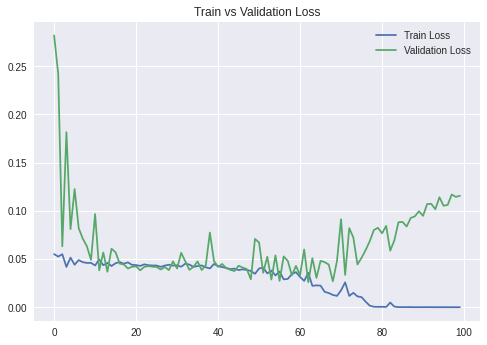

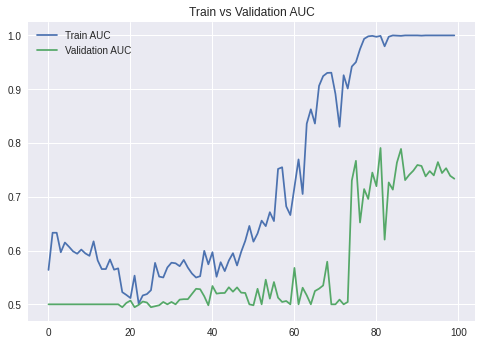


-------------------------------
Best metrics for validation set on Epoch 82:
Loss::      0.0843
AUC::       0.7907
Accuracy::  0.8250
F1::        0.6519
Precision:: 0.5900
Recall::    0.7284
Confusion Matrix:
 [[238  41]
 [ 22  59]]
-------------------------------



In [ ]:
df_test_vgg13 = run_mris_experiments(
                          orientation_and_slices = [
                                         ('coronal', [14])#list(range(14,15)))
                                         ],
                          num_repeats = 1,
                          model='vgg13_bn',
                          classes=['MCI','CN'],
                          mri_config = {
                            'num_samples':0,
                            'num_rotations':0,
                            'sampling_range':1,
                            'mri_reference':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/reference/PROCESSED_MRI_REFERENCE_ALL_ORIENTATIONS_20211030_2026.csv',
                            'output_path':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/mri/experiments/',
                          },
                          additional_experiment_params = {'lr':0.001,
                            'batch_size':16,
                            'optimizer':'sgd',
                            'max_epochs':100,
                            'early_stop':25,
                            'prediction_threshold':0.5,
                            'momentum':0.95},
                          save_path = '/content/gdrive/MyDrive/Lucas_Thimoteo/data/TEST_MCI_VGG13_CORONAL1_LR01.csv')


--------------------------------------------------------------------
--------------------------------------------------------------------
Running coronal - slice:14 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating 2d image rotations...
Creating final reference file for prepared images...
Loading untrained model...
VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kern

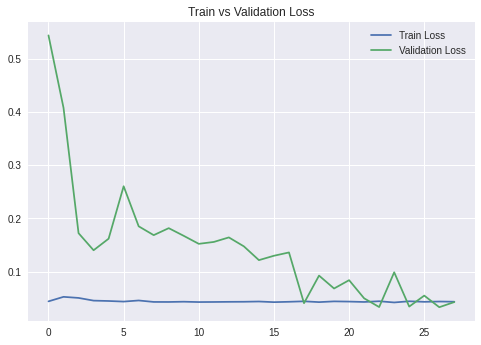

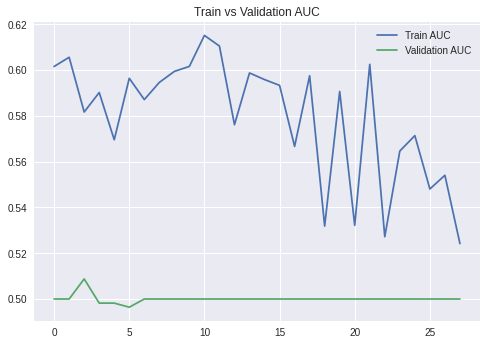


-------------------------------
Best metrics for validation set on Epoch 3:
Loss::      0.1721
AUC::       0.5088
Accuracy::  0.7750
F1::        0.0471
Precision:: 0.5000
Recall::    0.0247
Confusion Matrix:
 [[277   2]
 [ 79   2]]
-------------------------------



In [ ]:
df_test_vgg13 = run_mris_experiments(
                          orientation_and_slices = [
                                         ('coronal', [14])#list(range(14,15)))
                                         ],
                          num_repeats = 1,
                          model='vgg13_bn',
                          classes=['MCI','CN'],
                          mri_config = {
                            'num_samples':0,
                            'num_rotations':2,
                            'sampling_range':1,
                            'mri_reference':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/reference/PROCESSED_MRI_REFERENCE_ALL_ORIENTATIONS_20211030_2026.csv',
                            'output_path':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/mri/experiments/',
                          },
                          additional_experiment_params = {'lr':0.001,
                            'batch_size':16,
                            'optimizer':'sgd',
                            'max_epochs':100,
                            'early_stop':25,
                            'prediction_threshold':0.5,
                            'momentum':0.95},
                          save_path = '/content/gdrive/MyDrive/Lucas_Thimoteo/data/TEST_MCI_VGG13_CORONAL1_LR01.csv')


--------------------------------------------------------------------
--------------------------------------------------------------------
Running coronal - slice:14 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating 2d image rotations...
Creating final reference file for prepared images...
Loading untrained model...
VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kern

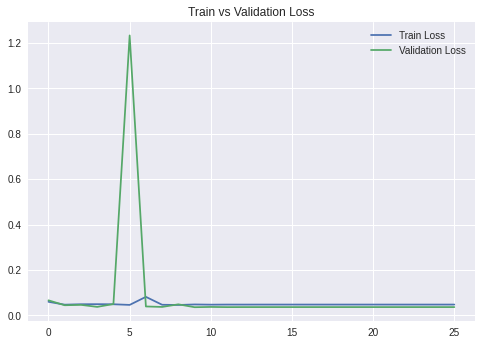

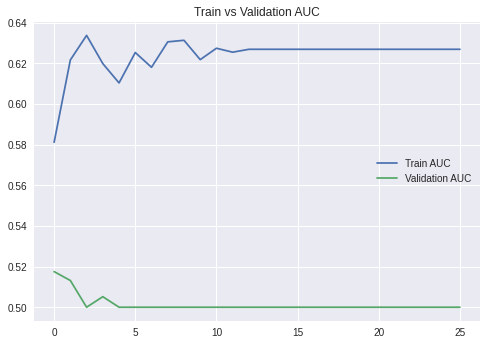


-------------------------------
Best metrics for validation set on Epoch 1:
Loss::      0.0660
AUC::       0.5175
Accuracy::  0.7750
F1::        0.0899
Precision:: 0.5000
Recall::    0.0494
Confusion Matrix:
 [[275   4]
 [ 77   4]]
-------------------------------



In [ ]:
df_test_vgg13 = run_mris_experiments(
                          orientation_and_slices = [
                                         ('coronal', [14])#list(range(14,15)))
                                         ],
                          num_repeats = 1,
                          model='vgg13_bn',
                          classes=['MCI','CN'],
                          mri_config = {
                            'num_samples':0,
                            'num_rotations':3,
                            'sampling_range':1,
                            'mri_reference':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/reference/PROCESSED_MRI_REFERENCE_ALL_ORIENTATIONS_20211030_2026.csv',
                            'output_path':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/mri/experiments/',
                          },
                          additional_experiment_params = {'lr':0.001,
                            'batch_size':16,
                            'optimizer':'sgd',
                            'max_epochs':100,
                            'early_stop':25,
                            'prediction_threshold':0.5,
                            'momentum':0.99},
                          save_path = '/content/gdrive/MyDrive/Lucas_Thimoteo/data/TEST_MCI_VGG13_CORONAL1_LR01.csv')


--------------------------------------------------------------------
--------------------------------------------------------------------
Running coronal - slice:14 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating final reference file for prepared images...
Loading untrained model...
VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), 

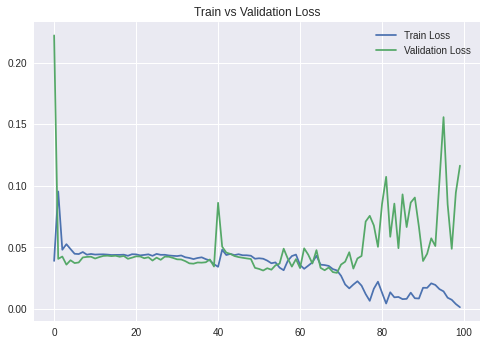

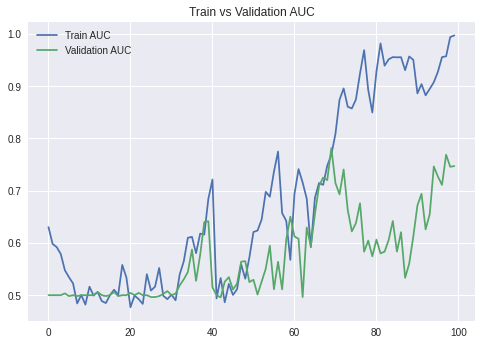


-------------------------------
Best metrics for validation set on Epoch 70:
Loss::      0.0291
AUC::       0.7816
Accuracy::  0.7361
F1::        0.5957
Precision:: 0.4545
Recall::    0.8642
Confusion Matrix:
 [[195  84]
 [ 11  70]]
-------------------------------


--------------------------------------------------------------------
--------------------------------------------------------------------
Running coronal - slice:15 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating final reference file for prepared images...
Loading untrained model...
VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1

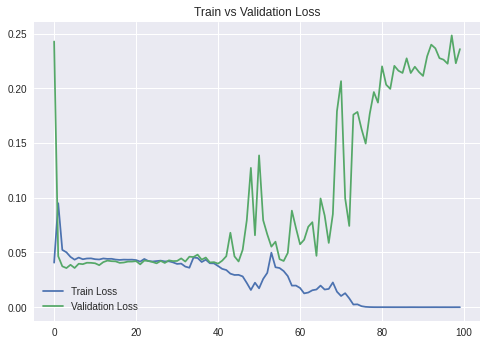

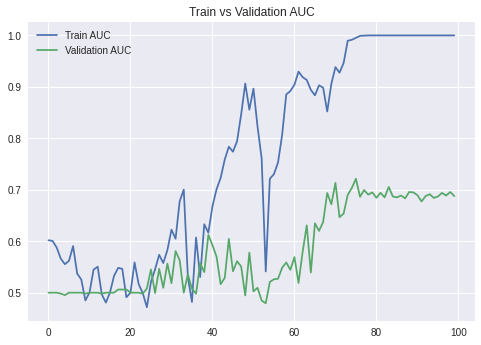


-------------------------------
Best metrics for validation set on Epoch 76:
Loss::      0.1627
AUC::       0.7214
Accuracy::  0.6972
F1::        0.5322
Precision:: 0.4079
Recall::    0.7654
Confusion Matrix:
 [[189  90]
 [ 19  62]]
-------------------------------



In [ ]:
df_test_vgg13 = run_mris_experiments(
                          orientation_and_slices = [
                                         ('coronal',[14,15])
                                         ],
                          num_repeats = 1,
                          model='vgg19_bn',
                          classes=['MCI','CN'],
                          mri_config = {
                            'num_samples':0,
                            'num_rotations':0,
                            'sampling_range':1,
                            'mri_reference':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/reference/PROCESSED_MRI_REFERENCE_ALL_ORIENTATIONS_20211030_2026.csv',
                            'output_path':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/mri/experiments/',
                          },
                          additional_experiment_params = {'lr':0.0001,
                            'batch_size':16,
                            'optimizer':'sgd',
                            'max_epochs':100,
                            'early_stop':30,
                            'prediction_threshold':0.5,
                            'momentum':0.99},
                          save_path = '/content/gdrive/MyDrive/Lucas_Thimoteo/data/TEST_MCI_VGG13_CORONAL1_LR01.csv')


--------------------------------------------------------------------
--------------------------------------------------------------------
Running coronal - slice:0 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating final reference file for prepared images...
Loading untrained model...
VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dila

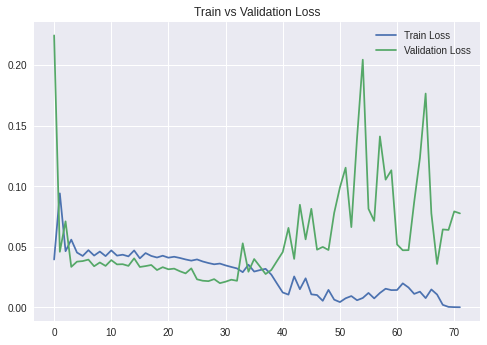

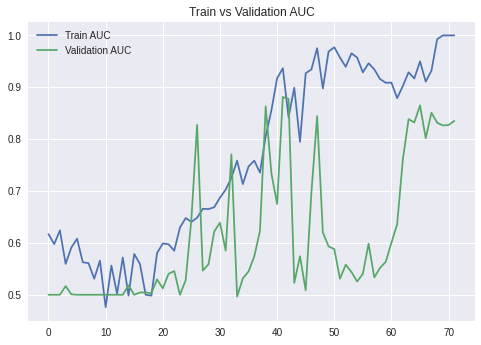


-------------------------------
Best metrics for validation set on Epoch 42:
Loss::      0.0656
AUC::       0.8809
Accuracy::  0.8222
F1::        0.7143
Precision:: 0.5594
Recall::    0.9877
Confusion Matrix:
 [[216  63]
 [  1  80]]
-------------------------------


--------------------------------------------------------------------
--------------------------------------------------------------------
Running coronal - slice:1 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating final reference file for prepared images...
Loading untrained model...
VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, cei

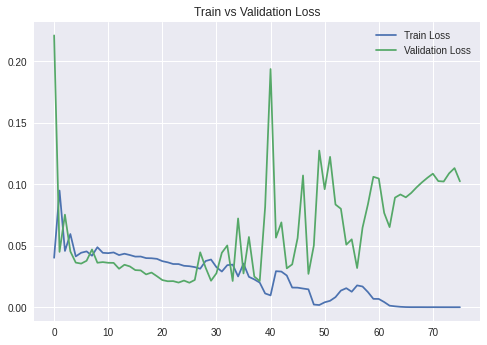

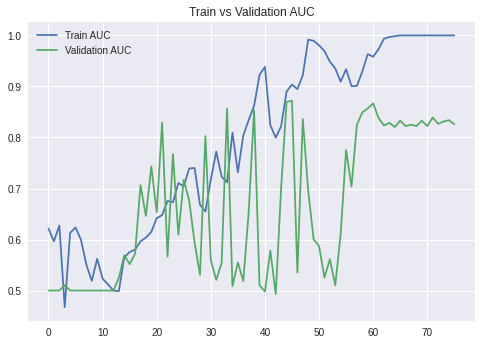


-------------------------------
Best metrics for validation set on Epoch 46:
Loss::      0.0563
AUC::       0.8720
Accuracy::  0.8083
F1::        0.6987
Precision:: 0.5405
Recall::    0.9877
Confusion Matrix:
 [[211  68]
 [  1  80]]
-------------------------------



In [ ]:
df_test_vgg13 = run_mris_experiments(
                          orientation_and_slices = [
                                         ('coronal',[0,1])
                                         ],
                          num_repeats = 1,
                          model='vgg11_bn',
                          classes=['MCI','CN'],
                          mri_config = {
                            'num_samples':0,
                            'num_rotations':0,
                            'sampling_range':1,
                            'mri_reference':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/reference/PROCESSED_MRI_REFERENCE_ALL_ORIENTATIONS_20211030_2026.csv',
                            'output_path':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/mri/experiments/',
                          },
                          additional_experiment_params = {'lr':0.0001,
                            'batch_size':16,
                            'optimizer':'sgd',
                            'max_epochs':100,
                            'early_stop':30,
                            'prediction_threshold':0.5,
                            'momentum':0.99},
                          save_path = '/content/gdrive/MyDrive/Lucas_Thimoteo/data/TEST_MCI_VGG13_CORONAL1_LR01.csv')

In [ ]:
df_results_vgg13_bn_a1 = run_mris_experiments(
                          orientation_and_slices = [
                                         ('axial',list(range(0,50)))
                                         ],
                          num_repeats = 1,
                          model='vgg13_bn',
                          classes=['MCI','CN'],
                          mri_config = {
                            'num_samples':0,
                            'num_rotations':0,
                            'sampling_range':1,
                            'mri_reference':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/reference/PROCESSED_MRI_REFERENCE_ALL_ORIENTATIONS_20211030_2026.csv',
                            'output_path':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/mri/experiments/',
                          },
                          additional_experiment_params = {'lr':0.0001,
                            'batch_size':16,
                            'optimizer':'adam',
                            'max_epochs':100,
                            'early_stop':10,
                            'prediction_threshold':0.5},
                          save_path = '/content/gdrive/MyDrive/Lucas_Thimoteo/data/RESULTS_MCI_VGG13_AXIAL1.csv')

In [ ]:
df_results_vgg13_bn_a1.sort_values("validation_auc",ascending=False)


In [ ]:
df_results_vgg13_bn_a2 = run_mris_experiments(
                          orientation_and_slices = [
                                         ('axial',list(range(0,50)))
                                         ],
                          num_repeats = 1,
                          model='vgg13_bn',
                          classes=['MCI','CN'],
                          mri_config = {
                            'num_samples':0,
                            'num_rotations':0,
                            'sampling_range':1,
                            'mri_reference':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/reference/PROCESSED_MRI_REFERENCE_ALL_ORIENTATIONS_20211030_2026.csv',
                            'output_path':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/mri/experiments/',
                          },
                          additional_experiment_params = {'lr':0.0001,
                            'batch_size':16,
                            'optimizer':'adam',
                            'max_epochs':100,
                            'early_stop':10,
                            'prediction_threshold':0.5},
                          save_path = '/content/gdrive/MyDrive/Lucas_Thimoteo/data/RESULTS_MCI_VGG13_AXIAL2.csv')

In [ ]:
df_results_vgg13_bn_a2.sort_values("validation_auc",ascending=False)

# Shallow CNN


--------------------------------------------------------------------
--------------------------------------------------------------------
Running coronal - slice:0 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating final reference file for prepared images...
Loading untrained model...
NeuralNetwork(
  (features): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, cei

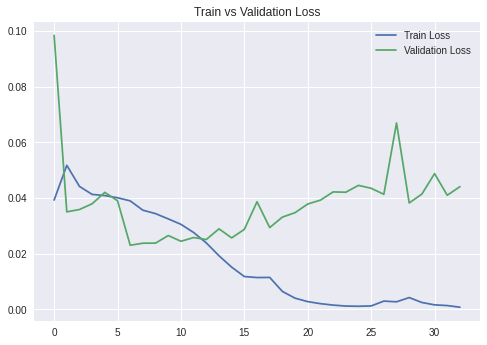

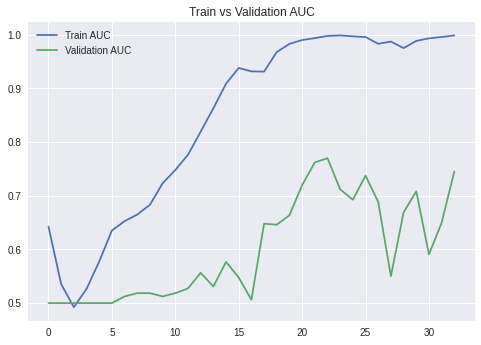


-------------------------------
Best metrics for validation set on Epoch 23:
Loss::      0.0421
AUC::       0.7698
Accuracy::  0.8333
F1::        0.6386
Precision:: 0.6235
Recall::    0.6543
Confusion Matrix:
 [[247  32]
 [ 28  53]]
-------------------------------


--------------------------------------------------------------------
--------------------------------------------------------------------
Running coronal - slice:1 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating final reference file for prepared images...
Loading untrained model...
NeuralNetwork(
  (features): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilatio

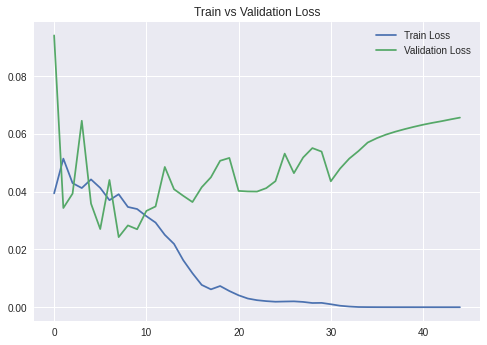

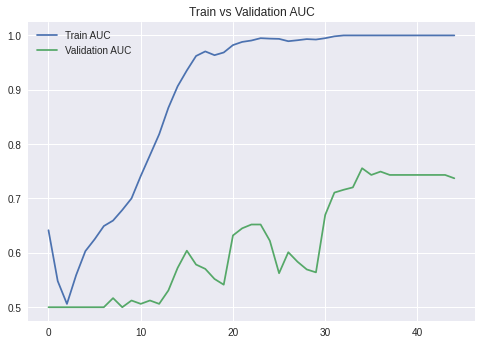


-------------------------------
Best metrics for validation set on Epoch 35:
Loss::      0.0570
AUC::       0.7557
Accuracy::  0.8250
F1::        0.6182
Precision:: 0.6071
Recall::    0.6296
Confusion Matrix:
 [[246  33]
 [ 30  51]]
-------------------------------


--------------------------------------------------------------------
--------------------------------------------------------------------
Running coronal - slice:2 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating final reference file for prepared images...
Loading untrained model...
NeuralNetwork(
  (features): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilatio

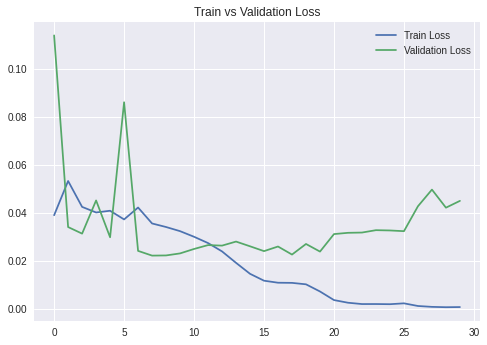

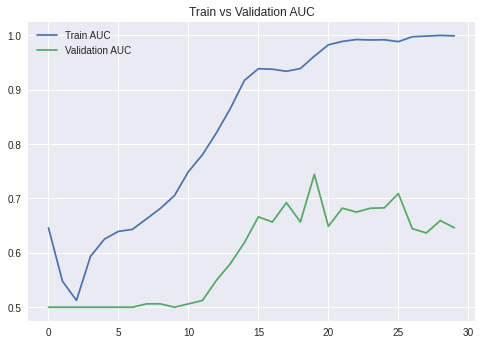


-------------------------------
Best metrics for validation set on Epoch 20:
Loss::      0.0238
AUC::       0.7443
Accuracy::  0.8278
F1::        0.6076
Precision:: 0.6234
Recall::    0.5926
Confusion Matrix:
 [[250  29]
 [ 33  48]]
-------------------------------


--------------------------------------------------------------------
--------------------------------------------------------------------
Running coronal - slice:3 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating final reference file for prepared images...
Loading untrained model...
NeuralNetwork(
  (features): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilatio

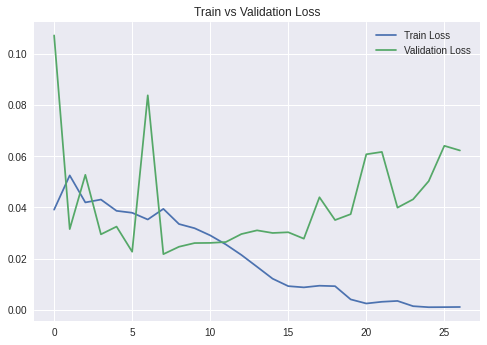

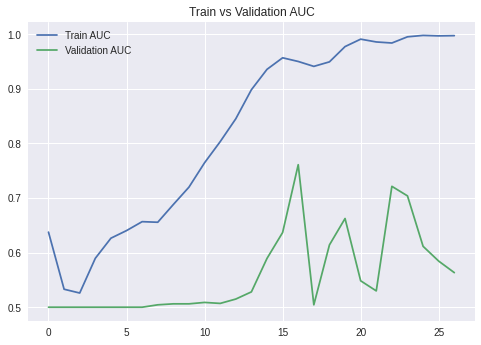


-------------------------------
Best metrics for validation set on Epoch 17:
Loss::      0.0278
AUC::       0.7611
Accuracy::  0.8333
F1::        0.6296
Precision:: 0.6296
Recall::    0.6296
Confusion Matrix:
 [[249  30]
 [ 30  51]]
-------------------------------


--------------------------------------------------------------------
--------------------------------------------------------------------
Running coronal - slice:4 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating final reference file for prepared images...
Loading untrained model...
NeuralNetwork(
  (features): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilatio

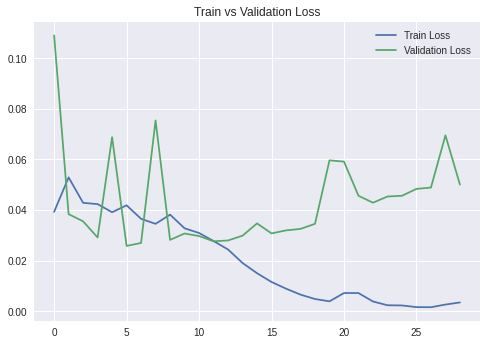

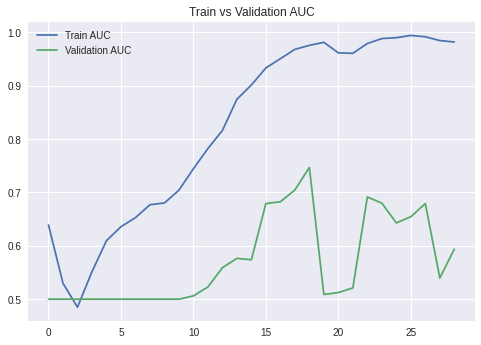


-------------------------------
Best metrics for validation set on Epoch 19:
Loss::      0.0346
AUC::       0.7469
Accuracy::  0.8250
F1::        0.6087
Precision:: 0.6125
Recall::    0.6049
Confusion Matrix:
 [[248  31]
 [ 32  49]]
-------------------------------


--------------------------------------------------------------------
--------------------------------------------------------------------
Running coronal - slice:5 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating final reference file for prepared images...
Loading untrained model...
NeuralNetwork(
  (features): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilatio

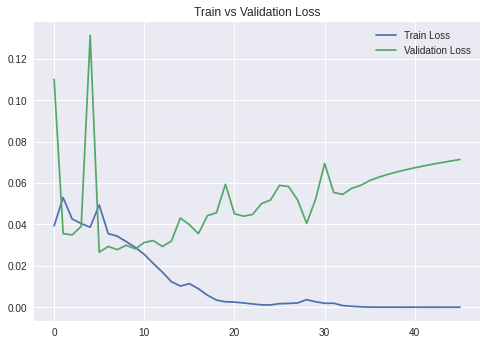

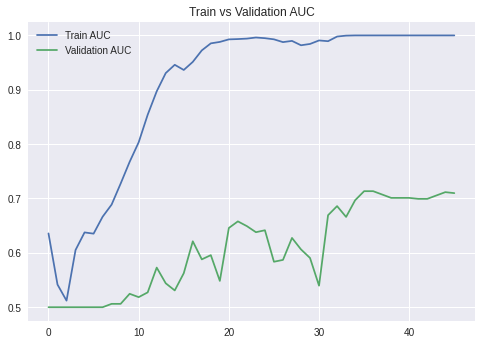


-------------------------------
Best metrics for validation set on Epoch 36:
Loss::      0.0612
AUC::       0.7135
Accuracy::  0.8139
F1::        0.5621
Precision:: 0.5972
Recall::    0.5309
Confusion Matrix:
 [[250  29]
 [ 38  43]]
-------------------------------


--------------------------------------------------------------------
--------------------------------------------------------------------
Running coronal - slice:6 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating final reference file for prepared images...
Loading untrained model...
NeuralNetwork(
  (features): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilatio

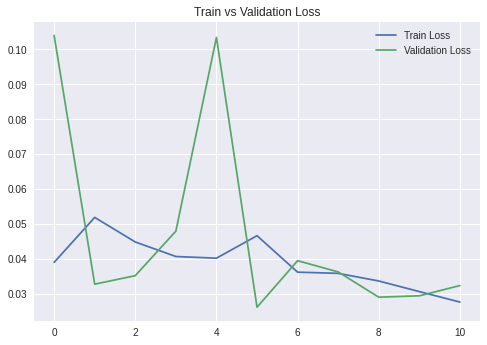

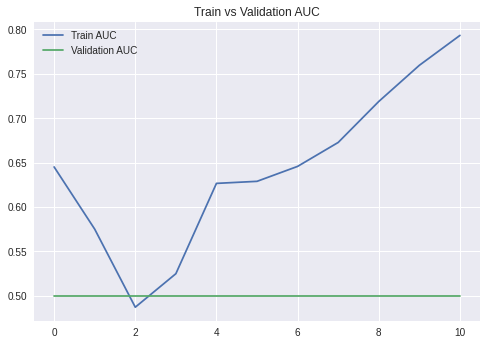


-------------------------------
Best metrics for validation set on Epoch 1:
Loss::      0.1040
AUC::       0.5000
Accuracy::  0.7750
F1::        0.0000
Precision:: 0.0000
Recall::    0.0000
Confusion Matrix:
 [[279   0]
 [ 81   0]]
-------------------------------


--------------------------------------------------------------------
--------------------------------------------------------------------
Running coronal - slice:7 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating final reference file for prepared images...
Loading untrained model...
NeuralNetwork(
  (features): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation

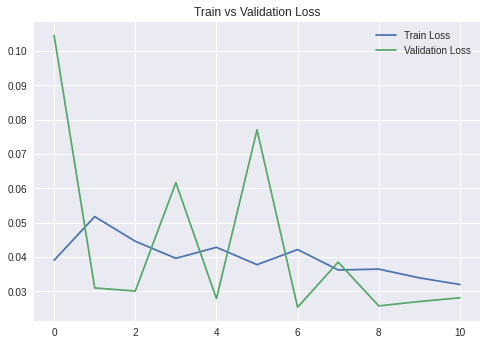

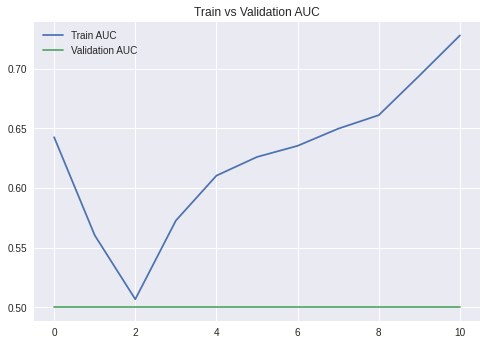


-------------------------------
Best metrics for validation set on Epoch 1:
Loss::      0.1045
AUC::       0.5000
Accuracy::  0.7750
F1::        0.0000
Precision:: 0.0000
Recall::    0.0000
Confusion Matrix:
 [[279   0]
 [ 81   0]]
-------------------------------


--------------------------------------------------------------------
--------------------------------------------------------------------
Running coronal - slice:8 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating final reference file for prepared images...
Loading untrained model...
NeuralNetwork(
  (features): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation

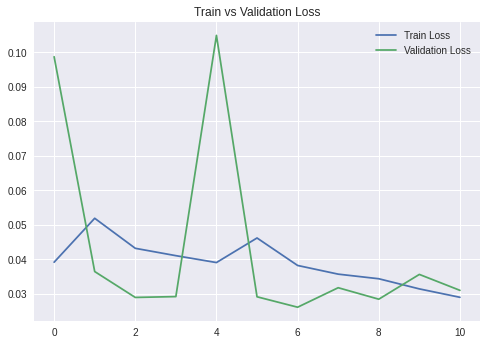

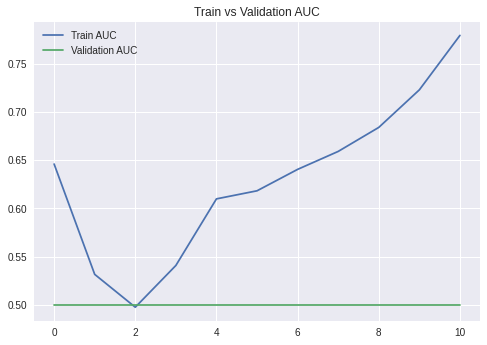


-------------------------------
Best metrics for validation set on Epoch 1:
Loss::      0.0987
AUC::       0.5000
Accuracy::  0.7750
F1::        0.0000
Precision:: 0.0000
Recall::    0.0000
Confusion Matrix:
 [[279   0]
 [ 81   0]]
-------------------------------


--------------------------------------------------------------------
--------------------------------------------------------------------
Running coronal - slice:9 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating final reference file for prepared images...
Loading untrained model...
NeuralNetwork(
  (features): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation

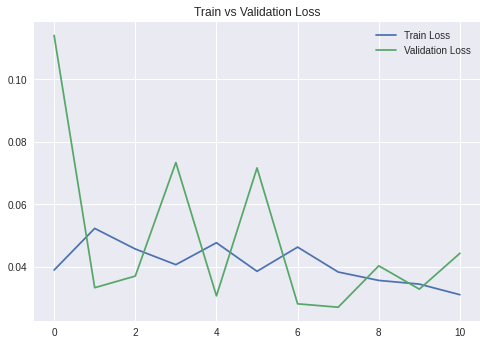

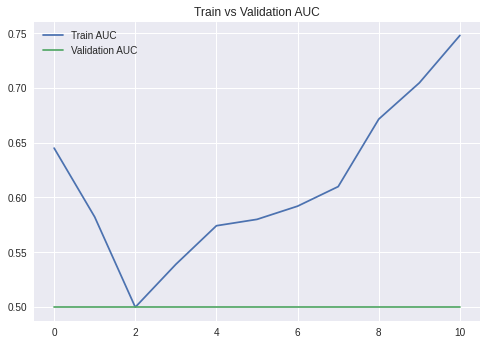


-------------------------------
Best metrics for validation set on Epoch 1:
Loss::      0.1140
AUC::       0.5000
Accuracy::  0.7750
F1::        0.0000
Precision:: 0.0000
Recall::    0.0000
Confusion Matrix:
 [[279   0]
 [ 81   0]]
-------------------------------


--------------------------------------------------------------------
--------------------------------------------------------------------
Running coronal - slice:10 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating final reference file for prepared images...
Loading untrained model...
NeuralNetwork(
  (features): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilatio

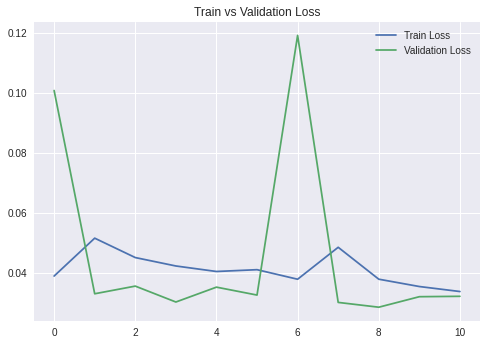

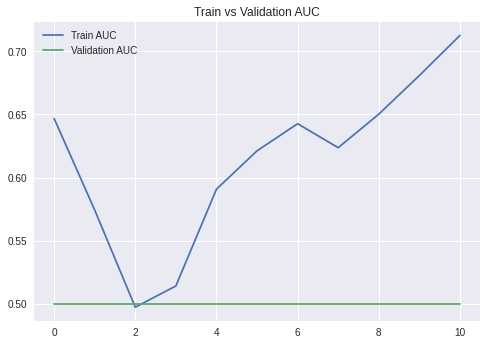


-------------------------------
Best metrics for validation set on Epoch 1:
Loss::      0.1008
AUC::       0.5000
Accuracy::  0.7750
F1::        0.0000
Precision:: 0.0000
Recall::    0.0000
Confusion Matrix:
 [[279   0]
 [ 81   0]]
-------------------------------


--------------------------------------------------------------------
--------------------------------------------------------------------
Running coronal - slice:11 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating final reference file for prepared images...
Loading untrained model...
NeuralNetwork(
  (features): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilatio

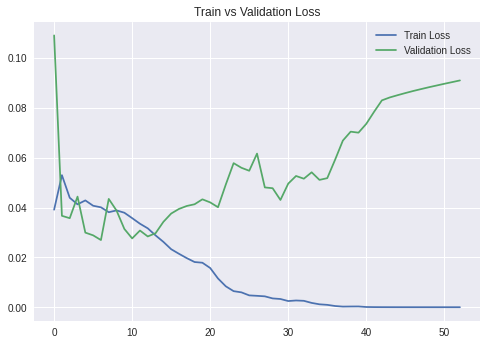

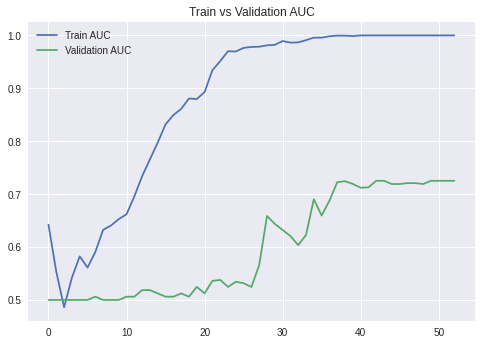


-------------------------------
Best metrics for validation set on Epoch 43:
Loss::      0.0830
AUC::       0.7252
Accuracy::  0.7778
F1::        0.5604
Precision:: 0.5050
Recall::    0.6296
Confusion Matrix:
 [[229  50]
 [ 30  51]]
-------------------------------


--------------------------------------------------------------------
--------------------------------------------------------------------
Running coronal - slice:12 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating final reference file for prepared images...
Loading untrained model...
NeuralNetwork(
  (features): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilati

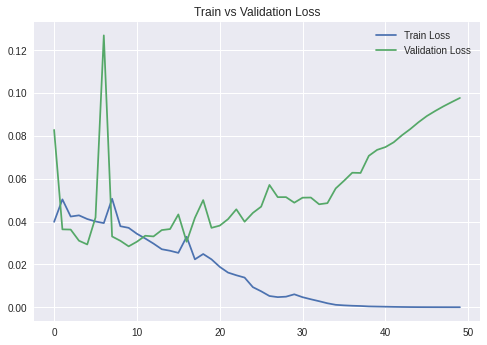

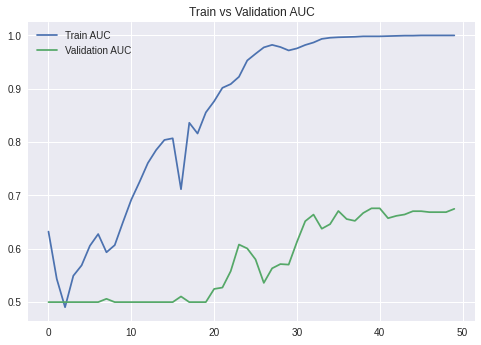


-------------------------------
Best metrics for validation set on Epoch 40:
Loss::      0.0734
AUC::       0.6758
Accuracy::  0.7556
F1::        0.4943
Precision:: 0.4624
Recall::    0.5309
Confusion Matrix:
 [[229  50]
 [ 38  43]]
-------------------------------


--------------------------------------------------------------------
--------------------------------------------------------------------
Running coronal - slice:13 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating final reference file for prepared images...
Loading untrained model...
NeuralNetwork(
  (features): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilati

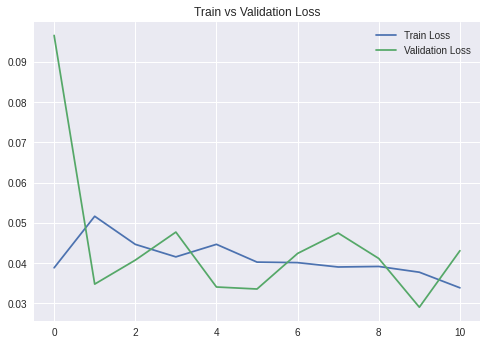

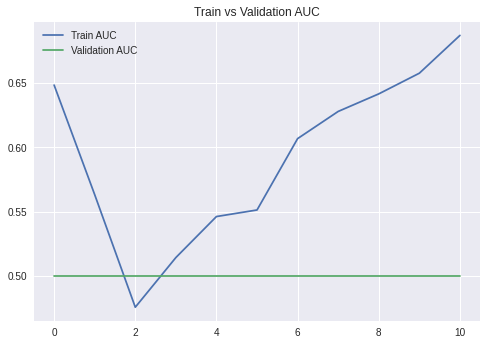


-------------------------------
Best metrics for validation set on Epoch 1:
Loss::      0.0966
AUC::       0.5000
Accuracy::  0.7750
F1::        0.0000
Precision:: 0.0000
Recall::    0.0000
Confusion Matrix:
 [[279   0]
 [ 81   0]]
-------------------------------


--------------------------------------------------------------------
--------------------------------------------------------------------
Running coronal - slice:14 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating final reference file for prepared images...
Loading untrained model...
NeuralNetwork(
  (features): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilatio

In [ ]:
df_results_shallow_c1 = run_mris_experiments(
                          orientation_and_slices = [
                                         ('coronal',list(range(0,50)))
                                         ],
                          num_repeats = 1,
                          model='shallow_cnn',
                          classes=['MCI','CN'],
                          mri_config = {
                            'num_samples':0,
                            'num_rotations':0,
                            'sampling_range':1,
                            'mri_reference':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/reference/PROCESSED_MRI_REFERENCE_ALL_ORIENTATIONS_20211030_2026.csv',
                            'output_path':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/mri/experiments/',
                          },
                          additional_experiment_params = {'lr':0.0001,
                            'batch_size':16,
                            'optimizer':'adam',
                            'max_epochs':100,
                            'early_stop':10,
                            'prediction_threshold':0.5},
                          save_path = '/content/gdrive/MyDrive/Lucas_Thimoteo/data/RESULTS_MCI_SHALLOW_CORONAL1.csv')

In [ ]:
df_results_shallow_c1.sort_values("validation_auc",ascending=False)

In [ ]:
df_results_shallow_c2 = run_mris_experiments(
                          orientation_and_slices = [
                                         ('coronal',list(range(14,100)))
                                         ],
                          num_repeats = 1,
                          model='shallow_cnn',
                          classes=['MCI','CN'],
                          mri_config = {
                            'num_samples':0,
                            'num_rotations':0,
                            'sampling_range':1,
                            'mri_reference':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/reference/PROCESSED_MRI_REFERENCE_ALL_ORIENTATIONS_20211030_2026.csv',
                            'output_path':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/mri/experiments/',
                          },
                          additional_experiment_params = {'lr':0.0001,
                            'batch_size':16,
                            'optimizer':'adam',
                            'max_epochs':100,
                            'early_stop':10,
                            'prediction_threshold':0.5},
                          save_path = '/content/gdrive/MyDrive/Lucas_Thimoteo/data/RESULTS_MCI_SHALLOW_CORONAL2.csv')

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
df_results_shallow_c2.sort_values("validation_auc",ascending=False)

In [ ]:
df_results_shallow_a1 = run_mris_experiments(
                          orientation_and_slices = [
                                         ('axial',list(range(0,50)))
                                         ],
                          num_repeats = 1,
                          model='shallow_cnn',
                          classes=['MCI','CN'],
                          mri_config = {
                            'num_samples':0,
                            'num_rotations':0,
                            'sampling_range':1,
                            'mri_reference':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/reference/PROCESSED_MRI_REFERENCE_ALL_ORIENTATIONS_20211030_2026.csv',
                            'output_path':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/mri/experiments/',
                          },
                          additional_experiment_params = {'lr':0.0001,
                            'batch_size':16,
                            'optimizer':'adam',
                            'max_epochs':100,
                            'early_stop':10,
                            'prediction_threshold':0.5},
                          save_path = '/content/gdrive/MyDrive/Lucas_Thimoteo/data/RESULTS_MCI_SHALLOW_AXIAL1.csv')

In [ ]:
df_results_shallow_a1.sort_values("validation_auc",ascending=False)


In [ ]:
df_results_shallow_a2 = run_mris_experiments(
                          orientation_and_slices = [
                                         ('axial',list(range(50,100)))
                                         ],
                          num_repeats = 1,
                          model='shallow_cnn',
                          classes=['MCI','CN'],
                          mri_config = {
                            'num_samples':0,
                            'num_rotations':0,
                            'sampling_range':1,
                            'mri_reference':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/reference/PROCESSED_MRI_REFERENCE_ALL_ORIENTATIONS_20211030_2026.csv',
                            'output_path':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/mri/experiments/',
                          },
                          additional_experiment_params = {'lr':0.0001,
                            'batch_size':16,
                            'optimizer':'adam',
                            'max_epochs':100,
                            'early_stop':10,
                            'prediction_threshold':0.5},
                          save_path = '/content/gdrive/MyDrive/Lucas_Thimoteo/data/RESULTS_MCI_SHALLOW_AXIAL2.csv')

In [ ]:
df_results_shallow_a2.sort_values("validation_auc",ascending=False)

In [ ]:
df_results_shallow_s1 = run_mris_experiments(
                          orientation_and_slices = [
                                         ('sagittal',list(range(0,50)))
                                         ],
                          num_repeats = 1,
                          model='shallow_cnn',
                          classes=['MCI','CN'],
                          mri_config = {
                            'num_samples':0,
                            'num_rotations':0,
                            'sampling_range':1,
                            'mri_reference':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/reference/PROCESSED_MRI_REFERENCE_ALL_ORIENTATIONS_20211030_2026.csv',
                            'output_path':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/mri/experiments/',
                          },
                          additional_experiment_params = {'lr':0.0001,
                            'batch_size':16,
                            'optimizer':'adam',
                            'max_epochs':100,
                            'early_stop':10,
                            'prediction_threshold':0.5},
                          save_path = '/content/gdrive/MyDrive/Lucas_Thimoteo/data/RESULTS_MCI_SHALLOW_SAGITTAL1.csv')

In [ ]:
df_results_shallow_s1.sort_values("validation_auc",ascending=False)


In [ ]:
df_results_shallow_s2 = run_mris_experiments(
                          orientation_and_slices = [
                                         ('sagittal',list(range(50,100)))
                                         ],
                          num_repeats = 1,
                          model='shallow_cnn',
                          classes=['MCI','CN'],
                          mri_config = {
                            'num_samples':0,
                            'num_rotations':0,
                            'sampling_range':1,
                            'mri_reference':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/reference/PROCESSED_MRI_REFERENCE_ALL_ORIENTATIONS_20211030_2026.csv',
                            'output_path':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/mri/experiments/',
                          },
                          additional_experiment_params = {'lr':0.0001,
                            'batch_size':16,
                            'optimizer':'adam',
                            'max_epochs':100,
                            'early_stop':10,
                            'prediction_threshold':0.5},
                          save_path = '/content/gdrive/MyDrive/Lucas_Thimoteo/data/RESULTS_MCI_SHALLOW_SAGITTAL2.csv')

In [ ]:
df_results_shallow_s2.sort_values("validation_auc",ascending=False)


# Suggestions

- Modify AUC for specificity=0.75 or specificity=0.90 
- Moving Average validation_metric
- Early stopping by F1
- Increase mini-batch size: 64-128
- Increase Epochs: 150-200